In [1]:
!pip install pandas
!pip install rasterio
!pip install catboost
!pip install seaborn
!pip install xgboost
!pip install tsfresh
!pip install haversine
!pip install pygeohash
!pip install category_encoders
!pip install sklearn

In [87]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib widget

from sklearn import preprocessing
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [88]:
pd.set_option('display.max_columns', 17000)
pd.set_option('display.max_row', 17000)

In [89]:
df = pd.read_csv("D:\Python\Zindi\Flood\Train.csv", sep=",", index_col='Square_ID'
                )

In [90]:
#Попробовать добавить доп данные и проверить НАн
import rasterio 
import os
def addtif(file, name, clip=False):
    # Takes GeoTIFF file and name of column to be added to dataframes. Samples from the raster at (X, Y) coordinates of each
    # rectangular area, and adds these values to training & test dataframes.
    
    # Clip coordinates for dataset that does not cover full problem area
    if clip == True:
        coords = [(x, np.maximum(y, -16.599))
                  for x, y in zip(df.X, df.Y)]
    else:
        coords = [(x, y) for x, y in zip(df.X, df.Y)]

    # Open the raster and store metadata
    src = rasterio.open(os.path.join('data',file))

    # Sample the raster at every point location and store values in DataFrame
    df[name] = [z[0] for z in src.sample(coords)]


addtif('D:\Python\Zindi\Flood\dtwareas.tif', 'water_area_distance', clip=True)
addtif('D:\Python\Zindi\Flood\dtwaterways.tif', 'river_distance')
addtif('D:\Python\Zindi\Flood\dtwlines.tif', 'water_lines_distance')
addtif('D:\Python\Zindi\Flood\soilmoisture4.tif', 'soil_moisture')




In [91]:
train = df.drop(['precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
 'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
 'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
 'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
 'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
 'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
 'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
 'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
 'precip 2019-05-12 - 2019-05-19'], axis=1)

In [92]:
X_fulltest = df.drop(['precip 2014-11-16 - 2014-11-23',
 'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
 'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
 'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
 'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
 'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
 'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
 'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
 'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15'], axis=1)

Feature generating

In [93]:
Train_stat = train.drop (['X', 'Y', 'target_2015', 'elevation', 'LC_Type1_mode', 
                          'water_area_distance',
                         'river_distance',  'water_lines_distance' ,    'soil_moisture' , 
                          
                         ], axis=1)

In [94]:
Train_feature = Train_stat.copy()

In [95]:
Train_feature2 = Train_stat.copy()

In [96]:
from scipy.stats import norm
from scipy import stats
#Train_feature2['Mean'] = Train_stat.mean(axis=1)
Train_feature2['Median'] = Train_stat.median(axis=1)
#Train_feature2['Max'] = Train_stat.max(axis=1)
Train_feature2['Sum'] = Train_stat.sum(axis=1)
Train_feature2['Count_rainyperiod'] = (Train_stat != 0).sum(axis=1)  

In [97]:
Train_feature2  = Train_feature2.drop(['precip 2014-11-16 - 2014-11-23',
 'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
 'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
 'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
 'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
 'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
 'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
 'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
 'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15'], axis=1)

автогенерация

In [98]:
Train_feature.reset_index('Square_ID', inplace=True)

In [99]:
Train_feature1 = Train_feature.replace('', np.nan).set_index('Square_ID').stack().reset_index(name='value').drop('level_1',1)

In [100]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features
import tsfresh
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns

In [101]:
from tsfresh import extract_relevant_features
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns
settings_comprehensive = EfficientFCParameters()

#train_time_series = Train_feature1['Square_ID']
#augmenter = RelevantFeatureAugmenter()
#augmenter.set_timeseries_container(train_time_series)
#X =augmenter.fit(Train_feature1, y = train['target_2015'] )
#X = extract_relevant_features(Train_feature1, train['target_2015'], column_id='Square_ID', column_value='value'
                              #default_fc_parameters=settings_comprehensive
                         #    )

X = extract_features(Train_feature1, column_id='Square_ID', column_value='value', n_jobs=8, 
                                      default_fc_parameters=EfficientFCParameters())



Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [03:39<00:00,  5.48s/it]


In [102]:
impute(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16466 entries, 4e3c3896-14ce-11ea-bce5-f49634744a41 to 4e6f5e01-14ce-11ea-bce5-f49634744a41
Columns: 748 entries, value__abs_energy to value__variance_larger_than_standard_deviation
dtypes: float64(748)
memory usage: 94.1+ MB


In [103]:
smaller = select_features(X, train['target_2015'], fdr_level = .0000000000000000000000005, ml_task = 'regression')

In [104]:
smaller.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16466 entries, 4e3c3896-14ce-11ea-bce5-f49634744a41 to 4e6f5e01-14ce-11ea-bce5-f49634744a41
Columns: 115 entries, value__autocorrelation__lag_4 to value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2
dtypes: float64(115)
memory usage: 14.6+ MB


In [105]:
smaller_fc_parameters = tsfresh.feature_extraction.settings.from_columns(smaller)

In [106]:
trainfull1 = train.merge(smaller, how='left', left_index=True, right_index=True)

In [107]:
trainfull1 = trainfull1.merge(Train_feature2, how='left', left_index=True, right_index=True)

In [108]:
trainfull1  = trainfull1.drop(['precip 2014-11-16 - 2014-11-23',
 'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
 'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
 'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
 'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
 'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
 'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
 'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
 'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15'], axis=1)

Geofeaturing

In [109]:



trainfull1['arctan2'] = np.arctan2(trainfull1['Y'], trainfull1['X'])
trainfull1['radial_r'] = np.sqrt( np.power(trainfull1['Y'],2) + np.power(trainfull1['X'],2))

trainfull1['rot45X'] = .707* trainfull1['Y'] + .707* trainfull1['X'] 
trainfull1['rot45Y'] = .707* trainfull1['Y'] - .707* trainfull1['X']

trainfull1['rot30X'] = (1.732/2)* trainfull1['X'] + (1./2)* trainfull1['Y'] 
trainfull1['rot30Y'] = (1.732/2)* trainfull1['Y'] - (1./2)* trainfull1['X']

trainfull1['rot60X'] = (1./2)* trainfull1['X'] + (1.732/2)* trainfull1['Y'] 
trainfull1['rot60Y'] = (1./2)* trainfull1['Y'] - (1.732/2)* trainfull1['X']





In [110]:
trainfull1['pickup_X'] = np.cos(trainfull1['X']) * np.cos(trainfull1['Y'])
trainfull1['pickup_Y'] = np.cos(trainfull1['X']) * np.sin(trainfull1['Y'])
trainfull1['pickup_Z'] = np.sin(trainfull1['X'])

In [111]:
from sklearn.decomposition import PCA
data = trainfull1
coordinates = data[['X','Y']].values
pca_obj = PCA().fit(coordinates)
trainfull1['pca_x'] = pca_obj.transform(data[['X', 'Y']])[:,0]
trainfull1['pca_y'] = pca_obj.transform(data[['X','Y']])[:,1]

In [112]:
#base case Balantayer
from haversine import haversine
city_center_coordinates = (35.003815, -15.788289)

trainfull1['dist_center'] = trainfull1.apply(lambda row: haversine((row['X'], row['Y']), city_center_coordinates), axis=1)

In [113]:
import pygeohash as gh
# создаем переменную - геохеш
trainfull1['geohash'] = trainfull1.apply(lambda x: gh.encode(x['X'], x['Y'], precision=6), axis=1) #лучший результат с 6 знаками


In [114]:
geohash_center = gh.encode(35.003815, -15.788289, precision=6)

# преобразовываем геохеш "центра" во множество
geohash_center_set = set(geohash_center)
# создаем переменную - количество совпадающих символов
# (учитываем повторяющиеся символы)
trainfull1['match'] = trainfull1['geohash'].apply(lambda x: sum([let1 == let2 for let1, let2 in zip(geohash_center, x)]))
# создаем переменную - количество совпадающих символов
# (не учитываем повторяющиеся символы)
trainfull1['match2'] = trainfull1['geohash'].apply(lambda x: len(set(x) & geohash_center_set))

In [115]:
trainfull1['geohash + LC_Type1_mode'] = trainfull1.apply(
lambda x: f"{x['geohash']} + {x['LC_Type1_mode']}",
axis=1)

In [116]:
median = trainfull1.groupby('LC_Type1_mode')['elevation'].median()
trainfull1['Type1_median_elevation'] = trainfull1['LC_Type1_mode'].map(median)

In [117]:
#ломает посілку
#mediansm = trainfull1.groupby('LC_Type1_mode')['Sum'].median()
#trainfull1['Type1_median_sum'] = trainfull1['LC_Type1_mode'].map(mediansm)

In [118]:
def haversine_dist(lat1,lng1,lat2,lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # Earth's radius taken from google
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h


def manhattan_dist(lat1, lng1, lat2, lng2):
    '''
    calculating two haversine distances by,
     - avoiding Latitude of one point 
     - avoiding Longitude of one point
    and adding it together.
    '''
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a + b

trainfull1['manhattan_dist_center1'] = trainfull1.apply(lambda row: manhattan_dist(row['X'], row['Y'], 35.003815, -15.788289), axis=1)

In [119]:
temp = trainfull1['LC_Type1_mode'].value_counts().to_dict()
trainfull1['LC_Type1_counts'] = trainfull1['LC_Type1_mode'].map(temp)

# Обучим на всем train сете предскажем на тесте и сформируем посылку на Zindi

In [120]:
Test_stat = X_fulltest.drop (['X', 'Y', 'target_2015', 'elevation', 'LC_Type1_mode', 
                              'water_area_distance',
                          'river_distance',  'water_lines_distance', 'soil_moisture',
                            
                              #'elev_diff_mean'
                             ], axis=1)

In [121]:
Test_feature = Test_stat.copy()

In [122]:
Test_feature2 = Test_stat.copy()

In [123]:
from scipy.stats import norm
from scipy import stats
#Test_feature2['Mean'] = Test_stat.mean(axis=1)
Test_feature2['Median'] = Test_stat.median(axis=1)
#Test_feature2['Max'] = Test_stat.max(axis=1)
Test_feature2['Sum'] = Test_stat.sum(axis=1)
Test_feature2['Count_rainyperiod'] = (Test_stat != 0).sum(axis=1)

In [124]:
Test_feature2  = Test_feature2.drop(['precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
 'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
 'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
 'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
 'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
 'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
 'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
 'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
 'precip 2019-05-12 - 2019-05-19'], axis=1)

autogeneration

In [125]:
Test_feature.reset_index('Square_ID', inplace=True)
Test_feature1 = Test_feature.replace('', np.nan).set_index('Square_ID').stack().reset_index(name='value').drop('level_1',1)

In [126]:


X_t = extract_features(Test_feature1, column_id='Square_ID', column_value='value', n_jobs=8, 
                              default_fc_parameters=smaller_fc_parameters['value'] )
#X_selected = selector.transform(Test_feature1)

X_testsubm1 = X_fulltest.merge(X_t, how='left', left_index=True, right_index=True)




Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:26<00:00,  2.17s/it]


In [127]:
X_testsubm1 = X_testsubm1.merge(Test_feature2, how='left', left_index=True, right_index=True)

In [128]:

X_testsubm1  = X_testsubm1.drop(['precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
 'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
 'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
 'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
 'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
 'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
 'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
 'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
 'precip 2019-05-12 - 2019-05-19'], axis=1)


In [129]:


X_testsubm1['arctan2'] = np.arctan2(X_testsubm1['Y'], X_testsubm1['X'])
X_testsubm1['radial_r'] = np.sqrt( np.power(X_testsubm1['Y'],2) + np.power(X_testsubm1['X'],2))

X_testsubm1['rot45X'] = .707* X_testsubm1['Y'] + .707* X_testsubm1['X'] 
X_testsubm1['rot45Y'] = .707* X_testsubm1['Y'] - .707* X_testsubm1['X']

X_testsubm1['rot30X'] = (1.732/2)* X_testsubm1['X'] + (1./2)* X_testsubm1['Y'] 
X_testsubm1['rot30Y'] = (1.732/2)* X_testsubm1['Y'] - (1./2)* X_testsubm1['X']

X_testsubm1['rot60X'] = (1./2)* X_testsubm1['X'] + (1.732/2)* X_testsubm1['Y'] 
X_testsubm1['rot60Y'] = (1./2)* X_testsubm1['Y'] - (1.732/2)* X_testsubm1['X']





In [130]:
X_testsubm1['pickup_X'] = np.cos(X_testsubm1['X']) * np.cos(X_testsubm1['Y'])
X_testsubm1['pickup_Y'] = np.cos(X_testsubm1['X']) * np.sin(X_testsubm1['Y'])
X_testsubm1['pickup_Z'] = np.sin(X_testsubm1['X'])

In [131]:
from sklearn.decomposition import PCA
data = X_testsubm1
coordinates = data[['X','Y']].values
pca_obj = PCA().fit(coordinates)
X_testsubm1['pca_x'] = pca_obj.transform(data[['X', 'Y']])[:,0]
X_testsubm1['pca_y'] = pca_obj.transform(data[['X','Y']])[:,1]

In [132]:
# базовый вариант
from haversine import haversine
city_center_coordinates = (35.003815, -15.788289)

X_testsubm1['dist_center'] = X_testsubm1.apply(lambda row: haversine((row['X'], row['Y']), city_center_coordinates), axis=1)


In [133]:
import pygeohash as gh
# создаем переменную - геохеш
X_testsubm1['geohash'] = X_testsubm1.apply(lambda x: gh.encode(x['X'], x['Y'], precision=6), axis=1) #лучший результат с 6 знаками
# выводим первые 5 наблюдений

In [134]:
geohash_center = gh.encode(35.003815, -15.788289, precision=6)

# преобразовываем геохеш "центра" во множество
geohash_center_set = set(geohash_center)
# создаем переменную - количество совпадающих символов
# (учитываем повторяющиеся символы)
X_testsubm1['match'] = X_testsubm1['geohash'].apply(lambda x: sum([let1 == let2 for let1, let2 in zip(geohash_center, x)]))
# создаем переменную - количество совпадающих символов
# (не учитываем повторяющиеся символы)
X_testsubm1['match2'] = X_testsubm1['geohash'].apply(lambda x: len(set(x) & geohash_center_set))

In [135]:
# пишем функцию, которая создает взаимодействие
# в результате конъюнкции переменных
X_testsubm1['geohash + LC_Type1_mode'] = X_testsubm1.apply(
lambda x: f"{x['geohash']} + {x['LC_Type1_mode']}",
axis=1)

In [136]:
median = X_testsubm1.groupby('LC_Type1_mode')['elevation'].median()
X_testsubm1['Type1_median_elevation'] = X_testsubm1['LC_Type1_mode'].map(median)

In [137]:
#mediansm = X_testsubm1.groupby('LC_Type1_mode')['Sum'].median()
#X_testsubm1['Type1_median_Sum'] = X_testsubm1['LC_Type1_mode'].map(mediansm)

In [138]:
def haversine_dist(lat1,lng1,lat2,lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # Earth's radius taken from google
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h


def manhattan_dist(lat1, lng1, lat2, lng2):
    '''
    calculating two haversine distances by,
     - avoiding Latitude of one point 
     - avoiding Longitude of one point
    and adding it together.
    '''
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a + b

X_testsubm1['manhattan_dist_center1'] = X_testsubm1.apply(lambda row: manhattan_dist(row['X'], row['Y'], 35.003815, -15.788289), axis=1)

In [139]:
temp = X_testsubm1['LC_Type1_mode'].value_counts().to_dict()
X_testsubm1['LC_Type1_counts'] = X_testsubm1['LC_Type1_mode'].map(temp)

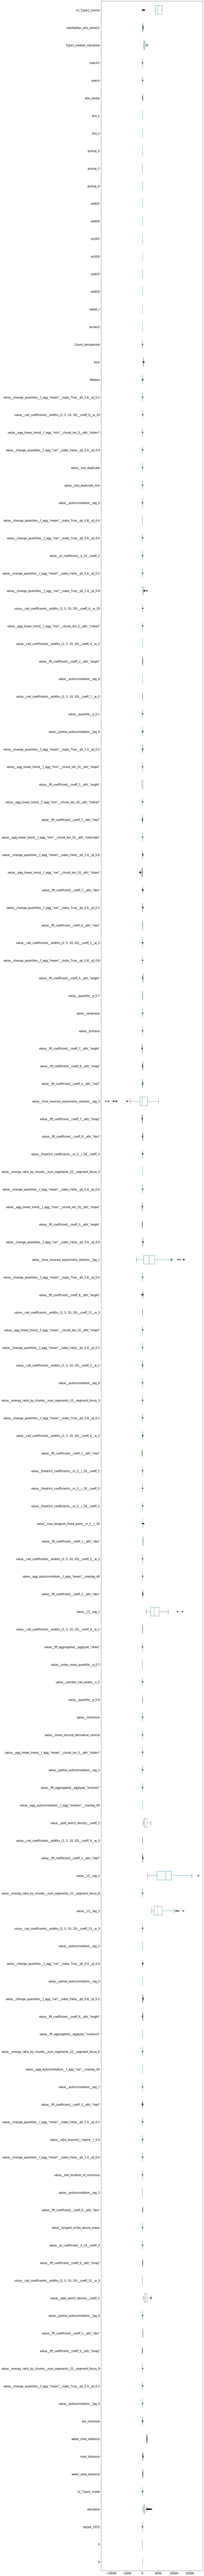

In [140]:
#remove outliers
plt.figure(figsize = (10, 260))
boxplot = trainfull1.boxplot(grid=False, rot=0, fontsize=15, vert=False)

In [141]:
#remove outliers
def outliers_IQR(data, col):
    lower_quartile = data[col].quantile(0.25) #0.25
    upper_quartile = data[col].quantile(0.75) #0.75
    IQR = upper_quartile - lower_quartile
    outlier_thresh = 1.5 * IQR
    return data[data[col].between((lower_quartile - outlier_thresh), (upper_quartile + outlier_thresh))]

trainfull1 = outliers_IQR(trainfull1, 'value__c3__lag_3')
trainfull1 = outliers_IQR(trainfull1, 'value__c3__lag_2')
trainfull1 = outliers_IQR(trainfull1, 'value__c3__lag_1')
trainfull1 = outliers_IQR(trainfull1, 'value__time_reversal_asymmetry_statistic__lag_1')
trainfull1 = outliers_IQR(trainfull1, 'value__time_reversal_asymmetry_statistic__lag_3')
trainfull1 = outliers_IQR(trainfull1, 'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8')


In [142]:
print(X_testsubm1.isnull().sum())

X                                                                           0
Y                                                                           0
target_2015                                                                 0
elevation                                                                   0
LC_Type1_mode                                                               0
water_area_distance                                                         0
river_distance                                                              0
water_lines_distance                                                        0
soil_moisture                                                               0
value__agg_autocorrelation__f_agg_"mean"__maxlag_40                         0
value__agg_autocorrelation__f_agg_"median"__maxlag_40                       0
value__agg_autocorrelation__f_agg_"var"__maxlag_40                          0
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"

dtype: int64


In [143]:
X_testsubm1['value__friedrich_coefficients__m_3__r_30__coeff_0'].fillna(trainfull1['value__friedrich_coefficients__m_3__r_30__coeff_0'].median(), inplace=True)
X_testsubm1['value__friedrich_coefficients__m_3__r_30__coeff_1'].fillna(trainfull1['value__friedrich_coefficients__m_3__r_30__coeff_1'].median(), inplace=True)
X_testsubm1['value__friedrich_coefficients__m_3__r_30__coeff_2'].fillna(trainfull1['value__friedrich_coefficients__m_3__r_30__coeff_2'].median(), inplace=True)
X_testsubm1['value__friedrich_coefficients__m_3__r_30__coeff_3'].fillna(trainfull1['value__friedrich_coefficients__m_3__r_30__coeff_3'].median(), inplace=True)
X_testsubm1['value__max_langevin_fixed_point__m_3__r_30'].fillna(trainfull1['value__max_langevin_fixed_point__m_3__r_30'].median(), inplace=True)


In [144]:
trainfull1  = trainfull1.drop(['value__autocorrelation__lag_0'], axis=1)
X_testsubm1  = X_testsubm1.drop(['value__autocorrelation__lag_0'], axis=1)
                             
                                

In [145]:
trainfull1.shape, X_testsubm1.shape

((13779, 147), (16466, 147))

In [146]:
y_trainfull = trainfull1['target_2015'].copy()


In [147]:
X_trainfullsubm = trainfull1.drop('target_2015', axis=1)
X_testfullsubm = X_testsubm1.copy()

In [148]:
X_testfullsubm = X_testfullsubm.drop('target_2015', axis=1)

In [149]:
# импортируем класс TargetEncoder из пакета category_encoders
from category_encoders import TargetEncoder
# создаем экземпляр класса TargetEncoder (модель)
# для обучающей выборки
target_enc = TargetEncoder(cols=['geohash', 
                                'geohash + LC_Type1_mode'
                                
                                ], smoothing=3, min_samples_leaf=1)
# обучаем модель, т.е. создаем таблицу, в соответствии с которой
# категориям предиктора в обучающей выборке будут сопоставлены
# сглаженные средние значения зависимой переменной
target_enc.fit(X_trainfullsubm, y_trainfull)
# применяем модель к обучающей выборке, категории предиктора
# в обучающей выборке заменяются на сглаженные средние значения зависимой
# переменной
target_encoded_train = target_enc.transform(X_trainfullsubm, y_trainfull)

# создаем экземпляр класса TargetEncoder (модель)
# для тестовой выборки
target_enc_test = TargetEncoder(cols=['geohash',
                                     'geohash + LC_Type1_mode'
                                      
                                     ], smoothing=False)
# обучаем модель, т.е. создаем таблицу, в соответствии с которой
# категориям предиктора в тестовой выборке будут сопоставлены
# обычные средние значения зависимой переменной в этих категориях,
# вычисленные на обучающей выборке
target_enc_test.fit(X_trainfullsubm, y_trainfull)
# применяем модель к тестовой выборке,
# категории предиктора в тестовой выборке заменяются на обычные
# средние значения зависимой переменной в этих категориях,
# вычисленные на обучающей выборке
target_encoded_test = target_enc_test.transform(X_testfullsubm)

In [150]:
target_encoded_train.shape

(13779, 146)

In [151]:
target_encoded_test.shape


(16466, 146)

In [152]:
target_encoded_train = pd.DataFrame(target_encoded_train, index=trainfull1.index, columns=trainfull1.columns)
target_encoded_test = pd.DataFrame(target_encoded_test, index=X_testsubm1.index, columns=X_testsubm1.columns)

In [153]:
target_encoded_train = target_encoded_train.drop('target_2015', axis=1)
target_encoded_test = target_encoded_test.drop('target_2015', axis=1)

In [154]:
target_encoded_train['Flooded'] = np.where(trainfull1['target_2015']>0, '1', '0')

In [155]:
pd.options.display.max_seq_items = None
cols=target_encoded_train.columns
print("The columns in the data are:\n")
print(cols)

The columns in the data are:

Index(['X', 'Y', 'elevation', 'LC_Type1_mode', 'water_area_distance',
       'river_distance', 'water_lines_distance', 'soil_moisture',
       'value__autocorrelation__lag_4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'value__fft_coefficient__coeff_5__attr_"imag"',
       'value__fft_coefficient__coeff_5__attr_"abs"',
       'value__partial_autocorrelation__lag_4',
       'value__spkt_welch_density__coeff_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_2',
       'value__fft_coefficient__coeff_6__attr_"imag"',
       'value__ar_coefficient__k_10__coeff_4',
       'value__longest_strike_above_mean',
       'value__fft_coefficient__coeff_6__attr_"abs"',
       'value__autocorrelation__lag_2', 'value__last_location_of_minimum',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
       'value__rati

In [156]:
predict_cols=['X', 'Y', 'elevation', 'LC_Type1_mode', 'water_area_distance',
       'river_distance', 'water_lines_distance', 'soil_moisture',
       'value__autocorrelation__lag_4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'value__fft_coefficient__coeff_5__attr_"imag"',
       'value__fft_coefficient__coeff_5__attr_"abs"',
       'value__partial_autocorrelation__lag_4',
       'value__spkt_welch_density__coeff_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_2',
       'value__fft_coefficient__coeff_6__attr_"imag"',
       'value__ar_coefficient__k_10__coeff_4',
       'value__longest_strike_above_mean',
       'value__fft_coefficient__coeff_6__attr_"abs"',
       'value__autocorrelation__lag_2', 'value__last_location_of_minimum',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
       'value__ratio_beyond_r_sigma__r_0.5',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2',
       'value__fft_coefficient__coeff_3__attr_"real"',
       'value__autocorrelation__lag_7',
       'value__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_6',
       'value__fft_aggregated__aggtype_"variance"',
       'value__fft_coefficient__coeff_6__attr_"angle"',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'value__partial_autocorrelation__lag_2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'value__autocorrelation__lag_3',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2',
       'value__c3__lag_3',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
       'value__c3__lag_2', 'value__fft_coefficient__coeff_2__attr_"real"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2',
       'value__spkt_welch_density__coeff_2',
       'value__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'value__fft_aggregated__aggtype_"kurtosis"',
       'value__partial_autocorrelation__lag_3',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr"',
       'value__mean_second_derivative_central', 'value__minimum',
       'value__quantile__q_0.8', 'value__number_cwt_peaks__n_5',
       'value__index_mass_quantile__q_0.7',
       'value__fft_aggregated__aggtype_"skew"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_2',
       'value__c3__lag_1', 'value__fft_coefficient__coeff_2__attr_"abs"',
       'value__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_2',
       'value__fft_coefficient__coeff_1__attr_"abs"',
       'value__max_langevin_fixed_point__m_3__r_30',
       'value__friedrich_coefficients__m_3__r_30__coeff_2',
       'value__friedrich_coefficients__m_3__r_30__coeff_0',
       'value__friedrich_coefficients__m_3__r_30__coeff_1',
       'value__fft_coefficient__coeff_1__attr_"real"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       'value__autocorrelation__lag_9',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_2',
       'value__fft_coefficient__coeff_8__attr_"angle"',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       'value__time_reversal_asymmetry_statistic__lag_1',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'value__fft_coefficient__coeff_5__attr_"angle"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_4',
       'value__friedrich_coefficients__m_3__r_30__coeff_3',
       'value__fft_coefficient__coeff_8__attr_"abs"',
       'value__fft_coefficient__coeff_7__attr_"imag"',
       'value__time_reversal_asymmetry_statistic__lag_3',
       'value__fft_coefficient__coeff_4__attr_"real"',
       'value__fft_coefficient__coeff_8__attr_"imag"',
       'value__fft_coefficient__coeff_7__attr_"angle"', 'value__kurtosis',
       'value__skewness', 'value__quantile__q_0.7',
       'value__fft_coefficient__coeff_4__attr_"angle"',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_2',
       'value__fft_coefficient__coeff_6__attr_"real"',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'value__fft_coefficient__coeff_7__attr_"abs"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"slope"',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"',
       'value__fft_coefficient__coeff_7__attr_"real"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"rvalue"',
       'value__fft_coefficient__coeff_1__attr_"angle"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"slope"',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'value__partial_autocorrelation__lag_8', 'value__quantile__q_0.1',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2',
       'value__autocorrelation__lag_6',
       'value__fft_coefficient__coeff_2__attr_"angle"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_2',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"rvalue"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_20',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2',
       'value__ar_coefficient__k_10__coeff_2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'value__has_duplicate_min', 'value__has_duplicate',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"stderr"',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_20',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
       'Median', 'Sum', 'Count_rainyperiod', 'arctan2', 'radial_r', 'rot45X',
       'rot45Y', 'rot30X', 'rot30Y', 'rot60X', 'rot60Y', 'pickup_X',
       'pickup_Y', 'pickup_Z', 'pca_x', 'pca_y', 'dist_center', 'geohash',
       'match', 'match2', 'geohash + LC_Type1_mode', 'Type1_median_elevation',
       'manhattan_dist_center1', 'LC_Type1_counts']
label_cols='Flooded'
dfclassif=target_encoded_train.loc[:,predict_cols + [label_cols]]

print("Shape of df is:",dfclassif.shape)
print(dfclassif.columns)

Shape of df is: (13779, 147)
Index(['X', 'Y', 'elevation', 'LC_Type1_mode', 'water_area_distance',
       'river_distance', 'water_lines_distance', 'soil_moisture',
       'value__autocorrelation__lag_4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'value__fft_coefficient__coeff_5__attr_"imag"',
       'value__fft_coefficient__coeff_5__attr_"abs"',
       'value__partial_autocorrelation__lag_4',
       'value__spkt_welch_density__coeff_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_2',
       'value__fft_coefficient__coeff_6__attr_"imag"',
       'value__ar_coefficient__k_10__coeff_4',
       'value__longest_strike_above_mean',
       'value__fft_coefficient__coeff_6__attr_"abs"',
       'value__autocorrelation__lag_2', 'value__last_location_of_minimum',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
       'value__ratio

In [157]:
y_trainclass = dfclassif['Flooded'].copy()
X_trainclass = dfclassif.drop('Flooded', axis=1)

In [158]:
from catboost import CatBoostClassifier
modelclsf = CatBoostClassifier(
         logging_level='Silent',
         #iterations=2000, depth=9, 
         #learning_rate=0.005, 
         loss_function='Logloss',
         #random_strength= 0.1,
         #bagging_temperature=0.1,
         eval_metric =  'AUC', 
       #  l2_leaf_reg= 3.6, 
         use_best_model = True, 
         task_type="GPU",
         random_seed = 42)

In [159]:
modelclsf.fit(X_trainclass, y_trainclass, 
      #cat_features=categorical_features_indices, 
      eval_set=(X_trainclass, y_trainclass),
      use_best_model=True,
      plot=False
)

In [160]:
target_encoded_train['Flooded_predict'] = modelclsf.predict(X_trainclass)

In [161]:
target_encoded_train = target_encoded_train.drop('Flooded', axis=1)

In [162]:
target_encoded_test['Flooded_predict'] = modelclsf.predict(target_encoded_test)

In [163]:
target_encoded_train.shape, target_encoded_test.shape

((13779, 147), (16466, 147))

In [164]:
target_encoded_train['X'] = target_encoded_train.X**2

# Modeling

In [81]:
import catboost
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from catboost import MetricVisualizer
import matplotlib
import seaborn as sns
%matplotlib inline #для статики
%matplotlib widget #для динамики

UsageError: unrecognized arguments: #для статики


In [522]:
model = CatBoostRegressor(
    eval_metric='RMSE',
    #iterations=9150,  #9150 best
   # learning_rate=0.004, 
   # depth = 12, 
    random_seed=42,
    loss_function='RMSE',
    #random_strength= 0.97,
    #bagging_temperature=0.97,
  #  l2_leaf_reg= 3.6, 
    use_best_model = True, 
    #logging_level='Silent'
    task_type="GPU",
    #bootstrap_type = 'Poisson'
)

In [523]:
model.fit(
      target_encoded_train, y_trainfull,
      eval_set=(target_encoded_train, y_trainfull), 
      #cat_features=categorical_features_indices,
      use_best_model=True,
      plot=False
)

0:	learn: 0.2098891	test: 0.2098891	best: 0.2098891 (0)	total: 34.4ms	remaining: 34.4s
1:	learn: 0.2052471	test: 0.2052471	best: 0.2052471 (1)	total: 66.9ms	remaining: 33.4s
2:	learn: 0.2008888	test: 0.2008888	best: 0.2008888 (2)	total: 101ms	remaining: 33.6s
3:	learn: 0.1965921	test: 0.1965921	best: 0.1965921 (3)	total: 136ms	remaining: 33.8s
4:	learn: 0.1925512	test: 0.1925512	best: 0.1925512 (4)	total: 171ms	remaining: 33.9s
5:	learn: 0.1886356	test: 0.1886356	best: 0.1886356 (5)	total: 205ms	remaining: 34s
6:	learn: 0.1848491	test: 0.1848491	best: 0.1848491 (6)	total: 239ms	remaining: 33.9s
7:	learn: 0.1811517	test: 0.1811517	best: 0.1811517 (7)	total: 277ms	remaining: 34.3s
8:	learn: 0.1775644	test: 0.1775644	best: 0.1775644 (8)	total: 311ms	remaining: 34.2s
9:	learn: 0.1742078	test: 0.1742078	best: 0.1742078 (9)	total: 344ms	remaining: 34s
10:	learn: 0.1709636	test: 0.1709636	best: 0.1709636 (10)	total: 378ms	remaining: 34s
11:	learn: 0.1678178	test: 0.1678178	best: 0.1678178 (11

94:	learn: 0.0925206	test: 0.0925206	best: 0.0925206 (94)	total: 3.13s	remaining: 29.8s
95:	learn: 0.0924042	test: 0.0924042	best: 0.0924042 (95)	total: 3.16s	remaining: 29.7s
96:	learn: 0.0922502	test: 0.0922502	best: 0.0922502 (96)	total: 3.19s	remaining: 29.7s
97:	learn: 0.0921459	test: 0.0921459	best: 0.0921459 (97)	total: 3.23s	remaining: 29.7s
98:	learn: 0.0920410	test: 0.0920410	best: 0.0920410 (98)	total: 3.26s	remaining: 29.7s
99:	learn: 0.0918813	test: 0.0918813	best: 0.0918813 (99)	total: 3.3s	remaining: 29.7s
100:	learn: 0.0916703	test: 0.0916703	best: 0.0916703 (100)	total: 3.33s	remaining: 29.7s
101:	learn: 0.0914934	test: 0.0914934	best: 0.0914934 (101)	total: 3.37s	remaining: 29.7s
102:	learn: 0.0913082	test: 0.0913082	best: 0.0913082 (102)	total: 3.4s	remaining: 29.6s
103:	learn: 0.0912423	test: 0.0912423	best: 0.0912423 (103)	total: 3.43s	remaining: 29.6s
104:	learn: 0.0910843	test: 0.0910843	best: 0.0910843 (104)	total: 3.46s	remaining: 29.5s
105:	learn: 0.0909433	te

186:	learn: 0.0867062	test: 0.0867062	best: 0.0867062 (186)	total: 6.03s	remaining: 26.2s
187:	learn: 0.0866314	test: 0.0866314	best: 0.0866314 (187)	total: 6.07s	remaining: 26.2s
188:	learn: 0.0866312	test: 0.0866312	best: 0.0866312 (188)	total: 6.1s	remaining: 26.2s
189:	learn: 0.0865950	test: 0.0865950	best: 0.0865950 (189)	total: 6.13s	remaining: 26.1s
190:	learn: 0.0865078	test: 0.0865078	best: 0.0865078 (190)	total: 6.16s	remaining: 26.1s
191:	learn: 0.0864350	test: 0.0864350	best: 0.0864350 (191)	total: 6.19s	remaining: 26.1s
192:	learn: 0.0864348	test: 0.0864348	best: 0.0864348 (192)	total: 6.22s	remaining: 26s
193:	learn: 0.0864346	test: 0.0864346	best: 0.0864346 (193)	total: 6.25s	remaining: 26s
194:	learn: 0.0864344	test: 0.0864344	best: 0.0864344 (194)	total: 6.28s	remaining: 25.9s
195:	learn: 0.0864307	test: 0.0864307	best: 0.0864307 (195)	total: 6.31s	remaining: 25.9s
196:	learn: 0.0864306	test: 0.0864306	best: 0.0864306 (196)	total: 6.34s	remaining: 25.9s
197:	learn: 0.0

278:	learn: 0.0852752	test: 0.0852752	best: 0.0852752 (278)	total: 8.67s	remaining: 22.4s
279:	learn: 0.0852575	test: 0.0852575	best: 0.0852575 (279)	total: 8.71s	remaining: 22.4s
280:	learn: 0.0852575	test: 0.0852575	best: 0.0852575 (280)	total: 8.73s	remaining: 22.3s
281:	learn: 0.0852575	test: 0.0852575	best: 0.0852575 (281)	total: 8.76s	remaining: 22.3s
282:	learn: 0.0851825	test: 0.0851825	best: 0.0851825 (282)	total: 8.79s	remaining: 22.3s
283:	learn: 0.0851251	test: 0.0851251	best: 0.0851251 (283)	total: 8.82s	remaining: 22.2s
284:	learn: 0.0851247	test: 0.0851247	best: 0.0851247 (284)	total: 8.84s	remaining: 22.2s
285:	learn: 0.0851242	test: 0.0851242	best: 0.0851242 (285)	total: 8.87s	remaining: 22.2s
286:	learn: 0.0851242	test: 0.0851242	best: 0.0851242 (286)	total: 8.9s	remaining: 22.1s
287:	learn: 0.0851146	test: 0.0851146	best: 0.0851146 (287)	total: 8.93s	remaining: 22.1s
288:	learn: 0.0850989	test: 0.0850989	best: 0.0850989 (288)	total: 8.96s	remaining: 22.1s
289:	learn:

370:	learn: 0.0834173	test: 0.0834173	best: 0.0834173 (370)	total: 11.4s	remaining: 19.3s
371:	learn: 0.0833880	test: 0.0833880	best: 0.0833880 (371)	total: 11.4s	remaining: 19.2s
372:	learn: 0.0833706	test: 0.0833706	best: 0.0833706 (372)	total: 11.4s	remaining: 19.2s
373:	learn: 0.0833445	test: 0.0833445	best: 0.0833445 (373)	total: 11.5s	remaining: 19.2s
374:	learn: 0.0833040	test: 0.0833040	best: 0.0833040 (374)	total: 11.5s	remaining: 19.2s
375:	learn: 0.0832674	test: 0.0832674	best: 0.0832674 (375)	total: 11.5s	remaining: 19.1s
376:	learn: 0.0832347	test: 0.0832347	best: 0.0832347 (376)	total: 11.6s	remaining: 19.1s
377:	learn: 0.0832251	test: 0.0832251	best: 0.0832251 (377)	total: 11.6s	remaining: 19.1s
378:	learn: 0.0831374	test: 0.0831374	best: 0.0831374 (378)	total: 11.6s	remaining: 19s
379:	learn: 0.0831244	test: 0.0831244	best: 0.0831244 (379)	total: 11.6s	remaining: 19s
380:	learn: 0.0831185	test: 0.0831185	best: 0.0831185 (380)	total: 11.7s	remaining: 19s
381:	learn: 0.08

462:	learn: 0.0814584	test: 0.0814584	best: 0.0814584 (462)	total: 14.2s	remaining: 16.5s
463:	learn: 0.0814162	test: 0.0814162	best: 0.0814162 (463)	total: 14.3s	remaining: 16.5s
464:	learn: 0.0813805	test: 0.0813805	best: 0.0813805 (464)	total: 14.3s	remaining: 16.5s
465:	learn: 0.0813698	test: 0.0813698	best: 0.0813698 (465)	total: 14.3s	remaining: 16.4s
466:	learn: 0.0813694	test: 0.0813694	best: 0.0813694 (466)	total: 14.4s	remaining: 16.4s
467:	learn: 0.0813040	test: 0.0813040	best: 0.0813040 (467)	total: 14.4s	remaining: 16.4s
468:	learn: 0.0813036	test: 0.0813036	best: 0.0813036 (468)	total: 14.4s	remaining: 16.4s
469:	learn: 0.0812974	test: 0.0812974	best: 0.0812974 (469)	total: 14.5s	remaining: 16.3s
470:	learn: 0.0812969	test: 0.0812969	best: 0.0812969 (470)	total: 14.5s	remaining: 16.3s
471:	learn: 0.0812839	test: 0.0812839	best: 0.0812839 (471)	total: 14.5s	remaining: 16.3s
472:	learn: 0.0812707	test: 0.0812707	best: 0.0812707 (472)	total: 14.6s	remaining: 16.2s
473:	learn

554:	learn: 0.0797242	test: 0.0797242	best: 0.0797242 (554)	total: 17.2s	remaining: 13.8s
555:	learn: 0.0796983	test: 0.0796983	best: 0.0796983 (555)	total: 17.2s	remaining: 13.8s
556:	learn: 0.0796870	test: 0.0796870	best: 0.0796870 (556)	total: 17.3s	remaining: 13.7s
557:	learn: 0.0796565	test: 0.0796565	best: 0.0796565 (557)	total: 17.3s	remaining: 13.7s
558:	learn: 0.0796303	test: 0.0796303	best: 0.0796303 (558)	total: 17.3s	remaining: 13.7s
559:	learn: 0.0796124	test: 0.0796124	best: 0.0796124 (559)	total: 17.4s	remaining: 13.7s
560:	learn: 0.0796033	test: 0.0796033	best: 0.0796033 (560)	total: 17.4s	remaining: 13.6s
561:	learn: 0.0795712	test: 0.0795712	best: 0.0795712 (561)	total: 17.4s	remaining: 13.6s
562:	learn: 0.0795423	test: 0.0795423	best: 0.0795423 (562)	total: 17.5s	remaining: 13.6s
563:	learn: 0.0794976	test: 0.0794976	best: 0.0794976 (563)	total: 17.5s	remaining: 13.5s
564:	learn: 0.0794806	test: 0.0794806	best: 0.0794806 (564)	total: 17.5s	remaining: 13.5s
565:	learn

646:	learn: 0.0779029	test: 0.0779029	best: 0.0779029 (646)	total: 20.2s	remaining: 11s
647:	learn: 0.0778852	test: 0.0778852	best: 0.0778852 (647)	total: 20.3s	remaining: 11s
648:	learn: 0.0778297	test: 0.0778297	best: 0.0778297 (648)	total: 20.3s	remaining: 11s
649:	learn: 0.0777922	test: 0.0777922	best: 0.0777922 (649)	total: 20.3s	remaining: 10.9s
650:	learn: 0.0777811	test: 0.0777811	best: 0.0777811 (650)	total: 20.4s	remaining: 10.9s
651:	learn: 0.0777709	test: 0.0777710	best: 0.0777710 (651)	total: 20.4s	remaining: 10.9s
652:	learn: 0.0777374	test: 0.0777374	best: 0.0777374 (652)	total: 20.4s	remaining: 10.9s
653:	learn: 0.0777203	test: 0.0777203	best: 0.0777203 (653)	total: 20.5s	remaining: 10.8s
654:	learn: 0.0777144	test: 0.0777144	best: 0.0777144 (654)	total: 20.5s	remaining: 10.8s
655:	learn: 0.0776992	test: 0.0776992	best: 0.0776992 (655)	total: 20.5s	remaining: 10.8s
656:	learn: 0.0776448	test: 0.0776448	best: 0.0776448 (656)	total: 20.6s	remaining: 10.7s
657:	learn: 0.07

738:	learn: 0.0764853	test: 0.0764853	best: 0.0764853 (738)	total: 23.2s	remaining: 8.2s
739:	learn: 0.0764646	test: 0.0764646	best: 0.0764646 (739)	total: 23.3s	remaining: 8.17s
740:	learn: 0.0764453	test: 0.0764453	best: 0.0764453 (740)	total: 23.3s	remaining: 8.14s
741:	learn: 0.0764402	test: 0.0764402	best: 0.0764402 (741)	total: 23.3s	remaining: 8.11s
742:	learn: 0.0764399	test: 0.0764399	best: 0.0764399 (742)	total: 23.4s	remaining: 8.08s
743:	learn: 0.0764374	test: 0.0764374	best: 0.0764374 (743)	total: 23.4s	remaining: 8.05s
744:	learn: 0.0764354	test: 0.0764354	best: 0.0764354 (744)	total: 23.4s	remaining: 8.02s
745:	learn: 0.0764353	test: 0.0764353	best: 0.0764353 (745)	total: 23.5s	remaining: 7.99s
746:	learn: 0.0764346	test: 0.0764346	best: 0.0764346 (746)	total: 23.5s	remaining: 7.96s
747:	learn: 0.0764315	test: 0.0764315	best: 0.0764315 (747)	total: 23.5s	remaining: 7.92s
748:	learn: 0.0764276	test: 0.0764276	best: 0.0764276 (748)	total: 23.6s	remaining: 7.89s
749:	learn:

830:	learn: 0.0755303	test: 0.0755303	best: 0.0755303 (830)	total: 26.2s	remaining: 5.32s
831:	learn: 0.0755300	test: 0.0755300	best: 0.0755300 (831)	total: 26.2s	remaining: 5.29s
832:	learn: 0.0755298	test: 0.0755298	best: 0.0755298 (832)	total: 26.2s	remaining: 5.26s
833:	learn: 0.0755079	test: 0.0755079	best: 0.0755079 (833)	total: 26.3s	remaining: 5.23s
834:	learn: 0.0754614	test: 0.0754614	best: 0.0754614 (834)	total: 26.3s	remaining: 5.2s
835:	learn: 0.0754348	test: 0.0754348	best: 0.0754348 (835)	total: 26.3s	remaining: 5.17s
836:	learn: 0.0754252	test: 0.0754252	best: 0.0754252 (836)	total: 26.4s	remaining: 5.14s
837:	learn: 0.0753976	test: 0.0753976	best: 0.0753976 (837)	total: 26.4s	remaining: 5.11s
838:	learn: 0.0753687	test: 0.0753687	best: 0.0753687 (838)	total: 26.4s	remaining: 5.07s
839:	learn: 0.0753677	test: 0.0753677	best: 0.0753677 (839)	total: 26.5s	remaining: 5.04s
840:	learn: 0.0753675	test: 0.0753675	best: 0.0753675 (840)	total: 26.5s	remaining: 5.01s
841:	learn:

922:	learn: 0.0749220	test: 0.0749220	best: 0.0749220 (922)	total: 29.1s	remaining: 2.43s
923:	learn: 0.0749219	test: 0.0749219	best: 0.0749219 (923)	total: 29.2s	remaining: 2.4s
924:	learn: 0.0749219	test: 0.0749219	best: 0.0749219 (924)	total: 29.2s	remaining: 2.37s
925:	learn: 0.0749218	test: 0.0749218	best: 0.0749218 (925)	total: 29.2s	remaining: 2.33s
926:	learn: 0.0749216	test: 0.0749216	best: 0.0749216 (926)	total: 29.3s	remaining: 2.3s
927:	learn: 0.0749196	test: 0.0749196	best: 0.0749196 (927)	total: 29.3s	remaining: 2.27s
928:	learn: 0.0749196	test: 0.0749196	best: 0.0749196 (928)	total: 29.3s	remaining: 2.24s
929:	learn: 0.0748493	test: 0.0748493	best: 0.0748493 (929)	total: 29.3s	remaining: 2.21s
930:	learn: 0.0748492	test: 0.0748492	best: 0.0748492 (930)	total: 29.4s	remaining: 2.18s
931:	learn: 0.0748492	test: 0.0748492	best: 0.0748492 (931)	total: 29.4s	remaining: 2.15s
932:	learn: 0.0748492	test: 0.0748492	best: 0.0748492 (932)	total: 29.4s	remaining: 2.11s
933:	learn: 

In [257]:

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(target_encoded_train, y_trainfull)
eli5.show_weights(perm, top=155, feature_names = target_encoded_train.columns.tolist())

In [258]:
feature_score = pd.DataFrame(list(zip(target_encoded_train.dtypes.index, model.get_feature_importance(Pool(target_encoded_train, label=y_trainfull)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

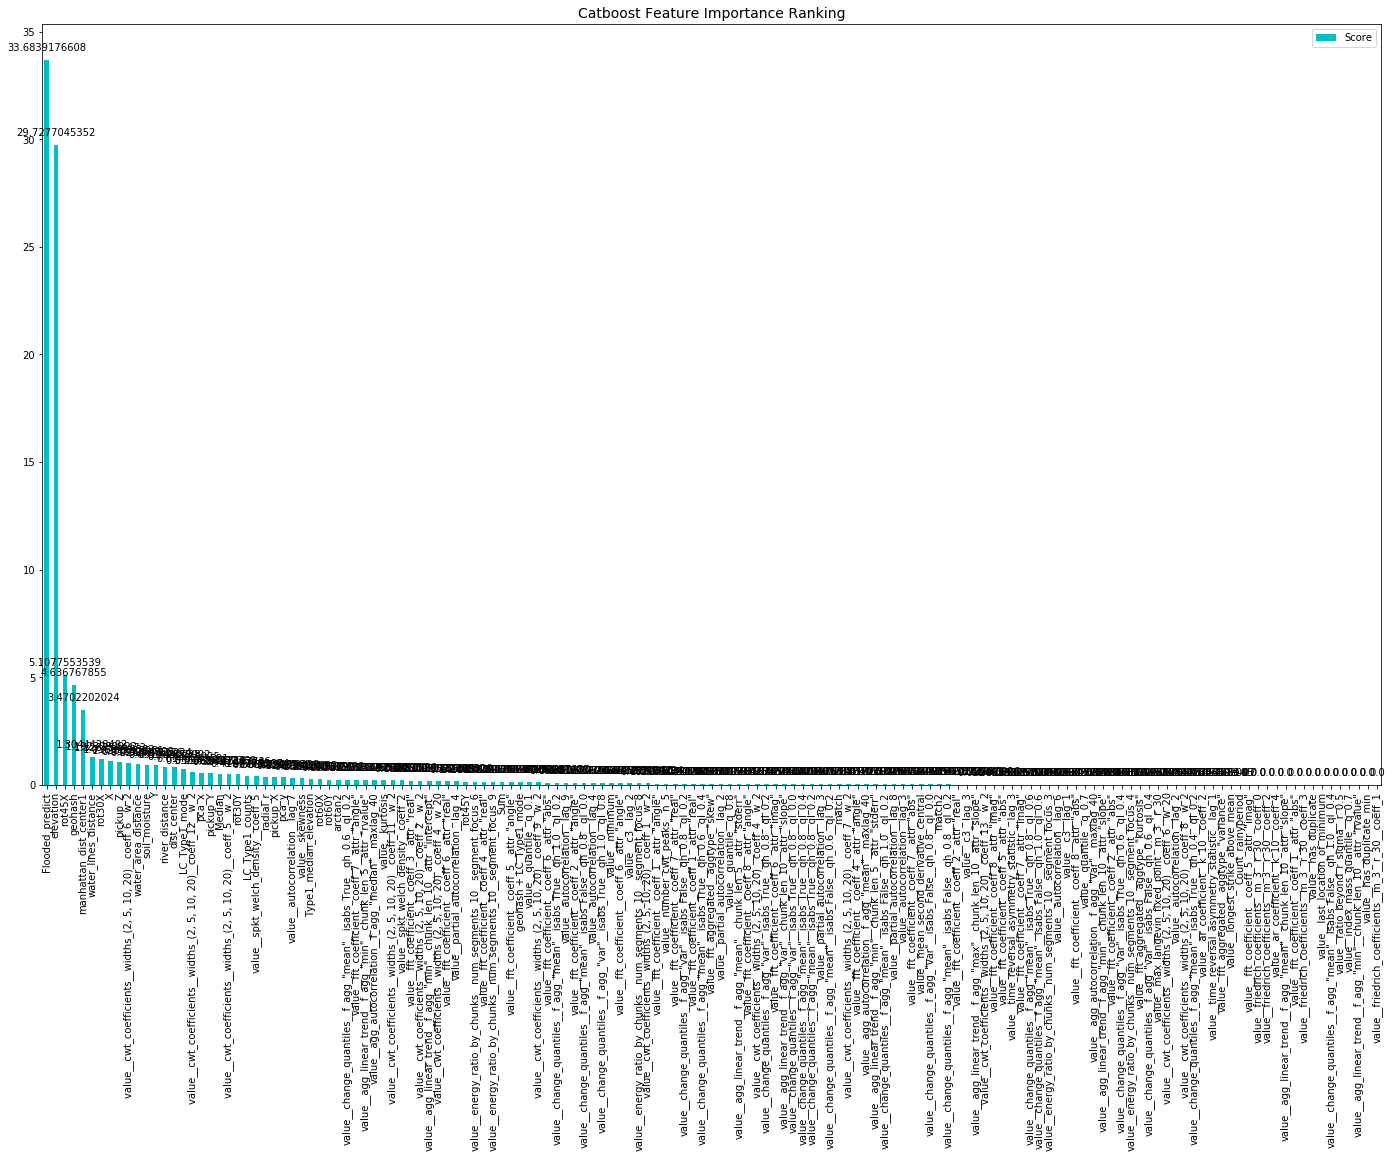

In [259]:
plt.rcParams["figure.figsize"] = (24,14)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(10)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [267]:
pd.set_option('display.max_colwidth', -1)
feature_score

Feature  \
146  Flooded_predict                                                        
2    elevation                                                              
127  rot45X                                                                 
139  geohash                                                                
144  manhattan_dist_center1                                                 
6    water_lines_distance                                                   
129  rot30X                                                                 
0    X                                                                      
135  pickup_Z                                                               
63   value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_2           
4    water_area_distance                                                    
7    soil_moisture                                                          
1    Y                                                                      
5    river_distance                                                         
138  dist_center                                                            
3    LC_Type1_mode                                                          
15   value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_2          
136  pca_x                                                                  
134  pickup_Y                                                               
122  Median                                                                 
67   value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_2           
130  rot30Y                                                                 
145  LC_Type1_counts                                                        
14   value__spkt_welch_density__coeff_5                                     
126  radial_r                                                               
133  pickup_X                                                               
137  pca_y                                                                  
26   value__autocorrelation__lag_7                                          
87   value__skewness                                                        
143  Type1_median_elevation                                                 
131  rot60X                                                                 
132  rot60Y                                                                 
125  arctan2                                                                
121  value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2      
85   value__fft_coefficient__coeff_7__attr_"angle"                          
109  value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"rvalue"       
42   value__agg_autocorrelation__f_agg_"median"__maxlag_40                  
86   value__kurtosis                                                        
70   value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_2          
41   value__spkt_welch_density__coeff_2                                     
25   value__fft_coefficient__coeff_3__attr_"real"                           
56   value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_2           
97   value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"   
110  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_20          
92   value__fft_coefficient__coeff_6__attr_"real"                           
13   value__partial_autocorrelation__lag_4                                  
128  rot45Y                                                                 
28   value__energy_ratio_by_chunks__num_segments_10__segment_focus_6        
83   value__fft_coefficient__coeff_4__attr_"real"                           
10   value__energy_ratio_by_chunks__num_segments_10__segment_focus_9        
123  Sum                                                                    
75   value__fft_coefficient__coeff_5__attr_"angle"            

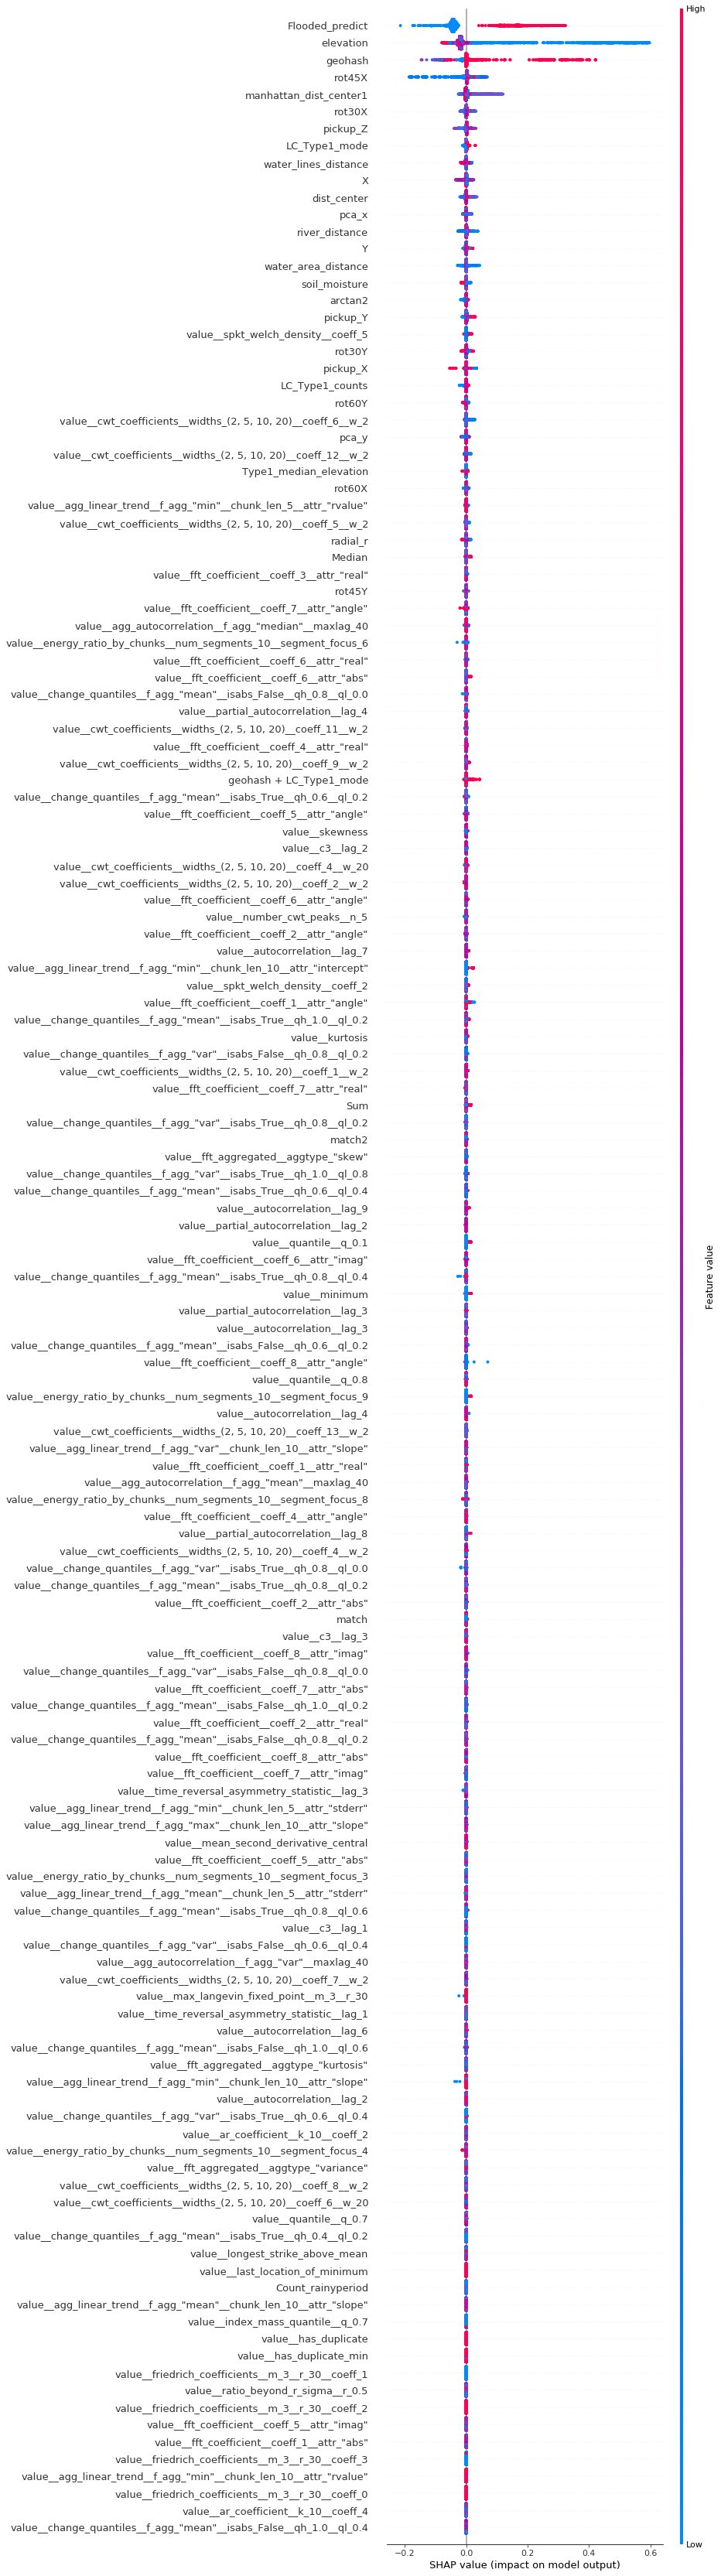

In [261]:
train_pool = Pool(target_encoded_train, y_trainfull)
import shap
shap_values = model.get_feature_importance(train_pool, fstr_type='ShapValues')
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, target_encoded_train, max_display=150, auto_size_plot=True)

In [81]:
#0.08873
import numpy as np
sample_submission = pd.read_csv("D:\Python\Zindi\Flood\SampleSubmission.csv", sep=",", index_col='Square_ID')
sample_submission['target_2019'] = model.predict(target_encoded_test)
sample_submission[sample_submission['target_2019'] < 0] = 0
sample_submission.to_csv('D:\Python\Zindi\Flood\samplesubm294_cat.csv')

In [175]:
#0.09984
predictions  = model.predict(target_encoded_test)
predictions = np.sqrt(predictions) - 2

predictions[predictions < 0] = 0
#predictions *= 0.9
predictions -= 0.3
#predictions *= 0.9
#predictions -= 0.25
#predictions[predictions < 0] = 0

subm = pd.read_csv("D:\Python\Zindi\Flood\SampleSubmission.csv", sep=",")
submission = pd.DataFrame({'Square_ID': subm.Square_ID, 'target_2019': predictions}) # Creating a submission file
submission.to_csv('D:\Python\Zindi\Flood\samplesubm261_cat.csv', index = False)

In [85]:
modelexp = CatBoostRegressor(
    eval_metric='RMSE',
    iterations=1600,  #9150 best 1600
    #learning_rate=0.035, 
    #depth = 7, 
    random_seed=42,
    loss_function='RMSE',
    #random_strength= 0.97,
    #bagging_temperature=0.97,
   #l2_leaf_reg= 2.9, 
    use_best_model = True, 
    #logging_level='Silent'
    task_type="GPU",
    #bootstrap_type = 'Poisson'
)

In [86]:
modelexp.fit(
      target_encoded_train, y_trainfull,
      eval_set=(target_encoded_train, y_trainfull), 
      #cat_features=categorical_features_indices,
      use_best_model=True,
      plot=False
)

0:	learn: 72.0785616	test: 72.0785616	best: 72.0785616 (0)	total: 37.9ms	remaining: 5m 46s
1:	learn: 70.5279101	test: 70.5279101	best: 70.5279101 (1)	total: 74.7ms	remaining: 5m 41s
2:	learn: 69.0231724	test: 69.0231724	best: 69.0231724 (2)	total: 115ms	remaining: 5m 49s
3:	learn: 67.5687650	test: 67.5687650	best: 67.5687650 (3)	total: 155ms	remaining: 5m 54s
4:	learn: 66.1750651	test: 66.1750651	best: 66.1750651 (4)	total: 188ms	remaining: 5m 43s
5:	learn: 64.8316565	test: 64.8316603	best: 64.8316603 (5)	total: 225ms	remaining: 5m 43s
6:	learn: 63.5424891	test: 63.5424852	best: 63.5424852 (6)	total: 263ms	remaining: 5m 43s
7:	learn: 62.3174199	test: 62.3174219	best: 62.3174219 (7)	total: 301ms	remaining: 5m 43s
8:	learn: 61.1362111	test: 61.1362091	best: 61.1362091 (8)	total: 339ms	remaining: 5m 44s
9:	learn: 59.9946874	test: 59.9946854	best: 59.9946854 (9)	total: 375ms	remaining: 5m 42s
10:	learn: 58.9126061	test: 58.9126040	best: 58.9126040 (10)	total: 410ms	remaining: 5m 40s
11:	le

90:	learn: 36.4650911	test: 36.4650894	best: 36.4650894 (90)	total: 3.25s	remaining: 5m 23s
91:	learn: 36.4396264	test: 36.4396264	best: 36.4396264 (91)	total: 3.28s	remaining: 5m 22s
92:	learn: 36.4131400	test: 36.4131400	best: 36.4131400 (92)	total: 3.31s	remaining: 5m 22s
93:	learn: 36.3940629	test: 36.3940629	best: 36.3940629 (93)	total: 3.35s	remaining: 5m 22s
94:	learn: 36.3758840	test: 36.3758857	best: 36.3758857 (94)	total: 3.38s	remaining: 5m 22s
95:	learn: 36.3496807	test: 36.3496773	best: 36.3496773 (95)	total: 3.41s	remaining: 5m 21s
96:	learn: 36.3239396	test: 36.3239396	best: 36.3239396 (96)	total: 3.45s	remaining: 5m 21s
97:	learn: 36.3000310	test: 36.3000310	best: 36.3000310 (97)	total: 3.48s	remaining: 5m 21s
98:	learn: 36.2769288	test: 36.2769288	best: 36.2769288 (98)	total: 3.52s	remaining: 5m 21s
99:	learn: 36.2521273	test: 36.2521273	best: 36.2521273 (99)	total: 3.55s	remaining: 5m 21s
100:	learn: 36.2329808	test: 36.2329825	best: 36.2329825 (100)	total: 3.59s	rema

178:	learn: 35.4776867	test: 35.4776867	best: 35.4776867 (178)	total: 6.25s	remaining: 5m 13s
179:	learn: 35.4703865	test: 35.4703865	best: 35.4703865 (179)	total: 6.29s	remaining: 5m 13s
180:	learn: 35.4544962	test: 35.4544962	best: 35.4544962 (180)	total: 6.32s	remaining: 5m 13s
181:	learn: 35.4487589	test: 35.4487572	best: 35.4487572 (181)	total: 6.36s	remaining: 5m 13s
182:	learn: 35.4432333	test: 35.4432333	best: 35.4432333 (182)	total: 6.39s	remaining: 5m 12s
183:	learn: 35.4360131	test: 35.4360148	best: 35.4360148 (183)	total: 6.42s	remaining: 5m 12s
184:	learn: 35.4271809	test: 35.4271792	best: 35.4271792 (184)	total: 6.46s	remaining: 5m 12s
185:	learn: 35.4126122	test: 35.4126139	best: 35.4126139 (185)	total: 6.49s	remaining: 5m 12s
186:	learn: 35.4081830	test: 35.4081813	best: 35.4081813 (186)	total: 6.53s	remaining: 5m 12s
187:	learn: 35.4004935	test: 35.4004935	best: 35.4004935 (187)	total: 6.56s	remaining: 5m 12s
188:	learn: 35.3979712	test: 35.3979712	best: 35.3979712 (18

266:	learn: 34.9679110	test: 34.9679128	best: 34.9679128 (266)	total: 9.2s	remaining: 5m 5s
267:	learn: 34.9614369	test: 34.9614351	best: 34.9614351 (267)	total: 9.23s	remaining: 5m 5s
268:	learn: 34.9607216	test: 34.9607198	best: 34.9607198 (268)	total: 9.26s	remaining: 5m 5s
269:	learn: 34.9552742	test: 34.9552724	best: 34.9552724 (269)	total: 9.29s	remaining: 5m 5s
270:	learn: 34.9447233	test: 34.9447233	best: 34.9447233 (270)	total: 9.33s	remaining: 5m 5s
271:	learn: 34.9387892	test: 34.9387874	best: 34.9387874 (271)	total: 9.36s	remaining: 5m 5s
272:	learn: 34.9367638	test: 34.9367620	best: 34.9367620 (272)	total: 9.39s	remaining: 5m 5s
273:	learn: 34.9250651	test: 34.9250651	best: 34.9250651 (273)	total: 9.43s	remaining: 5m 5s
274:	learn: 34.9211187	test: 34.9211169	best: 34.9211169 (274)	total: 9.46s	remaining: 5m 5s
275:	learn: 34.9171683	test: 34.9171683	best: 34.9171683 (275)	total: 9.49s	remaining: 5m 5s
276:	learn: 34.9103010	test: 34.9103010	best: 34.9103010 (276)	total: 9

355:	learn: 34.5019197	test: 34.5019197	best: 34.5019197 (355)	total: 12.2s	remaining: 5m 1s
356:	learn: 34.5000244	test: 34.5000244	best: 34.5000244 (356)	total: 12.2s	remaining: 5m 1s
357:	learn: 34.4977209	test: 34.4977209	best: 34.4977209 (357)	total: 12.3s	remaining: 5m 1s
358:	learn: 34.4972823	test: 34.4972788	best: 34.4972788 (358)	total: 12.3s	remaining: 5m 1s
359:	learn: 34.4972304	test: 34.4972322	best: 34.4972322 (359)	total: 12.3s	remaining: 5m 1s
360:	learn: 34.4947764	test: 34.4947746	best: 34.4947746 (360)	total: 12.4s	remaining: 5m 1s
361:	learn: 34.4947191	test: 34.4947155	best: 34.4947155 (361)	total: 12.4s	remaining: 5m
362:	learn: 34.4925942	test: 34.4925978	best: 34.4925978 (362)	total: 12.4s	remaining: 5m
363:	learn: 34.4853128	test: 34.4853128	best: 34.4853128 (363)	total: 12.5s	remaining: 5m
364:	learn: 34.4852860	test: 34.4852842	best: 34.4852842 (364)	total: 12.5s	remaining: 5m
365:	learn: 34.4718489	test: 34.4718507	best: 34.4718507 (365)	total: 12.5s	remain

444:	learn: 34.1786509	test: 34.1786491	best: 34.1786491 (444)	total: 15.2s	remaining: 4m 57s
445:	learn: 34.1716948	test: 34.1716930	best: 34.1716930 (445)	total: 15.2s	remaining: 4m 57s
446:	learn: 34.1693402	test: 34.1693420	best: 34.1693420 (446)	total: 15.3s	remaining: 4m 57s
447:	learn: 34.1692643	test: 34.1692643	best: 34.1692643 (447)	total: 15.3s	remaining: 4m 57s
448:	learn: 34.1692535	test: 34.1692517	best: 34.1692517 (448)	total: 15.3s	remaining: 4m 57s
449:	learn: 34.1692390	test: 34.1692390	best: 34.1692390 (449)	total: 15.4s	remaining: 4m 57s
450:	learn: 34.1584814	test: 34.1584796	best: 34.1584796 (450)	total: 15.4s	remaining: 4m 56s
451:	learn: 34.1584091	test: 34.1584109	best: 34.1584109 (451)	total: 15.4s	remaining: 4m 56s
452:	learn: 34.1555529	test: 34.1555529	best: 34.1555529 (452)	total: 15.5s	remaining: 4m 56s
453:	learn: 34.1478579	test: 34.1478597	best: 34.1478597 (453)	total: 15.5s	remaining: 4m 56s
454:	learn: 34.1477765	test: 34.1477747	best: 34.1477747 (45

532:	learn: 33.9318006	test: 33.9317987	best: 33.9317987 (532)	total: 18.2s	remaining: 4m 53s
533:	learn: 33.9264519	test: 33.9264537	best: 33.9264537 (533)	total: 18.2s	remaining: 4m 53s
534:	learn: 33.9263918	test: 33.9263918	best: 33.9263918 (534)	total: 18.2s	remaining: 4m 53s
535:	learn: 33.9263500	test: 33.9263481	best: 33.9263481 (535)	total: 18.3s	remaining: 4m 53s
536:	learn: 33.9237290	test: 33.9237290	best: 33.9237290 (536)	total: 18.3s	remaining: 4m 53s
537:	learn: 33.9210532	test: 33.9210532	best: 33.9210532 (537)	total: 18.3s	remaining: 4m 53s
538:	learn: 33.9210350	test: 33.9210368	best: 33.9210368 (538)	total: 18.4s	remaining: 4m 53s
539:	learn: 33.9207256	test: 33.9207237	best: 33.9207237 (539)	total: 18.4s	remaining: 4m 53s
540:	learn: 33.9182771	test: 33.9182753	best: 33.9182753 (540)	total: 18.4s	remaining: 4m 53s
541:	learn: 33.9179130	test: 33.9179094	best: 33.9179094 (541)	total: 18.5s	remaining: 4m 53s
542:	learn: 33.9175398	test: 33.9175380	best: 33.9175380 (54

620:	learn: 33.7757108	test: 33.7757108	best: 33.7757108 (620)	total: 21.1s	remaining: 4m 49s
621:	learn: 33.7757072	test: 33.7757090	best: 33.7757090 (621)	total: 21.1s	remaining: 4m 49s
622:	learn: 33.7711657	test: 33.7711675	best: 33.7711675 (622)	total: 21.1s	remaining: 4m 49s
623:	learn: 33.7600746	test: 33.7600746	best: 33.7600746 (623)	total: 21.2s	remaining: 4m 49s
624:	learn: 33.7596173	test: 33.7596173	best: 33.7596173 (624)	total: 21.2s	remaining: 4m 48s
625:	learn: 33.7518010	test: 33.7518010	best: 33.7518010 (625)	total: 21.2s	remaining: 4m 48s
626:	learn: 33.7482425	test: 33.7482425	best: 33.7482425 (626)	total: 21.3s	remaining: 4m 48s
627:	learn: 33.7451393	test: 33.7451393	best: 33.7451393 (627)	total: 21.3s	remaining: 4m 48s
628:	learn: 33.7388880	test: 33.7388899	best: 33.7388899 (628)	total: 21.3s	remaining: 4m 48s
629:	learn: 33.7361665	test: 33.7361683	best: 33.7361683 (629)	total: 21.3s	remaining: 4m 48s
630:	learn: 33.7314549	test: 33.7314568	best: 33.7314568 (63

708:	learn: 33.5456282	test: 33.5456282	best: 33.5456282 (708)	total: 24s	remaining: 4m 45s
709:	learn: 33.5334792	test: 33.5334773	best: 33.5334773 (709)	total: 24s	remaining: 4m 45s
710:	learn: 33.5310154	test: 33.5310154	best: 33.5310154 (710)	total: 24s	remaining: 4m 45s
711:	learn: 33.5225028	test: 33.5225028	best: 33.5225028 (711)	total: 24.1s	remaining: 4m 45s
712:	learn: 33.5224642	test: 33.5224660	best: 33.5224660 (712)	total: 24.1s	remaining: 4m 45s
713:	learn: 33.5224421	test: 33.5224402	best: 33.5224402 (713)	total: 24.1s	remaining: 4m 45s
714:	learn: 33.5207603	test: 33.5207621	best: 33.5207621 (714)	total: 24.2s	remaining: 4m 44s
715:	learn: 33.5207253	test: 33.5207271	best: 33.5207271 (715)	total: 24.2s	remaining: 4m 44s
716:	learn: 33.5137302	test: 33.5137302	best: 33.5137302 (716)	total: 24.2s	remaining: 4m 44s
717:	learn: 33.5137063	test: 33.5137063	best: 33.5137063 (717)	total: 24.3s	remaining: 4m 44s
718:	learn: 33.5112226	test: 33.5112207	best: 33.5112207 (718)	tot

796:	learn: 33.3913374	test: 33.3913374	best: 33.3913374 (796)	total: 26.9s	remaining: 4m 41s
797:	learn: 33.3913282	test: 33.3913282	best: 33.3913282 (797)	total: 26.9s	remaining: 4m 41s
798:	learn: 33.3913263	test: 33.3913282	best: 33.3913282 (797)	total: 26.9s	remaining: 4m 41s
799:	learn: 33.3913263	test: 33.3913263	best: 33.3913263 (799)	total: 27s	remaining: 4m 41s
800:	learn: 33.3913245	test: 33.3913263	best: 33.3913263 (799)	total: 27s	remaining: 4m 41s
801:	learn: 33.3901816	test: 33.3901816	best: 33.3901816 (801)	total: 27s	remaining: 4m 41s
802:	learn: 33.3901761	test: 33.3901761	best: 33.3901761 (802)	total: 27s	remaining: 4m 41s
803:	learn: 33.3901668	test: 33.3901668	best: 33.3901668 (803)	total: 27.1s	remaining: 4m 41s
804:	learn: 33.3893772	test: 33.3893753	best: 33.3893753 (804)	total: 27.1s	remaining: 4m 41s
805:	learn: 33.3871931	test: 33.3871949	best: 33.3871949 (805)	total: 27.1s	remaining: 4m 41s
806:	learn: 33.3871746	test: 33.3871727	best: 33.3871727 (806)	total

884:	learn: 33.2467103	test: 33.2467103	best: 33.2467103 (884)	total: 29.7s	remaining: 4m 37s
885:	learn: 33.2446562	test: 33.2446543	best: 33.2446543 (885)	total: 29.7s	remaining: 4m 37s
886:	learn: 33.2446506	test: 33.2446506	best: 33.2446506 (886)	total: 29.8s	remaining: 4m 37s
887:	learn: 33.2446432	test: 33.2446413	best: 33.2446413 (887)	total: 29.8s	remaining: 4m 37s
888:	learn: 33.2446283	test: 33.2446264	best: 33.2446264 (888)	total: 29.9s	remaining: 4m 37s
889:	learn: 33.2419517	test: 33.2419536	best: 33.2419536 (889)	total: 29.9s	remaining: 4m 37s
890:	learn: 33.2335473	test: 33.2335454	best: 33.2335454 (890)	total: 29.9s	remaining: 4m 37s
891:	learn: 33.2335417	test: 33.2335454	best: 33.2335454 (890)	total: 30s	remaining: 4m 37s
892:	learn: 33.2307880	test: 33.2307899	best: 33.2307899 (892)	total: 30s	remaining: 4m 37s
893:	learn: 33.2307899	test: 33.2307880	best: 33.2307880 (893)	total: 30s	remaining: 4m 37s
894:	learn: 33.2307843	test: 33.2307862	best: 33.2307862 (894)	tot

972:	learn: 33.0970692	test: 33.0970674	best: 33.0970674 (971)	total: 32.7s	remaining: 4m 34s
973:	learn: 33.0970692	test: 33.0970655	best: 33.0970655 (973)	total: 32.7s	remaining: 4m 34s
974:	learn: 33.0939852	test: 33.0939871	best: 33.0939871 (974)	total: 32.7s	remaining: 4m 34s
975:	learn: 33.0914774	test: 33.0914793	best: 33.0914793 (975)	total: 32.8s	remaining: 4m 34s
976:	learn: 33.0891598	test: 33.0891580	best: 33.0891580 (976)	total: 32.8s	remaining: 4m 34s
977:	learn: 33.0891524	test: 33.0891542	best: 33.0891542 (977)	total: 32.9s	remaining: 4m 34s
978:	learn: 33.0876930	test: 33.0876893	best: 33.0876893 (978)	total: 32.9s	remaining: 4m 34s
979:	learn: 33.0831859	test: 33.0831822	best: 33.0831822 (979)	total: 32.9s	remaining: 4m 34s
980:	learn: 33.0813213	test: 33.0813213	best: 33.0813213 (980)	total: 33s	remaining: 4m 34s
981:	learn: 33.0779894	test: 33.0779912	best: 33.0779912 (981)	total: 33s	remaining: 4m 34s
982:	learn: 33.0740821	test: 33.0740802	best: 33.0740802 (982)	t

1059:	learn: 33.0078045	test: 33.0078045	best: 33.0078045 (1059)	total: 35.5s	remaining: 4m 30s
1060:	learn: 33.0045232	test: 33.0045232	best: 33.0045232 (1060)	total: 35.5s	remaining: 4m 30s
1061:	learn: 33.0043772	test: 33.0043754	best: 33.0043754 (1061)	total: 35.5s	remaining: 4m 30s
1062:	learn: 33.0029142	test: 33.0029142	best: 33.0029142 (1062)	total: 35.6s	remaining: 4m 30s
1063:	learn: 33.0029104	test: 33.0029123	best: 33.0029123 (1063)	total: 35.6s	remaining: 4m 30s
1064:	learn: 33.0029104	test: 33.0029123	best: 33.0029123 (1063)	total: 35.6s	remaining: 4m 30s
1065:	learn: 33.0029104	test: 33.0029086	best: 33.0029086 (1065)	total: 35.7s	remaining: 4m 30s
1066:	learn: 33.0006876	test: 33.0006876	best: 33.0006876 (1066)	total: 35.7s	remaining: 4m 30s
1067:	learn: 32.9932454	test: 32.9932454	best: 32.9932454 (1067)	total: 35.7s	remaining: 4m 30s
1068:	learn: 32.9932323	test: 32.9932323	best: 32.9932323 (1068)	total: 35.8s	remaining: 4m 30s
1069:	learn: 32.9903782	test: 32.9903763

1145:	learn: 32.9148442	test: 32.9148442	best: 32.9148442 (1145)	total: 38.3s	remaining: 4m 27s
1146:	learn: 32.9148442	test: 32.9148442	best: 32.9148442 (1145)	total: 38.3s	remaining: 4m 27s
1147:	learn: 32.9119626	test: 32.9119607	best: 32.9119607 (1147)	total: 38.3s	remaining: 4m 27s
1148:	learn: 32.9119589	test: 32.9119607	best: 32.9119607 (1147)	total: 38.4s	remaining: 4m 27s
1149:	learn: 32.9119607	test: 32.9119607	best: 32.9119607 (1147)	total: 38.4s	remaining: 4m 27s
1150:	learn: 32.9075984	test: 32.9075965	best: 32.9075965 (1150)	total: 38.4s	remaining: 4m 26s
1151:	learn: 32.9075965	test: 32.9075984	best: 32.9075965 (1150)	total: 38.5s	remaining: 4m 26s
1152:	learn: 32.9075984	test: 32.9075984	best: 32.9075965 (1150)	total: 38.5s	remaining: 4m 26s
1153:	learn: 32.9075984	test: 32.9075965	best: 32.9075965 (1150)	total: 38.5s	remaining: 4m 26s
1154:	learn: 32.9071012	test: 32.9071012	best: 32.9071012 (1154)	total: 38.5s	remaining: 4m 26s
1155:	learn: 32.9070899	test: 32.9070899

1231:	learn: 32.8208606	test: 32.8208625	best: 32.8208606 (1230)	total: 41s	remaining: 4m 23s
1232:	learn: 32.8208606	test: 32.8208625	best: 32.8208606 (1230)	total: 41s	remaining: 4m 23s
1233:	learn: 32.8205427	test: 32.8205427	best: 32.8205427 (1233)	total: 41s	remaining: 4m 23s
1234:	learn: 32.8205427	test: 32.8205445	best: 32.8205427 (1233)	total: 41.1s	remaining: 4m 23s
1235:	learn: 32.8205427	test: 32.8205445	best: 32.8205427 (1233)	total: 41.1s	remaining: 4m 23s
1236:	learn: 32.8194364	test: 32.8194364	best: 32.8194364 (1236)	total: 41.1s	remaining: 4m 23s
1237:	learn: 32.8190752	test: 32.8190771	best: 32.8190771 (1237)	total: 41.2s	remaining: 4m 23s
1238:	learn: 32.8148303	test: 32.8148285	best: 32.8148285 (1238)	total: 41.2s	remaining: 4m 23s
1239:	learn: 32.8130577	test: 32.8130596	best: 32.8130596 (1239)	total: 41.2s	remaining: 4m 23s
1240:	learn: 32.8130577	test: 32.8130596	best: 32.8130596 (1239)	total: 41.3s	remaining: 4m 22s
1241:	learn: 32.8069037	test: 32.8069056	best:

1317:	learn: 32.6931433	test: 32.6931452	best: 32.6931452 (1317)	total: 43.7s	remaining: 4m 19s
1318:	learn: 32.6909485	test: 32.6909485	best: 32.6909485 (1318)	total: 43.8s	remaining: 4m 19s
1319:	learn: 32.6879320	test: 32.6879320	best: 32.6879320 (1319)	total: 43.8s	remaining: 4m 19s
1320:	learn: 32.6879282	test: 32.6879282	best: 32.6879282 (1320)	total: 43.8s	remaining: 4m 19s
1321:	learn: 32.6879282	test: 32.6879282	best: 32.6879282 (1320)	total: 43.9s	remaining: 4m 19s
1322:	learn: 32.6879263	test: 32.6879263	best: 32.6879263 (1322)	total: 43.9s	remaining: 4m 19s
1323:	learn: 32.6786084	test: 32.6786084	best: 32.6786084 (1323)	total: 43.9s	remaining: 4m 19s
1324:	learn: 32.6786065	test: 32.6786046	best: 32.6786046 (1324)	total: 44s	remaining: 4m 19s
1325:	learn: 32.6786046	test: 32.6786046	best: 32.6786046 (1324)	total: 44s	remaining: 4m 19s
1326:	learn: 32.6750842	test: 32.6750823	best: 32.6750823 (1326)	total: 44s	remaining: 4m 19s
1327:	learn: 32.6750805	test: 32.6750805	best:

1403:	learn: 32.5453378	test: 32.5453378	best: 32.5453378 (1403)	total: 46.6s	remaining: 4m 16s
1404:	learn: 32.5453378	test: 32.5453359	best: 32.5453359 (1404)	total: 46.6s	remaining: 4m 16s
1405:	learn: 32.5453245	test: 32.5453245	best: 32.5453245 (1405)	total: 46.6s	remaining: 4m 16s
1406:	learn: 32.5453074	test: 32.5453074	best: 32.5453074 (1406)	total: 46.7s	remaining: 4m 16s
1407:	learn: 32.5390268	test: 32.5390287	best: 32.5390287 (1407)	total: 46.7s	remaining: 4m 16s
1408:	learn: 32.5349391	test: 32.5349391	best: 32.5349391 (1408)	total: 46.7s	remaining: 4m 16s
1409:	learn: 32.5349372	test: 32.5349391	best: 32.5349391 (1408)	total: 46.8s	remaining: 4m 16s
1410:	learn: 32.5349182	test: 32.5349182	best: 32.5349182 (1410)	total: 46.8s	remaining: 4m 16s
1411:	learn: 32.5338554	test: 32.5338554	best: 32.5338554 (1411)	total: 46.8s	remaining: 4m 16s
1412:	learn: 32.5338554	test: 32.5338554	best: 32.5338554 (1411)	total: 46.9s	remaining: 4m 16s
1413:	learn: 32.5338554	test: 32.5338573

1489:	learn: 32.4258977	test: 32.4258977	best: 32.4258977 (1489)	total: 49.4s	remaining: 4m 13s
1490:	learn: 32.4253759	test: 32.4253759	best: 32.4253759 (1490)	total: 49.4s	remaining: 4m 13s
1491:	learn: 32.4178454	test: 32.4178454	best: 32.4178454 (1491)	total: 49.4s	remaining: 4m 13s
1492:	learn: 32.4178435	test: 32.4178435	best: 32.4178435 (1492)	total: 49.5s	remaining: 4m 13s
1493:	learn: 32.4178169	test: 32.4178150	best: 32.4178150 (1493)	total: 49.5s	remaining: 4m 13s
1494:	learn: 32.4178150	test: 32.4178150	best: 32.4178150 (1493)	total: 49.5s	remaining: 4m 13s
1495:	learn: 32.4178150	test: 32.4178150	best: 32.4178150 (1493)	total: 49.6s	remaining: 4m 13s
1496:	learn: 32.4106600	test: 32.4106600	best: 32.4106600 (1496)	total: 49.6s	remaining: 4m 13s
1497:	learn: 32.4103628	test: 32.4103628	best: 32.4103628 (1497)	total: 49.6s	remaining: 4m 13s
1498:	learn: 32.4103628	test: 32.4103628	best: 32.4103628 (1497)	total: 49.7s	remaining: 4m 13s
1499:	learn: 32.4103628	test: 32.4103609

1575:	learn: 32.2939876	test: 32.2939895	best: 32.2939876 (1574)	total: 52.2s	remaining: 4m 10s
1576:	learn: 32.2939876	test: 32.2939876	best: 32.2939876 (1574)	total: 52.2s	remaining: 4m 10s
1577:	learn: 32.2929092	test: 32.2929073	best: 32.2929073 (1577)	total: 52.3s	remaining: 4m 10s
1578:	learn: 32.2928863	test: 32.2928824	best: 32.2928824 (1578)	total: 52.3s	remaining: 4m 10s
1579:	learn: 32.2928844	test: 32.2928844	best: 32.2928824 (1578)	total: 52.3s	remaining: 4m 10s
1580:	learn: 32.2866350	test: 32.2866331	best: 32.2866331 (1580)	total: 52.4s	remaining: 4m 10s
1581:	learn: 32.2797455	test: 32.2797455	best: 32.2797455 (1581)	total: 52.4s	remaining: 4m 10s
1582:	learn: 32.2792367	test: 32.2792367	best: 32.2792367 (1582)	total: 52.4s	remaining: 4m 10s
1583:	learn: 32.2761414	test: 32.2761395	best: 32.2761395 (1583)	total: 52.5s	remaining: 4m 10s
1584:	learn: 32.2761395	test: 32.2761395	best: 32.2761395 (1583)	total: 52.5s	remaining: 4m 10s
1585:	learn: 32.2761204	test: 32.2761204

1662:	learn: 32.2024144	test: 32.2024106	best: 32.2024106 (1662)	total: 55s	remaining: 4m 7s
1663:	learn: 32.2024106	test: 32.2024125	best: 32.2024106 (1662)	total: 55s	remaining: 4m 7s
1664:	learn: 32.2023971	test: 32.2023990	best: 32.2023990 (1664)	total: 55s	remaining: 4m 7s
1665:	learn: 32.2012313	test: 32.2012313	best: 32.2012313 (1665)	total: 55.1s	remaining: 4m 7s
1666:	learn: 32.2012294	test: 32.2012294	best: 32.2012294 (1666)	total: 55.1s	remaining: 4m 7s
1667:	learn: 32.1978543	test: 32.1978562	best: 32.1978562 (1667)	total: 55.1s	remaining: 4m 7s
1668:	learn: 32.1978505	test: 32.1978524	best: 32.1978524 (1668)	total: 55.1s	remaining: 4m 7s
1669:	learn: 32.1975992	test: 32.1975992	best: 32.1975992 (1669)	total: 55.2s	remaining: 4m 7s
1670:	learn: 32.1975973	test: 32.1975973	best: 32.1975973 (1670)	total: 55.2s	remaining: 4m 7s
1671:	learn: 32.1975839	test: 32.1975839	best: 32.1975839 (1671)	total: 55.2s	remaining: 4m 7s
1672:	learn: 32.1975839	test: 32.1975820	best: 32.197582

1749:	learn: 32.1121145	test: 32.1121155	best: 32.1121155 (1749)	total: 57.9s	remaining: 4m 4s
1750:	learn: 32.1118568	test: 32.1118568	best: 32.1118568 (1750)	total: 57.9s	remaining: 4m 4s
1751:	learn: 32.1116251	test: 32.1116251	best: 32.1116251 (1751)	total: 58s	remaining: 4m 4s
1752:	learn: 32.1116145	test: 32.1116136	best: 32.1116136 (1752)	total: 58s	remaining: 4m 4s
1753:	learn: 32.1116136	test: 32.1116136	best: 32.1116136 (1752)	total: 58s	remaining: 4m 4s
1754:	learn: 32.1024237	test: 32.1024227	best: 32.1024227 (1754)	total: 58s	remaining: 4m 4s
1755:	learn: 32.1024218	test: 32.1024189	best: 32.1024189 (1755)	total: 58.1s	remaining: 4m 4s
1756:	learn: 32.0959968	test: 32.0959987	best: 32.0959987 (1756)	total: 58.1s	remaining: 4m 4s
1757:	learn: 32.0959968	test: 32.0959958	best: 32.0959958 (1757)	total: 58.1s	remaining: 4m 4s
1758:	learn: 32.0959929	test: 32.0959929	best: 32.0959929 (1758)	total: 58.2s	remaining: 4m 4s
1759:	learn: 32.0958958	test: 32.0958958	best: 32.0958958 

1836:	learn: 32.0448763	test: 32.0448773	best: 32.0448773 (1836)	total: 1m	remaining: 4m
1837:	learn: 32.0442838	test: 32.0442847	best: 32.0442847 (1837)	total: 1m	remaining: 4m
1838:	learn: 32.0442818	test: 32.0442828	best: 32.0442828 (1838)	total: 1m	remaining: 4m
1839:	learn: 32.0385940	test: 32.0385930	best: 32.0385930 (1839)	total: 1m	remaining: 4m
1840:	learn: 32.0385776	test: 32.0385786	best: 32.0385786 (1840)	total: 1m	remaining: 4m
1841:	learn: 32.0385786	test: 32.0385786	best: 32.0385786 (1840)	total: 1m	remaining: 4m
1842:	learn: 32.0385786	test: 32.0385795	best: 32.0385786 (1840)	total: 1m	remaining: 4m
1843:	learn: 32.0378230	test: 32.0378230	best: 32.0378230 (1843)	total: 1m	remaining: 4m
1844:	learn: 32.0378259	test: 32.0378250	best: 32.0378230 (1843)	total: 1m	remaining: 4m
1845:	learn: 32.0378250	test: 32.0378230	best: 32.0378230 (1843)	total: 1m	remaining: 4m
1846:	learn: 32.0376515	test: 32.0376506	best: 32.0376506 (1846)	total: 1m	remaining: 4m
1847:	learn: 32.03397

1923:	learn: 31.9505088	test: 31.9505088	best: 31.9505088 (1923)	total: 1m 3s	remaining: 3m 57s
1924:	learn: 31.9505068	test: 31.9505059	best: 31.9505059 (1924)	total: 1m 3s	remaining: 3m 57s
1925:	learn: 31.9504943	test: 31.9504923	best: 31.9504923 (1925)	total: 1m 3s	remaining: 3m 57s
1926:	learn: 31.9503058	test: 31.9503068	best: 31.9503068 (1926)	total: 1m 3s	remaining: 3m 57s
1927:	learn: 31.9480958	test: 31.9480958	best: 31.9480958 (1927)	total: 1m 3s	remaining: 3m 57s
1928:	learn: 31.9480929	test: 31.9480949	best: 31.9480949 (1928)	total: 1m 3s	remaining: 3m 57s
1929:	learn: 31.9480929	test: 31.9480929	best: 31.9480929 (1929)	total: 1m 3s	remaining: 3m 57s
1930:	learn: 31.9480920	test: 31.9480920	best: 31.9480920 (1930)	total: 1m 3s	remaining: 3m 57s
1931:	learn: 31.9451386	test: 31.9451386	best: 31.9451386 (1931)	total: 1m 3s	remaining: 3m 57s
1932:	learn: 31.9431167	test: 31.9431167	best: 31.9431167 (1932)	total: 1m 3s	remaining: 3m 57s
1933:	learn: 31.9398594	test: 31.9398594

2009:	learn: 31.8662117	test: 31.8662117	best: 31.8662117 (2009)	total: 1m 6s	remaining: 3m 54s
2010:	learn: 31.8662098	test: 31.8662107	best: 31.8662107 (2010)	total: 1m 6s	remaining: 3m 54s
2011:	learn: 31.8637614	test: 31.8637595	best: 31.8637595 (2011)	total: 1m 6s	remaining: 3m 54s
2012:	learn: 31.8612750	test: 31.8612741	best: 31.8612741 (2012)	total: 1m 6s	remaining: 3m 54s
2013:	learn: 31.8612111	test: 31.8612101	best: 31.8612101 (2013)	total: 1m 6s	remaining: 3m 54s
2014:	learn: 31.8611965	test: 31.8611985	best: 31.8611985 (2014)	total: 1m 6s	remaining: 3m 54s
2015:	learn: 31.8585287	test: 31.8585287	best: 31.8585287 (2015)	total: 1m 6s	remaining: 3m 54s
2016:	learn: 31.8585278	test: 31.8585268	best: 31.8585268 (2016)	total: 1m 6s	remaining: 3m 54s
2017:	learn: 31.8549177	test: 31.8549167	best: 31.8549167 (2017)	total: 1m 6s	remaining: 3m 54s
2018:	learn: 31.8549158	test: 31.8549158	best: 31.8549158 (2018)	total: 1m 6s	remaining: 3m 54s
2019:	learn: 31.8546454	test: 31.8546473

2095:	learn: 31.7766043	test: 31.7766033	best: 31.7766033 (2095)	total: 1m 8s	remaining: 3m 51s
2096:	learn: 31.7752081	test: 31.7752081	best: 31.7752081 (2096)	total: 1m 8s	remaining: 3m 51s
2097:	learn: 31.7750905	test: 31.7750915	best: 31.7750915 (2097)	total: 1m 8s	remaining: 3m 51s
2098:	learn: 31.7750905	test: 31.7750895	best: 31.7750895 (2098)	total: 1m 8s	remaining: 3m 51s
2099:	learn: 31.7750856	test: 31.7750856	best: 31.7750856 (2099)	total: 1m 9s	remaining: 3m 51s
2100:	learn: 31.7750847	test: 31.7750856	best: 31.7750856 (2099)	total: 1m 9s	remaining: 3m 51s
2101:	learn: 31.7750847	test: 31.7750856	best: 31.7750856 (2099)	total: 1m 9s	remaining: 3m 51s
2102:	learn: 31.7710346	test: 31.7710356	best: 31.7710356 (2102)	total: 1m 9s	remaining: 3m 51s
2103:	learn: 31.7710356	test: 31.7710337	best: 31.7710337 (2103)	total: 1m 9s	remaining: 3m 51s
2104:	learn: 31.7710337	test: 31.7710327	best: 31.7710327 (2104)	total: 1m 9s	remaining: 3m 51s
2105:	learn: 31.7710356	test: 31.7710327

2180:	learn: 31.6878502	test: 31.6878522	best: 31.6878522 (2180)	total: 1m 11s	remaining: 3m 49s
2181:	learn: 31.6878376	test: 31.6878356	best: 31.6878356 (2181)	total: 1m 11s	remaining: 3m 49s
2182:	learn: 31.6834724	test: 31.6834743	best: 31.6834743 (2182)	total: 1m 11s	remaining: 3m 49s
2183:	learn: 31.6819230	test: 31.6819220	best: 31.6819220 (2183)	total: 1m 11s	remaining: 3m 49s
2184:	learn: 31.6819093	test: 31.6819083	best: 31.6819083 (2184)	total: 1m 11s	remaining: 3m 49s
2185:	learn: 31.6790286	test: 31.6790276	best: 31.6790276 (2185)	total: 1m 11s	remaining: 3m 48s
2186:	learn: 31.6739038	test: 31.6739048	best: 31.6739048 (2186)	total: 1m 11s	remaining: 3m 48s
2187:	learn: 31.6738912	test: 31.6738931	best: 31.6738931 (2187)	total: 1m 11s	remaining: 3m 48s
2188:	learn: 31.6737791	test: 31.6737781	best: 31.6737781 (2188)	total: 1m 11s	remaining: 3m 48s
2189:	learn: 31.6725236	test: 31.6725245	best: 31.6725245 (2189)	total: 1m 12s	remaining: 3m 48s
2190:	learn: 31.6708684	test: 

2265:	learn: 31.5859980	test: 31.5859970	best: 31.5859970 (2265)	total: 1m 14s	remaining: 3m 46s
2266:	learn: 31.5837821	test: 31.5837801	best: 31.5837801 (2266)	total: 1m 14s	remaining: 3m 46s
2267:	learn: 31.5832620	test: 31.5832610	best: 31.5832610 (2267)	total: 1m 14s	remaining: 3m 46s
2268:	learn: 31.5832561	test: 31.5832561	best: 31.5832561 (2268)	total: 1m 14s	remaining: 3m 46s
2269:	learn: 31.5832522	test: 31.5832522	best: 31.5832522 (2269)	total: 1m 14s	remaining: 3m 46s
2270:	learn: 31.5832483	test: 31.5832493	best: 31.5832493 (2270)	total: 1m 14s	remaining: 3m 46s
2271:	learn: 31.5773268	test: 31.5773278	best: 31.5773278 (2271)	total: 1m 14s	remaining: 3m 46s
2272:	learn: 31.5772623	test: 31.5772613	best: 31.5772613 (2272)	total: 1m 14s	remaining: 3m 46s
2273:	learn: 31.5772574	test: 31.5772574	best: 31.5772574 (2273)	total: 1m 14s	remaining: 3m 46s
2274:	learn: 31.5772584	test: 31.5772555	best: 31.5772555 (2274)	total: 1m 14s	remaining: 3m 46s
2275:	learn: 31.5772467	test: 

2350:	learn: 31.5020800	test: 31.5020800	best: 31.5020800 (2350)	total: 1m 17s	remaining: 3m 43s
2351:	learn: 31.4985457	test: 31.4985457	best: 31.4985457 (2351)	total: 1m 17s	remaining: 3m 43s
2352:	learn: 31.4942876	test: 31.4942876	best: 31.4942876 (2352)	total: 1m 17s	remaining: 3m 43s
2353:	learn: 31.4942847	test: 31.4942856	best: 31.4942856 (2353)	total: 1m 17s	remaining: 3m 43s
2354:	learn: 31.4942827	test: 31.4942847	best: 31.4942847 (2354)	total: 1m 17s	remaining: 3m 43s
2355:	learn: 31.4942837	test: 31.4942827	best: 31.4942827 (2355)	total: 1m 17s	remaining: 3m 43s
2356:	learn: 31.4942817	test: 31.4942817	best: 31.4942817 (2356)	total: 1m 17s	remaining: 3m 43s
2357:	learn: 31.4942807	test: 31.4942807	best: 31.4942807 (2357)	total: 1m 17s	remaining: 3m 43s
2358:	learn: 31.4891161	test: 31.4891181	best: 31.4891181 (2358)	total: 1m 17s	remaining: 3m 43s
2359:	learn: 31.4891151	test: 31.4891161	best: 31.4891161 (2359)	total: 1m 17s	remaining: 3m 43s
2360:	learn: 31.4891161	test: 

2435:	learn: 31.4089932	test: 31.4089932	best: 31.4089932 (2435)	total: 1m 20s	remaining: 3m 41s
2436:	learn: 31.4089352	test: 31.4089342	best: 31.4089342 (2436)	total: 1m 20s	remaining: 3m 41s
2437:	learn: 31.4089322	test: 31.4089313	best: 31.4089313 (2437)	total: 1m 20s	remaining: 3m 41s
2438:	learn: 31.4041478	test: 31.4041508	best: 31.4041508 (2438)	total: 1m 20s	remaining: 3m 41s
2439:	learn: 31.4041478	test: 31.4041478	best: 31.4041478 (2439)	total: 1m 20s	remaining: 3m 40s
2440:	learn: 31.4041439	test: 31.4041409	best: 31.4041409 (2440)	total: 1m 20s	remaining: 3m 40s
2441:	learn: 31.4040869	test: 31.4040859	best: 31.4040859 (2441)	total: 1m 20s	remaining: 3m 40s
2442:	learn: 31.4012180	test: 31.4012170	best: 31.4012170 (2442)	total: 1m 20s	remaining: 3m 40s
2443:	learn: 31.4011600	test: 31.4011580	best: 31.4011580 (2443)	total: 1m 20s	remaining: 3m 40s
2444:	learn: 31.4011600	test: 31.4011600	best: 31.4011580 (2443)	total: 1m 20s	remaining: 3m 40s
2445:	learn: 31.4011443	test: 

2520:	learn: 31.3541946	test: 31.3541936	best: 31.3541936 (2520)	total: 1m 22s	remaining: 3m 38s
2521:	learn: 31.3539977	test: 31.3539997	best: 31.3539997 (2521)	total: 1m 23s	remaining: 3m 38s
2522:	learn: 31.3539977	test: 31.3539987	best: 31.3539987 (2522)	total: 1m 23s	remaining: 3m 38s
2523:	learn: 31.3539957	test: 31.3539987	best: 31.3539987 (2522)	total: 1m 23s	remaining: 3m 38s
2524:	learn: 31.3539169	test: 31.3539169	best: 31.3539169 (2524)	total: 1m 23s	remaining: 3m 38s
2525:	learn: 31.3535536	test: 31.3535546	best: 31.3535546 (2525)	total: 1m 23s	remaining: 3m 37s
2526:	learn: 31.3532572	test: 31.3532582	best: 31.3532582 (2526)	total: 1m 23s	remaining: 3m 37s
2527:	learn: 31.3531203	test: 31.3531203	best: 31.3531203 (2527)	total: 1m 23s	remaining: 3m 37s
2528:	learn: 31.3531203	test: 31.3531213	best: 31.3531203 (2527)	total: 1m 23s	remaining: 3m 37s
2529:	learn: 31.3531193	test: 31.3531183	best: 31.3531183 (2529)	total: 1m 23s	remaining: 3m 37s
2530:	learn: 31.3531193	test: 

2605:	learn: 31.3205765	test: 31.3205775	best: 31.3205745 (2602)	total: 1m 25s	remaining: 3m 33s
2606:	learn: 31.3205765	test: 31.3205775	best: 31.3205745 (2602)	total: 1m 25s	remaining: 3m 33s
2607:	learn: 31.3205745	test: 31.3205755	best: 31.3205745 (2602)	total: 1m 25s	remaining: 3m 33s
2608:	learn: 31.3193680	test: 31.3193660	best: 31.3193660 (2608)	total: 1m 25s	remaining: 3m 33s
2609:	learn: 31.3193019	test: 31.3192999	best: 31.3192999 (2609)	total: 1m 25s	remaining: 3m 33s
2610:	learn: 31.3193019	test: 31.3193009	best: 31.3192999 (2609)	total: 1m 25s	remaining: 3m 33s
2611:	learn: 31.3192871	test: 31.3192901	best: 31.3192901 (2611)	total: 1m 25s	remaining: 3m 33s
2612:	learn: 31.3192043	test: 31.3192053	best: 31.3192053 (2612)	total: 1m 25s	remaining: 3m 33s
2613:	learn: 31.3192043	test: 31.3192033	best: 31.3192033 (2613)	total: 1m 25s	remaining: 3m 33s
2614:	learn: 31.3191777	test: 31.3191777	best: 31.3191777 (2614)	total: 1m 25s	remaining: 3m 33s
2615:	learn: 31.3176891	test: 

2690:	learn: 31.2489086	test: 31.2489086	best: 31.2489086 (2690)	total: 1m 27s	remaining: 3m 30s
2691:	learn: 31.2482170	test: 31.2482180	best: 31.2482180 (2691)	total: 1m 27s	remaining: 3m 30s
2692:	learn: 31.2465334	test: 31.2465324	best: 31.2465324 (2692)	total: 1m 27s	remaining: 3m 30s
2693:	learn: 31.2465304	test: 31.2465304	best: 31.2465304 (2693)	total: 1m 27s	remaining: 3m 30s
2694:	learn: 31.2452795	test: 31.2452775	best: 31.2452775 (2694)	total: 1m 27s	remaining: 3m 30s
2695:	learn: 31.2452775	test: 31.2452775	best: 31.2452775 (2694)	total: 1m 27s	remaining: 3m 30s
2696:	learn: 31.2452409	test: 31.2452419	best: 31.2452419 (2696)	total: 1m 27s	remaining: 3m 30s
2697:	learn: 31.2452409	test: 31.2452400	best: 31.2452400 (2697)	total: 1m 27s	remaining: 3m 30s
2698:	learn: 31.2430730	test: 31.2430720	best: 31.2430720 (2698)	total: 1m 27s	remaining: 3m 30s
2699:	learn: 31.2422162	test: 31.2422172	best: 31.2422172 (2699)	total: 1m 27s	remaining: 3m 30s
2700:	learn: 31.2422142	test: 

2775:	learn: 31.1897765	test: 31.1897785	best: 31.1897785 (2775)	total: 1m 30s	remaining: 3m 27s
2776:	learn: 31.1897597	test: 31.1897607	best: 31.1897607 (2776)	total: 1m 30s	remaining: 3m 27s
2777:	learn: 31.1850446	test: 31.1850456	best: 31.1850456 (2777)	total: 1m 30s	remaining: 3m 27s
2778:	learn: 31.1837784	test: 31.1837784	best: 31.1837784 (2778)	total: 1m 30s	remaining: 3m 27s
2779:	learn: 31.1837764	test: 31.1837803	best: 31.1837784 (2778)	total: 1m 30s	remaining: 3m 27s
2780:	learn: 31.1837358	test: 31.1837368	best: 31.1837368 (2780)	total: 1m 30s	remaining: 3m 27s
2781:	learn: 31.1837160	test: 31.1837170	best: 31.1837170 (2781)	total: 1m 30s	remaining: 3m 27s
2782:	learn: 31.1837120	test: 31.1837110	best: 31.1837110 (2782)	total: 1m 30s	remaining: 3m 27s
2783:	learn: 31.1806734	test: 31.1806754	best: 31.1806754 (2783)	total: 1m 30s	remaining: 3m 27s
2784:	learn: 31.1806566	test: 31.1806566	best: 31.1806566 (2784)	total: 1m 30s	remaining: 3m 27s
2785:	learn: 31.1803942	test: 

2860:	learn: 31.1303557	test: 31.1303566	best: 31.1303566 (2860)	total: 1m 33s	remaining: 3m 25s
2861:	learn: 31.1303566	test: 31.1303566	best: 31.1303566 (2860)	total: 1m 33s	remaining: 3m 25s
2862:	learn: 31.1303447	test: 31.1303457	best: 31.1303457 (2862)	total: 1m 33s	remaining: 3m 25s
2863:	learn: 31.1303199	test: 31.1303199	best: 31.1303199 (2863)	total: 1m 33s	remaining: 3m 25s
2864:	learn: 31.1299827	test: 31.1299837	best: 31.1299837 (2864)	total: 1m 33s	remaining: 3m 25s
2865:	learn: 31.1299510	test: 31.1299510	best: 31.1299510 (2865)	total: 1m 33s	remaining: 3m 25s
2866:	learn: 31.1299153	test: 31.1299163	best: 31.1299163 (2866)	total: 1m 33s	remaining: 3m 25s
2867:	learn: 31.1288154	test: 31.1288144	best: 31.1288144 (2867)	total: 1m 33s	remaining: 3m 25s
2868:	learn: 31.1288154	test: 31.1288144	best: 31.1288144 (2867)	total: 1m 33s	remaining: 3m 25s
2869:	learn: 31.1288154	test: 31.1288144	best: 31.1288144 (2867)	total: 1m 33s	remaining: 3m 24s
2870:	learn: 31.1288055	test: 

2945:	learn: 31.0806746	test: 31.0806746	best: 31.0806746 (2945)	total: 1m 36s	remaining: 3m 22s
2946:	learn: 31.0806717	test: 31.0806727	best: 31.0806727 (2946)	total: 1m 36s	remaining: 3m 22s
2947:	learn: 31.0806707	test: 31.0806707	best: 31.0806707 (2947)	total: 1m 36s	remaining: 3m 22s
2948:	learn: 31.0806548	test: 31.0806548	best: 31.0806548 (2948)	total: 1m 36s	remaining: 3m 22s
2949:	learn: 31.0806349	test: 31.0806349	best: 31.0806349 (2949)	total: 1m 36s	remaining: 3m 22s
2950:	learn: 31.0806309	test: 31.0806309	best: 31.0806309 (2950)	total: 1m 36s	remaining: 3m 22s
2951:	learn: 31.0803856	test: 31.0803856	best: 31.0803856 (2951)	total: 1m 36s	remaining: 3m 22s
2952:	learn: 31.0803856	test: 31.0803846	best: 31.0803846 (2952)	total: 1m 36s	remaining: 3m 22s
2953:	learn: 31.0803856	test: 31.0803846	best: 31.0803846 (2952)	total: 1m 36s	remaining: 3m 22s
2954:	learn: 31.0803816	test: 31.0803826	best: 31.0803826 (2954)	total: 1m 36s	remaining: 3m 22s
2955:	learn: 31.0803816	test: 

3030:	learn: 30.9883365	test: 30.9883405	best: 30.9883385 (3029)	total: 1m 38s	remaining: 3m 19s
3031:	learn: 30.9883385	test: 30.9883385	best: 30.9883385 (3029)	total: 1m 38s	remaining: 3m 19s
3032:	learn: 30.9883056	test: 30.9883036	best: 30.9883036 (3032)	total: 1m 39s	remaining: 3m 19s
3033:	learn: 30.9882917	test: 30.9882907	best: 30.9882907 (3033)	total: 1m 39s	remaining: 3m 19s
3034:	learn: 30.9833147	test: 30.9833137	best: 30.9833137 (3034)	total: 1m 39s	remaining: 3m 19s
3035:	learn: 30.9829660	test: 30.9829660	best: 30.9829660 (3035)	total: 1m 39s	remaining: 3m 19s
3036:	learn: 30.9781706	test: 30.9781726	best: 30.9781726 (3036)	total: 1m 39s	remaining: 3m 19s
3037:	learn: 30.9780998	test: 30.9780998	best: 30.9780998 (3037)	total: 1m 39s	remaining: 3m 19s
3038:	learn: 30.9777580	test: 30.9777570	best: 30.9777570 (3038)	total: 1m 39s	remaining: 3m 19s
3039:	learn: 30.9753898	test: 30.9753869	best: 30.9753869 (3039)	total: 1m 39s	remaining: 3m 19s
3040:	learn: 30.9753859	test: 

3115:	learn: 30.9240452	test: 30.9240492	best: 30.9240492 (3115)	total: 1m 41s	remaining: 3m 16s
3116:	learn: 30.9239504	test: 30.9239514	best: 30.9239514 (3116)	total: 1m 41s	remaining: 3m 16s
3117:	learn: 30.9239144	test: 30.9239134	best: 30.9239134 (3117)	total: 1m 41s	remaining: 3m 16s
3118:	learn: 30.9239104	test: 30.9239104	best: 30.9239104 (3118)	total: 1m 41s	remaining: 3m 16s
3119:	learn: 30.9238775	test: 30.9238785	best: 30.9238785 (3119)	total: 1m 41s	remaining: 3m 16s
3120:	learn: 30.9238775	test: 30.9238785	best: 30.9238785 (3119)	total: 1m 41s	remaining: 3m 16s
3121:	learn: 30.9238156	test: 30.9238176	best: 30.9238176 (3121)	total: 1m 41s	remaining: 3m 16s
3122:	learn: 30.9238156	test: 30.9238166	best: 30.9238166 (3122)	total: 1m 41s	remaining: 3m 16s
3123:	learn: 30.9238146	test: 30.9238146	best: 30.9238146 (3123)	total: 1m 41s	remaining: 3m 16s
3124:	learn: 30.9238146	test: 30.9238156	best: 30.9238146 (3123)	total: 1m 41s	remaining: 3m 16s
3125:	learn: 30.9237667	test: 

3200:	learn: 30.8951448	test: 30.8951488	best: 30.8951488 (3200)	total: 1m 44s	remaining: 3m 14s
3201:	learn: 30.8926864	test: 30.8926874	best: 30.8926874 (3201)	total: 1m 44s	remaining: 3m 14s
3202:	learn: 30.8918779	test: 30.8918769	best: 30.8918769 (3202)	total: 1m 44s	remaining: 3m 14s
3203:	learn: 30.8888155	test: 30.8888155	best: 30.8888155 (3203)	total: 1m 44s	remaining: 3m 14s
3204:	learn: 30.8888135	test: 30.8888145	best: 30.8888145 (3204)	total: 1m 44s	remaining: 3m 14s
3205:	learn: 30.8887636	test: 30.8887636	best: 30.8887636 (3205)	total: 1m 44s	remaining: 3m 13s
3206:	learn: 30.8887176	test: 30.8887176	best: 30.8887176 (3206)	total: 1m 44s	remaining: 3m 13s
3207:	learn: 30.8884787	test: 30.8884777	best: 30.8884777 (3207)	total: 1m 44s	remaining: 3m 13s
3208:	learn: 30.8884687	test: 30.8884677	best: 30.8884677 (3208)	total: 1m 44s	remaining: 3m 13s
3209:	learn: 30.8884677	test: 30.8884687	best: 30.8884677 (3208)	total: 1m 44s	remaining: 3m 13s
3210:	learn: 30.8884407	test: 

3285:	learn: 30.8576120	test: 30.8576110	best: 30.8576110 (3285)	total: 1m 47s	remaining: 3m 11s
3286:	learn: 30.8575980	test: 30.8575960	best: 30.8575960 (3286)	total: 1m 47s	remaining: 3m 11s
3287:	learn: 30.8575640	test: 30.8575650	best: 30.8575650 (3287)	total: 1m 47s	remaining: 3m 11s
3288:	learn: 30.8575640	test: 30.8575630	best: 30.8575630 (3288)	total: 1m 47s	remaining: 3m 11s
3289:	learn: 30.8575600	test: 30.8575600	best: 30.8575600 (3289)	total: 1m 47s	remaining: 3m 11s
3290:	learn: 30.8575590	test: 30.8575580	best: 30.8575580 (3290)	total: 1m 47s	remaining: 3m 11s
3291:	learn: 30.8575570	test: 30.8575560	best: 30.8575560 (3291)	total: 1m 47s	remaining: 3m 11s
3292:	learn: 30.8575290	test: 30.8575280	best: 30.8575280 (3292)	total: 1m 47s	remaining: 3m 11s
3293:	learn: 30.8575260	test: 30.8575270	best: 30.8575270 (3293)	total: 1m 47s	remaining: 3m 11s
3294:	learn: 30.8575250	test: 30.8575230	best: 30.8575230 (3294)	total: 1m 47s	remaining: 3m 11s
3295:	learn: 30.8575230	test: 

3370:	learn: 30.8303247	test: 30.8303237	best: 30.8303237 (3370)	total: 1m 49s	remaining: 3m 8s
3371:	learn: 30.8303217	test: 30.8303217	best: 30.8303217 (3371)	total: 1m 50s	remaining: 3m 8s
3372:	learn: 30.8303207	test: 30.8303217	best: 30.8303217 (3371)	total: 1m 50s	remaining: 3m 8s
3373:	learn: 30.8303207	test: 30.8303207	best: 30.8303207 (3373)	total: 1m 50s	remaining: 3m 8s
3374:	learn: 30.8285251	test: 30.8285251	best: 30.8285251 (3374)	total: 1m 50s	remaining: 3m 8s
3375:	learn: 30.8236987	test: 30.8236977	best: 30.8236977 (3375)	total: 1m 50s	remaining: 3m 8s
3376:	learn: 30.8236957	test: 30.8236967	best: 30.8236967 (3376)	total: 1m 50s	remaining: 3m 8s
3377:	learn: 30.8236656	test: 30.8236666	best: 30.8236666 (3377)	total: 1m 50s	remaining: 3m 8s
3378:	learn: 30.8235995	test: 30.8235985	best: 30.8235985 (3378)	total: 1m 50s	remaining: 3m 8s
3379:	learn: 30.8194916	test: 30.8194926	best: 30.8194926 (3379)	total: 1m 50s	remaining: 3m 8s
3380:	learn: 30.8194856	test: 30.8194856

3456:	learn: 30.7576570	test: 30.7576560	best: 30.7576560 (3456)	total: 1m 52s	remaining: 3m 5s
3457:	learn: 30.7576460	test: 30.7576480	best: 30.7576480 (3457)	total: 1m 52s	remaining: 3m 5s
3458:	learn: 30.7536527	test: 30.7536517	best: 30.7536517 (3458)	total: 1m 52s	remaining: 3m 5s
3459:	learn: 30.7535594	test: 30.7535594	best: 30.7535594 (3459)	total: 1m 52s	remaining: 3m 5s
3460:	learn: 30.7535343	test: 30.7535343	best: 30.7535343 (3460)	total: 1m 52s	remaining: 3m 5s
3461:	learn: 30.7535333	test: 30.7535333	best: 30.7535333 (3461)	total: 1m 52s	remaining: 3m 5s
3462:	learn: 30.7534660	test: 30.7534660	best: 30.7534660 (3462)	total: 1m 53s	remaining: 3m 5s
3463:	learn: 30.7534208	test: 30.7534208	best: 30.7534208 (3463)	total: 1m 53s	remaining: 3m 5s
3464:	learn: 30.7534058	test: 30.7534038	best: 30.7534038 (3464)	total: 1m 53s	remaining: 3m 5s
3465:	learn: 30.7533827	test: 30.7533857	best: 30.7533857 (3465)	total: 1m 53s	remaining: 3m 5s
3466:	learn: 30.7533465	test: 30.7533486

3542:	learn: 30.7053662	test: 30.7053662	best: 30.7053662 (3542)	total: 1m 55s	remaining: 3m 3s
3543:	learn: 30.7053642	test: 30.7053652	best: 30.7053652 (3543)	total: 1m 55s	remaining: 3m 3s
3544:	learn: 30.7053632	test: 30.7053632	best: 30.7053632 (3544)	total: 1m 55s	remaining: 3m 3s
3545:	learn: 30.7000970	test: 30.7000990	best: 30.7000990 (3545)	total: 1m 55s	remaining: 3m 2s
3546:	learn: 30.7000890	test: 30.7000869	best: 30.7000869 (3546)	total: 1m 55s	remaining: 3m 2s
3547:	learn: 30.7000638	test: 30.7000648	best: 30.7000648 (3547)	total: 1m 55s	remaining: 3m 2s
3548:	learn: 30.7000517	test: 30.7000517	best: 30.7000517 (3548)	total: 1m 55s	remaining: 3m 2s
3549:	learn: 30.7000357	test: 30.7000357	best: 30.7000357 (3549)	total: 1m 55s	remaining: 3m 2s
3550:	learn: 30.7000266	test: 30.7000286	best: 30.7000286 (3550)	total: 1m 55s	remaining: 3m 2s
3551:	learn: 30.7000266	test: 30.7000276	best: 30.7000276 (3551)	total: 1m 55s	remaining: 3m 2s
3552:	learn: 30.6966182	test: 30.6966162

3628:	learn: 30.6212781	test: 30.6212791	best: 30.6212791 (3628)	total: 1m 58s	remaining: 3m
3629:	learn: 30.6212701	test: 30.6212701	best: 30.6212701 (3629)	total: 1m 58s	remaining: 3m
3630:	learn: 30.6205804	test: 30.6205784	best: 30.6205784 (3630)	total: 1m 58s	remaining: 3m
3631:	learn: 30.6205572	test: 30.6205562	best: 30.6205562 (3631)	total: 1m 58s	remaining: 3m
3632:	learn: 30.6157292	test: 30.6157292	best: 30.6157292 (3632)	total: 1m 58s	remaining: 3m
3633:	learn: 30.6074560	test: 30.6074570	best: 30.6074570 (3633)	total: 1m 58s	remaining: 3m
3634:	learn: 30.6050895	test: 30.6050895	best: 30.6050895 (3634)	total: 1m 58s	remaining: 3m
3635:	learn: 30.6045266	test: 30.6045266	best: 30.6045266 (3635)	total: 1m 58s	remaining: 3m
3636:	learn: 30.6010783	test: 30.6010794	best: 30.6010794 (3636)	total: 1m 58s	remaining: 3m
3637:	learn: 30.6001491	test: 30.6001481	best: 30.6001481 (3637)	total: 1m 58s	remaining: 3m
3638:	learn: 30.5998656	test: 30.5998646	best: 30.5998646 (3638)	total

3715:	learn: 30.5511521	test: 30.5511521	best: 30.5511521 (3715)	total: 2m 1s	remaining: 2m 57s
3716:	learn: 30.5509621	test: 30.5509611	best: 30.5509611 (3716)	total: 2m 1s	remaining: 2m 57s
3717:	learn: 30.5507812	test: 30.5507812	best: 30.5507812 (3717)	total: 2m 1s	remaining: 2m 57s
3718:	learn: 30.5489197	test: 30.5489207	best: 30.5489207 (3718)	total: 2m 1s	remaining: 2m 57s
3719:	learn: 30.5488964	test: 30.5488974	best: 30.5488974 (3719)	total: 2m 1s	remaining: 2m 57s
3720:	learn: 30.5488944	test: 30.5488934	best: 30.5488934 (3720)	total: 2m 1s	remaining: 2m 57s
3721:	learn: 30.5482537	test: 30.5482537	best: 30.5482537 (3721)	total: 2m 1s	remaining: 2m 57s
3722:	learn: 30.5482526	test: 30.5482537	best: 30.5482537 (3721)	total: 2m 1s	remaining: 2m 57s
3723:	learn: 30.5482516	test: 30.5482516	best: 30.5482516 (3723)	total: 2m 1s	remaining: 2m 57s
3724:	learn: 30.5456764	test: 30.5456754	best: 30.5456754 (3724)	total: 2m 1s	remaining: 2m 57s
3725:	learn: 30.5456703	test: 30.5456703

3801:	learn: 30.4990700	test: 30.4990700	best: 30.4990700 (3801)	total: 2m 4s	remaining: 2m 55s
3802:	learn: 30.4990649	test: 30.4990669	best: 30.4990669 (3802)	total: 2m 4s	remaining: 2m 55s
3803:	learn: 30.4990538	test: 30.4990548	best: 30.4990548 (3803)	total: 2m 4s	remaining: 2m 55s
3804:	learn: 30.4990548	test: 30.4990538	best: 30.4990538 (3804)	total: 2m 4s	remaining: 2m 55s
3805:	learn: 30.4990497	test: 30.4990507	best: 30.4990507 (3805)	total: 2m 4s	remaining: 2m 54s
3806:	learn: 30.4954195	test: 30.4954195	best: 30.4954195 (3806)	total: 2m 4s	remaining: 2m 54s
3807:	learn: 30.4954063	test: 30.4954063	best: 30.4954063 (3807)	total: 2m 4s	remaining: 2m 54s
3808:	learn: 30.4954012	test: 30.4954012	best: 30.4954012 (3808)	total: 2m 4s	remaining: 2m 54s
3809:	learn: 30.4950611	test: 30.4950611	best: 30.4950611 (3809)	total: 2m 4s	remaining: 2m 54s
3810:	learn: 30.4950560	test: 30.4950560	best: 30.4950560 (3810)	total: 2m 4s	remaining: 2m 54s
3811:	learn: 30.4950277	test: 30.4950266

3887:	learn: 30.4577357	test: 30.4577347	best: 30.4577347 (3887)	total: 2m 7s	remaining: 2m 52s
3888:	learn: 30.4559395	test: 30.4559395	best: 30.4559395 (3888)	total: 2m 7s	remaining: 2m 52s
3889:	learn: 30.4559334	test: 30.4559324	best: 30.4559324 (3889)	total: 2m 7s	remaining: 2m 52s
3890:	learn: 30.4559303	test: 30.4559313	best: 30.4559313 (3890)	total: 2m 7s	remaining: 2m 52s
3891:	learn: 30.4559283	test: 30.4559303	best: 30.4559303 (3891)	total: 2m 7s	remaining: 2m 52s
3892:	learn: 30.4559202	test: 30.4559192	best: 30.4559192 (3892)	total: 2m 7s	remaining: 2m 52s
3893:	learn: 30.4559182	test: 30.4559172	best: 30.4559172 (3893)	total: 2m 7s	remaining: 2m 51s
3894:	learn: 30.4559060	test: 30.4559060	best: 30.4559060 (3894)	total: 2m 7s	remaining: 2m 51s
3895:	learn: 30.4559030	test: 30.4559040	best: 30.4559040 (3895)	total: 2m 7s	remaining: 2m 51s
3896:	learn: 30.4558442	test: 30.4558472	best: 30.4558472 (3896)	total: 2m 7s	remaining: 2m 51s
3897:	learn: 30.4558401	test: 30.4558411

3973:	learn: 30.4159585	test: 30.4159585	best: 30.4159585 (3972)	total: 2m 10s	remaining: 2m 49s
3974:	learn: 30.4159555	test: 30.4159565	best: 30.4159565 (3974)	total: 2m 10s	remaining: 2m 49s
3975:	learn: 30.4157159	test: 30.4157170	best: 30.4157170 (3975)	total: 2m 10s	remaining: 2m 49s
3976:	learn: 30.4156672	test: 30.4156682	best: 30.4156682 (3976)	total: 2m 10s	remaining: 2m 49s
3977:	learn: 30.4150592	test: 30.4150592	best: 30.4150592 (3977)	total: 2m 10s	remaining: 2m 49s
3978:	learn: 30.4150511	test: 30.4150490	best: 30.4150490 (3978)	total: 2m 10s	remaining: 2m 49s
3979:	learn: 30.4150480	test: 30.4150501	best: 30.4150490 (3978)	total: 2m 10s	remaining: 2m 49s
3980:	learn: 30.4150227	test: 30.4150237	best: 30.4150237 (3980)	total: 2m 10s	remaining: 2m 49s
3981:	learn: 30.4150216	test: 30.4150227	best: 30.4150227 (3981)	total: 2m 10s	remaining: 2m 49s
3982:	learn: 30.4150206	test: 30.4150206	best: 30.4150206 (3982)	total: 2m 10s	remaining: 2m 49s
3983:	learn: 30.4129386	test: 

4058:	learn: 30.3706851	test: 30.3706851	best: 30.3706851 (4058)	total: 2m 12s	remaining: 2m 46s
4059:	learn: 30.3706861	test: 30.3706861	best: 30.3706851 (4058)	total: 2m 12s	remaining: 2m 46s
4060:	learn: 30.3706841	test: 30.3706830	best: 30.3706830 (4060)	total: 2m 12s	remaining: 2m 46s
4061:	learn: 30.3706841	test: 30.3706830	best: 30.3706830 (4060)	total: 2m 12s	remaining: 2m 46s
4062:	learn: 30.3693859	test: 30.3693879	best: 30.3693879 (4062)	total: 2m 12s	remaining: 2m 46s
4063:	learn: 30.3693859	test: 30.3693859	best: 30.3693859 (4063)	total: 2m 12s	remaining: 2m 46s
4064:	learn: 30.3693798	test: 30.3693798	best: 30.3693798 (4064)	total: 2m 12s	remaining: 2m 46s
4065:	learn: 30.3693676	test: 30.3693676	best: 30.3693676 (4065)	total: 2m 12s	remaining: 2m 46s
4066:	learn: 30.3693676	test: 30.3693676	best: 30.3693676 (4065)	total: 2m 13s	remaining: 2m 46s
4067:	learn: 30.3688837	test: 30.3688847	best: 30.3688847 (4067)	total: 2m 13s	remaining: 2m 46s
4068:	learn: 30.3688806	test: 

4143:	learn: 30.3140656	test: 30.3140666	best: 30.3140666 (4143)	total: 2m 15s	remaining: 2m 43s
4144:	learn: 30.3140616	test: 30.3140626	best: 30.3140626 (4144)	total: 2m 15s	remaining: 2m 43s
4145:	learn: 30.3122598	test: 30.3122598	best: 30.3122598 (4145)	total: 2m 15s	remaining: 2m 43s
4146:	learn: 30.3122497	test: 30.3122497	best: 30.3122497 (4146)	total: 2m 15s	remaining: 2m 43s
4147:	learn: 30.3120276	test: 30.3120286	best: 30.3120286 (4147)	total: 2m 15s	remaining: 2m 43s
4148:	learn: 30.3113931	test: 30.3113931	best: 30.3113931 (4148)	total: 2m 15s	remaining: 2m 43s
4149:	learn: 30.3113900	test: 30.3113880	best: 30.3113880 (4149)	total: 2m 15s	remaining: 2m 43s
4150:	learn: 30.3079125	test: 30.3079135	best: 30.3079135 (4150)	total: 2m 15s	remaining: 2m 43s
4151:	learn: 30.3079064	test: 30.3079053	best: 30.3079053 (4151)	total: 2m 15s	remaining: 2m 43s
4152:	learn: 30.3078809	test: 30.3078789	best: 30.3078789 (4152)	total: 2m 15s	remaining: 2m 43s
4153:	learn: 30.3078717	test: 

4228:	learn: 30.2645942	test: 30.2645962	best: 30.2645962 (4228)	total: 2m 18s	remaining: 2m 40s
4229:	learn: 30.2645942	test: 30.2645922	best: 30.2645922 (4229)	total: 2m 18s	remaining: 2m 40s
4230:	learn: 30.2576647	test: 30.2576667	best: 30.2576667 (4230)	total: 2m 18s	remaining: 2m 40s
4231:	learn: 30.2574739	test: 30.2574749	best: 30.2574749 (4231)	total: 2m 18s	remaining: 2m 40s
4232:	learn: 30.2574729	test: 30.2574739	best: 30.2574739 (4232)	total: 2m 18s	remaining: 2m 40s
4233:	learn: 30.2574729	test: 30.2574729	best: 30.2574729 (4233)	total: 2m 18s	remaining: 2m 40s
4234:	learn: 30.2574739	test: 30.2574719	best: 30.2574719 (4234)	total: 2m 18s	remaining: 2m 40s
4235:	learn: 30.2572351	test: 30.2572351	best: 30.2572351 (4235)	total: 2m 18s	remaining: 2m 40s
4236:	learn: 30.2572321	test: 30.2572341	best: 30.2572341 (4236)	total: 2m 18s	remaining: 2m 40s
4237:	learn: 30.2492282	test: 30.2492262	best: 30.2492262 (4237)	total: 2m 18s	remaining: 2m 40s
4238:	learn: 30.2491966	test: 

4313:	learn: 30.2217430	test: 30.2217430	best: 30.2217430 (4313)	total: 2m 21s	remaining: 2m 38s
4314:	learn: 30.2216868	test: 30.2216868	best: 30.2216868 (4314)	total: 2m 21s	remaining: 2m 38s
4315:	learn: 30.2216858	test: 30.2216879	best: 30.2216868 (4314)	total: 2m 21s	remaining: 2m 38s
4316:	learn: 30.2216858	test: 30.2216858	best: 30.2216858 (4316)	total: 2m 21s	remaining: 2m 38s
4317:	learn: 30.2216245	test: 30.2216235	best: 30.2216235 (4317)	total: 2m 21s	remaining: 2m 38s
4318:	learn: 30.2216235	test: 30.2216225	best: 30.2216225 (4318)	total: 2m 21s	remaining: 2m 37s
4319:	learn: 30.2196017	test: 30.2196038	best: 30.2196038 (4319)	total: 2m 21s	remaining: 2m 37s
4320:	learn: 30.2196027	test: 30.2196017	best: 30.2196017 (4320)	total: 2m 21s	remaining: 2m 37s
4321:	learn: 30.2196007	test: 30.2196017	best: 30.2196017 (4320)	total: 2m 21s	remaining: 2m 37s
4322:	learn: 30.2195997	test: 30.2195997	best: 30.2195997 (4322)	total: 2m 21s	remaining: 2m 37s
4323:	learn: 30.2196017	test: 

4398:	learn: 30.1842259	test: 30.1842239	best: 30.1842239 (4398)	total: 2m 23s	remaining: 2m 35s
4399:	learn: 30.1842229	test: 30.1842239	best: 30.1842239 (4398)	total: 2m 23s	remaining: 2m 35s
4400:	learn: 30.1842239	test: 30.1842229	best: 30.1842229 (4400)	total: 2m 23s	remaining: 2m 35s
4401:	learn: 30.1842229	test: 30.1842229	best: 30.1842229 (4400)	total: 2m 23s	remaining: 2m 35s
4402:	learn: 30.1836194	test: 30.1836184	best: 30.1836184 (4402)	total: 2m 24s	remaining: 2m 35s
4403:	learn: 30.1835478	test: 30.1835468	best: 30.1835468 (4403)	total: 2m 24s	remaining: 2m 35s
4404:	learn: 30.1833146	test: 30.1833146	best: 30.1833146 (4404)	total: 2m 24s	remaining: 2m 35s
4405:	learn: 30.1833074	test: 30.1833064	best: 30.1833064 (4405)	total: 2m 24s	remaining: 2m 35s
4406:	learn: 30.1831663	test: 30.1831673	best: 30.1831673 (4406)	total: 2m 24s	remaining: 2m 35s
4407:	learn: 30.1825229	test: 30.1825249	best: 30.1825249 (4407)	total: 2m 24s	remaining: 2m 35s
4408:	learn: 30.1825229	test: 

4483:	learn: 30.1483448	test: 30.1483437	best: 30.1483437 (4483)	total: 2m 26s	remaining: 2m 32s
4484:	learn: 30.1483437	test: 30.1483458	best: 30.1483437 (4483)	total: 2m 26s	remaining: 2m 32s
4485:	learn: 30.1481000	test: 30.1481031	best: 30.1481031 (4485)	total: 2m 26s	remaining: 2m 32s
4486:	learn: 30.1442196	test: 30.1442185	best: 30.1442185 (4486)	total: 2m 26s	remaining: 2m 32s
4487:	learn: 30.1441305	test: 30.1441294	best: 30.1441294 (4487)	total: 2m 26s	remaining: 2m 32s
4488:	learn: 30.1441305	test: 30.1441315	best: 30.1441294 (4487)	total: 2m 26s	remaining: 2m 32s
4489:	learn: 30.1441202	test: 30.1441212	best: 30.1441212 (4489)	total: 2m 26s	remaining: 2m 32s
4490:	learn: 30.1441171	test: 30.1441171	best: 30.1441171 (4490)	total: 2m 26s	remaining: 2m 32s
4491:	learn: 30.1441151	test: 30.1441161	best: 30.1441161 (4491)	total: 2m 26s	remaining: 2m 32s
4492:	learn: 30.1441151	test: 30.1441131	best: 30.1441131 (4492)	total: 2m 26s	remaining: 2m 32s
4493:	learn: 30.1396451	test: 

4568:	learn: 30.0817287	test: 30.0817287	best: 30.0817287 (4568)	total: 2m 29s	remaining: 2m 29s
4569:	learn: 30.0813644	test: 30.0813644	best: 30.0813644 (4569)	total: 2m 29s	remaining: 2m 29s
4570:	learn: 30.0813572	test: 30.0813572	best: 30.0813572 (4570)	total: 2m 29s	remaining: 2m 29s
4571:	learn: 30.0786825	test: 30.0786814	best: 30.0786814 (4571)	total: 2m 29s	remaining: 2m 29s
4572:	learn: 30.0786445	test: 30.0786434	best: 30.0786434 (4572)	total: 2m 29s	remaining: 2m 29s
4573:	learn: 30.0707337	test: 30.0707327	best: 30.0707327 (4573)	total: 2m 29s	remaining: 2m 29s
4574:	learn: 30.0707286	test: 30.0707286	best: 30.0707286 (4574)	total: 2m 29s	remaining: 2m 29s
4575:	learn: 30.0706619	test: 30.0706619	best: 30.0706619 (4575)	total: 2m 29s	remaining: 2m 29s
4576:	learn: 30.0706578	test: 30.0706567	best: 30.0706567 (4576)	total: 2m 29s	remaining: 2m 29s
4577:	learn: 30.0697922	test: 30.0697912	best: 30.0697912 (4577)	total: 2m 29s	remaining: 2m 29s
4578:	learn: 30.0625909	test: 

4653:	learn: 30.0123027	test: 30.0123007	best: 30.0123007 (4653)	total: 2m 32s	remaining: 2m 26s
4654:	learn: 30.0122976	test: 30.0122986	best: 30.0122986 (4654)	total: 2m 32s	remaining: 2m 26s
4655:	learn: 30.0122914	test: 30.0122914	best: 30.0122914 (4655)	total: 2m 32s	remaining: 2m 26s
4656:	learn: 30.0122873	test: 30.0122883	best: 30.0122883 (4656)	total: 2m 32s	remaining: 2m 26s
4657:	learn: 30.0122667	test: 30.0122677	best: 30.0122677 (4657)	total: 2m 32s	remaining: 2m 26s
4658:	learn: 30.0122503	test: 30.0122503	best: 30.0122503 (4658)	total: 2m 32s	remaining: 2m 26s
4659:	learn: 30.0122482	test: 30.0122482	best: 30.0122482 (4659)	total: 2m 32s	remaining: 2m 26s
4660:	learn: 30.0122009	test: 30.0121998	best: 30.0121998 (4660)	total: 2m 32s	remaining: 2m 26s
4661:	learn: 30.0121865	test: 30.0121854	best: 30.0121854 (4661)	total: 2m 32s	remaining: 2m 26s
4662:	learn: 30.0121854	test: 30.0121865	best: 30.0121854 (4661)	total: 2m 32s	remaining: 2m 26s
4663:	learn: 30.0121247	test: 

4738:	learn: 29.9520920	test: 29.9520910	best: 29.9520910 (4738)	total: 2m 34s	remaining: 2m 24s
4739:	learn: 29.9516230	test: 29.9516241	best: 29.9516241 (4739)	total: 2m 34s	remaining: 2m 24s
4740:	learn: 29.9515983	test: 29.9516004	best: 29.9516004 (4740)	total: 2m 34s	remaining: 2m 24s
4741:	learn: 29.9514509	test: 29.9514499	best: 29.9514499 (4741)	total: 2m 34s	remaining: 2m 24s
4742:	learn: 29.9482480	test: 29.9482501	best: 29.9482501 (4742)	total: 2m 34s	remaining: 2m 23s
4743:	learn: 29.9482120	test: 29.9482130	best: 29.9482130 (4743)	total: 2m 35s	remaining: 2m 23s
4744:	learn: 29.9477274	test: 29.9477264	best: 29.9477264 (4744)	total: 2m 35s	remaining: 2m 23s
4745:	learn: 29.9477202	test: 29.9477212	best: 29.9477212 (4745)	total: 2m 35s	remaining: 2m 23s
4746:	learn: 29.9477202	test: 29.9477202	best: 29.9477202 (4746)	total: 2m 35s	remaining: 2m 23s
4747:	learn: 29.9475532	test: 29.9475542	best: 29.9475542 (4747)	total: 2m 35s	remaining: 2m 23s
4748:	learn: 29.9469676	test: 

4823:	learn: 29.9057106	test: 29.9057106	best: 29.9057106 (4823)	total: 2m 37s	remaining: 2m 21s
4824:	learn: 29.9057086	test: 29.9057075	best: 29.9057075 (4824)	total: 2m 37s	remaining: 2m 21s
4825:	learn: 29.9038492	test: 29.9038482	best: 29.9038482 (4825)	total: 2m 37s	remaining: 2m 21s
4826:	learn: 29.9038410	test: 29.9038389	best: 29.9038389 (4826)	total: 2m 37s	remaining: 2m 21s
4827:	learn: 29.9038389	test: 29.9038368	best: 29.9038368 (4827)	total: 2m 37s	remaining: 2m 21s
4828:	learn: 29.9035932	test: 29.9035932	best: 29.9035932 (4828)	total: 2m 37s	remaining: 2m 21s
4829:	learn: 29.9035942	test: 29.9035932	best: 29.9035932 (4828)	total: 2m 37s	remaining: 2m 20s
4830:	learn: 29.9002830	test: 29.9002819	best: 29.9002819 (4830)	total: 2m 37s	remaining: 2m 20s
4831:	learn: 29.9002696	test: 29.9002696	best: 29.9002696 (4831)	total: 2m 37s	remaining: 2m 20s
4832:	learn: 29.9002706	test: 29.9002696	best: 29.9002696 (4831)	total: 2m 37s	remaining: 2m 20s
4833:	learn: 29.8922558	test: 

4908:	learn: 29.8741458	test: 29.8741427	best: 29.8741427 (4908)	total: 2m 39s	remaining: 2m 17s
4909:	learn: 29.8741448	test: 29.8741458	best: 29.8741427 (4908)	total: 2m 39s	remaining: 2m 17s
4910:	learn: 29.8741406	test: 29.8741406	best: 29.8741406 (4910)	total: 2m 39s	remaining: 2m 17s
4911:	learn: 29.8741406	test: 29.8741406	best: 29.8741406 (4910)	total: 2m 39s	remaining: 2m 17s
4912:	learn: 29.8741417	test: 29.8741406	best: 29.8741406 (4910)	total: 2m 39s	remaining: 2m 17s
4913:	learn: 29.8741417	test: 29.8741406	best: 29.8741406 (4910)	total: 2m 39s	remaining: 2m 17s
4914:	learn: 29.8741417	test: 29.8741406	best: 29.8741406 (4910)	total: 2m 39s	remaining: 2m 17s
4915:	learn: 29.8741417	test: 29.8741406	best: 29.8741406 (4910)	total: 2m 39s	remaining: 2m 17s
4916:	learn: 29.8741396	test: 29.8741396	best: 29.8741396 (4916)	total: 2m 39s	remaining: 2m 17s
4917:	learn: 29.8741386	test: 29.8741375	best: 29.8741375 (4917)	total: 2m 39s	remaining: 2m 17s
4918:	learn: 29.8740859	test: 

4993:	learn: 29.8474282	test: 29.8474303	best: 29.8474303 (4993)	total: 2m 42s	remaining: 2m 15s
4994:	learn: 29.8474158	test: 29.8474148	best: 29.8474148 (4994)	total: 2m 42s	remaining: 2m 15s
4995:	learn: 29.8465097	test: 29.8465097	best: 29.8465097 (4995)	total: 2m 42s	remaining: 2m 15s
4996:	learn: 29.8465097	test: 29.8465076	best: 29.8465076 (4996)	total: 2m 42s	remaining: 2m 15s
4997:	learn: 29.8465076	test: 29.8465076	best: 29.8465076 (4996)	total: 2m 42s	remaining: 2m 15s
4998:	learn: 29.8465045	test: 29.8465076	best: 29.8465076 (4996)	total: 2m 42s	remaining: 2m 15s
4999:	learn: 29.8465055	test: 29.8465055	best: 29.8465055 (4999)	total: 2m 42s	remaining: 2m 14s
5000:	learn: 29.8454184	test: 29.8454184	best: 29.8454184 (5000)	total: 2m 42s	remaining: 2m 14s
5001:	learn: 29.8453884	test: 29.8453873	best: 29.8453873 (5001)	total: 2m 42s	remaining: 2m 14s
5002:	learn: 29.8453884	test: 29.8453873	best: 29.8453873 (5001)	total: 2m 42s	remaining: 2m 14s
5003:	learn: 29.8453863	test: 

5078:	learn: 29.8372585	test: 29.8372575	best: 29.8372575 (5077)	total: 2m 45s	remaining: 2m 12s
5079:	learn: 29.8372575	test: 29.8372564	best: 29.8372564 (5079)	total: 2m 45s	remaining: 2m 12s
5080:	learn: 29.8372544	test: 29.8372564	best: 29.8372564 (5079)	total: 2m 45s	remaining: 2m 12s
5081:	learn: 29.8359278	test: 29.8359268	best: 29.8359268 (5081)	total: 2m 45s	remaining: 2m 12s
5082:	learn: 29.8359268	test: 29.8359268	best: 29.8359268 (5081)	total: 2m 45s	remaining: 2m 12s
5083:	learn: 29.8358554	test: 29.8358554	best: 29.8358554 (5083)	total: 2m 45s	remaining: 2m 12s
5084:	learn: 29.8358543	test: 29.8358543	best: 29.8358543 (5084)	total: 2m 45s	remaining: 2m 12s
5085:	learn: 29.8356929	test: 29.8356939	best: 29.8356939 (5085)	total: 2m 45s	remaining: 2m 12s
5086:	learn: 29.8321020	test: 29.8321009	best: 29.8321009 (5086)	total: 2m 45s	remaining: 2m 12s
5087:	learn: 29.8320999	test: 29.8321009	best: 29.8321009 (5086)	total: 2m 45s	remaining: 2m 12s
5088:	learn: 29.8321009	test: 

5163:	learn: 29.7964267	test: 29.7964267	best: 29.7964257 (5162)	total: 2m 48s	remaining: 2m 9s
5164:	learn: 29.7963428	test: 29.7963428	best: 29.7963428 (5164)	total: 2m 48s	remaining: 2m 9s
5165:	learn: 29.7962392	test: 29.7962392	best: 29.7962392 (5165)	total: 2m 48s	remaining: 2m 9s
5166:	learn: 29.7962257	test: 29.7962267	best: 29.7962267 (5166)	total: 2m 48s	remaining: 2m 9s
5167:	learn: 29.7961946	test: 29.7961957	best: 29.7961957 (5167)	total: 2m 48s	remaining: 2m 9s
5168:	learn: 29.7961925	test: 29.7961936	best: 29.7961936 (5168)	total: 2m 48s	remaining: 2m 9s
5169:	learn: 29.7961894	test: 29.7961905	best: 29.7961905 (5169)	total: 2m 48s	remaining: 2m 9s
5170:	learn: 29.7961905	test: 29.7961905	best: 29.7961905 (5169)	total: 2m 48s	remaining: 2m 9s
5171:	learn: 29.7961884	test: 29.7961905	best: 29.7961905 (5169)	total: 2m 48s	remaining: 2m 9s
5172:	learn: 29.7961894	test: 29.7961894	best: 29.7961894 (5172)	total: 2m 48s	remaining: 2m 9s
5173:	learn: 29.7961894	test: 29.7961905

5249:	learn: 29.7736122	test: 29.7736122	best: 29.7736122 (5247)	total: 2m 50s	remaining: 2m 6s
5250:	learn: 29.7736101	test: 29.7736122	best: 29.7736122 (5247)	total: 2m 50s	remaining: 2m 6s
5251:	learn: 29.7729724	test: 29.7729714	best: 29.7729714 (5251)	total: 2m 50s	remaining: 2m 6s
5252:	learn: 29.7729703	test: 29.7729703	best: 29.7729703 (5252)	total: 2m 50s	remaining: 2m 6s
5253:	learn: 29.7729662	test: 29.7729662	best: 29.7729662 (5253)	total: 2m 51s	remaining: 2m 6s
5254:	learn: 29.7729662	test: 29.7729641	best: 29.7729641 (5254)	total: 2m 51s	remaining: 2m 6s
5255:	learn: 29.7729631	test: 29.7729631	best: 29.7729631 (5255)	total: 2m 51s	remaining: 2m 6s
5256:	learn: 29.7729641	test: 29.7729631	best: 29.7729631 (5255)	total: 2m 51s	remaining: 2m 6s
5257:	learn: 29.7729641	test: 29.7729641	best: 29.7729631 (5255)	total: 2m 51s	remaining: 2m 6s
5258:	learn: 29.7729651	test: 29.7729631	best: 29.7729631 (5255)	total: 2m 51s	remaining: 2m 6s
5259:	learn: 29.7729610	test: 29.7729610

5335:	learn: 29.7610241	test: 29.7610251	best: 29.7610251 (5335)	total: 2m 53s	remaining: 2m 4s
5336:	learn: 29.7586992	test: 29.7586992	best: 29.7586992 (5336)	total: 2m 53s	remaining: 2m 4s
5337:	learn: 29.7586982	test: 29.7586992	best: 29.7586992 (5336)	total: 2m 53s	remaining: 2m 4s
5338:	learn: 29.7586971	test: 29.7586992	best: 29.7586992 (5336)	total: 2m 53s	remaining: 2m 4s
5339:	learn: 29.7586982	test: 29.7586982	best: 29.7586982 (5339)	total: 2m 53s	remaining: 2m 4s
5340:	learn: 29.7586961	test: 29.7586982	best: 29.7586982 (5339)	total: 2m 53s	remaining: 2m 4s
5341:	learn: 29.7586971	test: 29.7586982	best: 29.7586982 (5339)	total: 2m 53s	remaining: 2m 3s
5342:	learn: 29.7586982	test: 29.7586982	best: 29.7586982 (5339)	total: 2m 53s	remaining: 2m 3s
5343:	learn: 29.7586971	test: 29.7586961	best: 29.7586961 (5343)	total: 2m 53s	remaining: 2m 3s
5344:	learn: 29.7586909	test: 29.7586920	best: 29.7586920 (5344)	total: 2m 54s	remaining: 2m 3s
5345:	learn: 29.7586888	test: 29.7586899

5421:	learn: 29.7323306	test: 29.7323317	best: 29.7323317 (5421)	total: 2m 56s	remaining: 2m 1s
5422:	learn: 29.7323317	test: 29.7323317	best: 29.7323317 (5421)	total: 2m 56s	remaining: 2m 1s
5423:	learn: 29.7323254	test: 29.7323244	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5424:	learn: 29.7323254	test: 29.7323254	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5425:	learn: 29.7323265	test: 29.7323254	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5426:	learn: 29.7323265	test: 29.7323254	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5427:	learn: 29.7323244	test: 29.7323254	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5428:	learn: 29.7323244	test: 29.7323254	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5429:	learn: 29.7323244	test: 29.7323244	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5430:	learn: 29.7323223	test: 29.7323244	best: 29.7323244 (5423)	total: 2m 56s	remaining: 2m 1s
5431:	learn: 29.7323244	test: 29.7323213

5507:	learn: 29.7290107	test: 29.7290107	best: 29.7290107 (5504)	total: 2m 59s	remaining: 1m 58s
5508:	learn: 29.7290066	test: 29.7290045	best: 29.7290045 (5508)	total: 2m 59s	remaining: 1m 58s
5509:	learn: 29.7290055	test: 29.7290066	best: 29.7290045 (5508)	total: 2m 59s	remaining: 1m 58s
5510:	learn: 29.7290045	test: 29.7290055	best: 29.7290045 (5508)	total: 2m 59s	remaining: 1m 58s
5511:	learn: 29.7289962	test: 29.7289951	best: 29.7289951 (5511)	total: 2m 59s	remaining: 1m 58s
5512:	learn: 29.7289951	test: 29.7289941	best: 29.7289941 (5512)	total: 2m 59s	remaining: 1m 58s
5513:	learn: 29.7289941	test: 29.7289941	best: 29.7289941 (5512)	total: 2m 59s	remaining: 1m 58s
5514:	learn: 29.7289951	test: 29.7289931	best: 29.7289931 (5514)	total: 2m 59s	remaining: 1m 58s
5515:	learn: 29.7289931	test: 29.7289931	best: 29.7289931 (5514)	total: 2m 59s	remaining: 1m 58s
5516:	learn: 29.7289941	test: 29.7289931	best: 29.7289931 (5514)	total: 2m 59s	remaining: 1m 58s
5517:	learn: 29.7274425	test: 

5594:	learn: 29.6948554	test: 29.6948523	best: 29.6948523 (5593)	total: 3m 1s	remaining: 1m 55s
5595:	learn: 29.6948461	test: 29.6948461	best: 29.6948461 (5595)	total: 3m 2s	remaining: 1m 55s
5596:	learn: 29.6948450	test: 29.6948461	best: 29.6948461 (5595)	total: 3m 2s	remaining: 1m 55s
5597:	learn: 29.6948430	test: 29.6948440	best: 29.6948440 (5597)	total: 3m 2s	remaining: 1m 55s
5598:	learn: 29.6948430	test: 29.6948440	best: 29.6948440 (5597)	total: 3m 2s	remaining: 1m 55s
5599:	learn: 29.6948450	test: 29.6948440	best: 29.6948440 (5597)	total: 3m 2s	remaining: 1m 55s
5600:	learn: 29.6917850	test: 29.6917882	best: 29.6917882 (5600)	total: 3m 2s	remaining: 1m 55s
5601:	learn: 29.6917799	test: 29.6917809	best: 29.6917809 (5601)	total: 3m 2s	remaining: 1m 55s
5602:	learn: 29.6917799	test: 29.6917809	best: 29.6917809 (5601)	total: 3m 2s	remaining: 1m 55s
5603:	learn: 29.6917684	test: 29.6917684	best: 29.6917684 (5603)	total: 3m 2s	remaining: 1m 55s
5604:	learn: 29.6917684	test: 29.6917674

5680:	learn: 29.6696913	test: 29.6696903	best: 29.6696903 (5680)	total: 3m 4s	remaining: 1m 52s
5681:	learn: 29.6696913	test: 29.6696913	best: 29.6696903 (5680)	total: 3m 4s	remaining: 1m 52s
5682:	learn: 29.6696154	test: 29.6696143	best: 29.6696143 (5682)	total: 3m 4s	remaining: 1m 52s
5683:	learn: 29.6695436	test: 29.6695436	best: 29.6695436 (5683)	total: 3m 4s	remaining: 1m 52s
5684:	learn: 29.6695321	test: 29.6695300	best: 29.6695300 (5684)	total: 3m 4s	remaining: 1m 52s
5685:	learn: 29.6695290	test: 29.6695300	best: 29.6695300 (5684)	total: 3m 4s	remaining: 1m 52s
5686:	learn: 29.6695207	test: 29.6695186	best: 29.6695186 (5686)	total: 3m 4s	remaining: 1m 52s
5687:	learn: 29.6695082	test: 29.6695103	best: 29.6695103 (5687)	total: 3m 4s	remaining: 1m 52s
5688:	learn: 29.6691273	test: 29.6691284	best: 29.6691284 (5688)	total: 3m 5s	remaining: 1m 52s
5689:	learn: 29.6691263	test: 29.6691263	best: 29.6691263 (5689)	total: 3m 5s	remaining: 1m 52s
5690:	learn: 29.6689067	test: 29.6689057

5766:	learn: 29.6390897	test: 29.6390887	best: 29.6390887 (5766)	total: 3m 7s	remaining: 1m 50s
5767:	learn: 29.6378397	test: 29.6378408	best: 29.6378408 (5767)	total: 3m 7s	remaining: 1m 50s
5768:	learn: 29.6378199	test: 29.6378210	best: 29.6378210 (5768)	total: 3m 7s	remaining: 1m 50s
5769:	learn: 29.6378220	test: 29.6378210	best: 29.6378210 (5768)	total: 3m 7s	remaining: 1m 49s
5770:	learn: 29.6367240	test: 29.6367240	best: 29.6367240 (5770)	total: 3m 7s	remaining: 1m 49s
5771:	learn: 29.6367209	test: 29.6367230	best: 29.6367230 (5771)	total: 3m 7s	remaining: 1m 49s
5772:	learn: 29.6367209	test: 29.6367199	best: 29.6367199 (5772)	total: 3m 7s	remaining: 1m 49s
5773:	learn: 29.6365876	test: 29.6365865	best: 29.6365865 (5773)	total: 3m 7s	remaining: 1m 49s
5774:	learn: 29.6364532	test: 29.6364511	best: 29.6364511 (5774)	total: 3m 7s	remaining: 1m 49s
5775:	learn: 29.6349937	test: 29.6349937	best: 29.6349937 (5775)	total: 3m 7s	remaining: 1m 49s
5776:	learn: 29.6349947	test: 29.6349937

5852:	learn: 29.6123342	test: 29.6123352	best: 29.6123352 (5852)	total: 3m 10s	remaining: 1m 47s
5853:	learn: 29.6123290	test: 29.6123279	best: 29.6123279 (5853)	total: 3m 10s	remaining: 1m 47s
5854:	learn: 29.6123113	test: 29.6123123	best: 29.6123123 (5854)	total: 3m 10s	remaining: 1m 47s
5855:	learn: 29.6123008	test: 29.6122998	best: 29.6122998 (5855)	total: 3m 10s	remaining: 1m 47s
5856:	learn: 29.6122998	test: 29.6122998	best: 29.6122998 (5855)	total: 3m 10s	remaining: 1m 47s
5857:	learn: 29.6122987	test: 29.6122998	best: 29.6122998 (5855)	total: 3m 10s	remaining: 1m 47s
5858:	learn: 29.6122987	test: 29.6122998	best: 29.6122998 (5855)	total: 3m 10s	remaining: 1m 47s
5859:	learn: 29.6122946	test: 29.6122946	best: 29.6122946 (5859)	total: 3m 10s	remaining: 1m 47s
5860:	learn: 29.6101321	test: 29.6101321	best: 29.6101321 (5860)	total: 3m 10s	remaining: 1m 47s
5861:	learn: 29.6079873	test: 29.6079873	best: 29.6079873 (5861)	total: 3m 10s	remaining: 1m 46s
5862:	learn: 29.6079894	test: 

5937:	learn: 29.5754982	test: 29.5754993	best: 29.5754982 (5936)	total: 3m 13s	remaining: 1m 44s
5938:	learn: 29.5754993	test: 29.5754993	best: 29.5754982 (5936)	total: 3m 13s	remaining: 1m 44s
5939:	learn: 29.5754993	test: 29.5754993	best: 29.5754982 (5936)	total: 3m 13s	remaining: 1m 44s
5940:	learn: 29.5754972	test: 29.5754972	best: 29.5754972 (5940)	total: 3m 13s	remaining: 1m 44s
5941:	learn: 29.5754899	test: 29.5754909	best: 29.5754909 (5941)	total: 3m 13s	remaining: 1m 44s
5942:	learn: 29.5753448	test: 29.5753458	best: 29.5753458 (5942)	total: 3m 13s	remaining: 1m 44s
5943:	learn: 29.5752842	test: 29.5752853	best: 29.5752853 (5943)	total: 3m 13s	remaining: 1m 44s
5944:	learn: 29.5752728	test: 29.5752748	best: 29.5752748 (5944)	total: 3m 13s	remaining: 1m 44s
5945:	learn: 29.5752738	test: 29.5752728	best: 29.5752728 (5945)	total: 3m 13s	remaining: 1m 44s
5946:	learn: 29.5752738	test: 29.5752738	best: 29.5752728 (5945)	total: 3m 13s	remaining: 1m 44s
5947:	learn: 29.5710718	test: 

6022:	learn: 29.5488105	test: 29.5488105	best: 29.5488105 (6022)	total: 3m 15s	remaining: 1m 41s
6023:	learn: 29.5488074	test: 29.5488074	best: 29.5488074 (6023)	total: 3m 15s	remaining: 1m 41s
6024:	learn: 29.5488074	test: 29.5488063	best: 29.5488063 (6024)	total: 3m 15s	remaining: 1m 41s
6025:	learn: 29.5488074	test: 29.5488053	best: 29.5488053 (6025)	total: 3m 15s	remaining: 1m 41s
6026:	learn: 29.5488053	test: 29.5488042	best: 29.5488042 (6026)	total: 3m 15s	remaining: 1m 41s
6027:	learn: 29.5488032	test: 29.5488032	best: 29.5488032 (6027)	total: 3m 15s	remaining: 1m 41s
6028:	learn: 29.5481010	test: 29.5481000	best: 29.5481000 (6028)	total: 3m 15s	remaining: 1m 41s
6029:	learn: 29.5480979	test: 29.5480979	best: 29.5480979 (6029)	total: 3m 15s	remaining: 1m 41s
6030:	learn: 29.5480760	test: 29.5480770	best: 29.5480770 (6030)	total: 3m 16s	remaining: 1m 41s
6031:	learn: 29.5456434	test: 29.5456434	best: 29.5456434 (6031)	total: 3m 16s	remaining: 1m 41s
6032:	learn: 29.5455849	test: 

6107:	learn: 29.5256896	test: 29.5256896	best: 29.5256896 (6104)	total: 3m 18s	remaining: 1m 38s
6108:	learn: 29.5256635	test: 29.5256645	best: 29.5256645 (6108)	total: 3m 18s	remaining: 1m 38s
6109:	learn: 29.5256656	test: 29.5256645	best: 29.5256645 (6108)	total: 3m 18s	remaining: 1m 38s
6110:	learn: 29.5256624	test: 29.5256635	best: 29.5256635 (6110)	total: 3m 18s	remaining: 1m 38s
6111:	learn: 29.5256614	test: 29.5256614	best: 29.5256614 (6111)	total: 3m 18s	remaining: 1m 38s
6112:	learn: 29.5256614	test: 29.5256614	best: 29.5256614 (6111)	total: 3m 18s	remaining: 1m 38s
6113:	learn: 29.5256614	test: 29.5256614	best: 29.5256614 (6111)	total: 3m 18s	remaining: 1m 38s
6114:	learn: 29.5256593	test: 29.5256603	best: 29.5256603 (6114)	total: 3m 18s	remaining: 1m 38s
6115:	learn: 29.5256530	test: 29.5256520	best: 29.5256520 (6115)	total: 3m 18s	remaining: 1m 38s
6116:	learn: 29.5256530	test: 29.5256520	best: 29.5256520 (6115)	total: 3m 18s	remaining: 1m 38s
6117:	learn: 29.5255359	test: 

6192:	learn: 29.5094901	test: 29.5094911	best: 29.5094911 (6192)	total: 3m 21s	remaining: 1m 36s
6193:	learn: 29.5094911	test: 29.5094901	best: 29.5094901 (6193)	total: 3m 21s	remaining: 1m 36s
6194:	learn: 29.5094880	test: 29.5094890	best: 29.5094890 (6194)	total: 3m 21s	remaining: 1m 36s
6195:	learn: 29.5094827	test: 29.5094838	best: 29.5094838 (6195)	total: 3m 21s	remaining: 1m 36s
6196:	learn: 29.5094827	test: 29.5094827	best: 29.5094827 (6196)	total: 3m 21s	remaining: 1m 36s
6197:	learn: 29.5094806	test: 29.5094806	best: 29.5094806 (6197)	total: 3m 21s	remaining: 1m 35s
6198:	learn: 29.5094744	test: 29.5094723	best: 29.5094723 (6198)	total: 3m 21s	remaining: 1m 35s
6199:	learn: 29.5089219	test: 29.5089209	best: 29.5089209 (6199)	total: 3m 21s	remaining: 1m 35s
6200:	learn: 29.5089199	test: 29.5089209	best: 29.5089209 (6199)	total: 3m 21s	remaining: 1m 35s
6201:	learn: 29.5089199	test: 29.5089209	best: 29.5089209 (6199)	total: 3m 21s	remaining: 1m 35s
6202:	learn: 29.5089178	test: 

6277:	learn: 29.5018798	test: 29.5018809	best: 29.5018798 (6275)	total: 3m 24s	remaining: 1m 33s
6278:	learn: 29.5018788	test: 29.5018809	best: 29.5018798 (6275)	total: 3m 24s	remaining: 1m 33s
6279:	learn: 29.5018777	test: 29.5018798	best: 29.5018798 (6275)	total: 3m 24s	remaining: 1m 33s
6280:	learn: 29.5018652	test: 29.5018673	best: 29.5018673 (6280)	total: 3m 24s	remaining: 1m 33s
6281:	learn: 29.5018683	test: 29.5018662	best: 29.5018662 (6281)	total: 3m 24s	remaining: 1m 33s
6282:	learn: 29.4985162	test: 29.4985162	best: 29.4985162 (6282)	total: 3m 24s	remaining: 1m 33s
6283:	learn: 29.4952453	test: 29.4952453	best: 29.4952453 (6283)	total: 3m 24s	remaining: 1m 33s
6284:	learn: 29.4952390	test: 29.4952401	best: 29.4952401 (6284)	total: 3m 24s	remaining: 1m 33s
6285:	learn: 29.4952401	test: 29.4952390	best: 29.4952390 (6285)	total: 3m 24s	remaining: 1m 33s
6286:	learn: 29.4952359	test: 29.4952338	best: 29.4952338 (6286)	total: 3m 24s	remaining: 1m 33s
6287:	learn: 29.4952328	test: 

6362:	learn: 29.4442902	test: 29.4442891	best: 29.4442891 (6362)	total: 3m 26s	remaining: 1m 30s
6363:	learn: 29.4442765	test: 29.4442765	best: 29.4442765 (6363)	total: 3m 26s	remaining: 1m 30s
6364:	learn: 29.4442765	test: 29.4442765	best: 29.4442765 (6363)	total: 3m 26s	remaining: 1m 30s
6365:	learn: 29.4442765	test: 29.4442765	best: 29.4442765 (6363)	total: 3m 26s	remaining: 1m 30s
6366:	learn: 29.4442713	test: 29.4442703	best: 29.4442703 (6366)	total: 3m 26s	remaining: 1m 30s
6367:	learn: 29.4442692	test: 29.4442703	best: 29.4442703 (6366)	total: 3m 26s	remaining: 1m 30s
6368:	learn: 29.4442692	test: 29.4442682	best: 29.4442682 (6368)	total: 3m 26s	remaining: 1m 30s
6369:	learn: 29.4442703	test: 29.4442682	best: 29.4442682 (6368)	total: 3m 27s	remaining: 1m 30s
6370:	learn: 29.4442703	test: 29.4442682	best: 29.4442682 (6368)	total: 3m 27s	remaining: 1m 30s
6371:	learn: 29.4416205	test: 29.4416194	best: 29.4416194 (6371)	total: 3m 27s	remaining: 1m 30s
6372:	learn: 29.4414527	test: 

6447:	learn: 29.4107931	test: 29.4107921	best: 29.4107921 (6447)	total: 3m 29s	remaining: 1m 27s
6448:	learn: 29.4107921	test: 29.4107910	best: 29.4107910 (6448)	total: 3m 29s	remaining: 1m 27s
6449:	learn: 29.4080028	test: 29.4080038	best: 29.4080038 (6449)	total: 3m 29s	remaining: 1m 27s
6450:	learn: 29.4059387	test: 29.4059377	best: 29.4059377 (6450)	total: 3m 29s	remaining: 1m 27s
6451:	learn: 29.4047638	test: 29.4047607	best: 29.4047607 (6451)	total: 3m 29s	remaining: 1m 27s
6452:	learn: 29.4047628	test: 29.4047607	best: 29.4047607 (6451)	total: 3m 29s	remaining: 1m 27s
6453:	learn: 29.4047176	test: 29.4047176	best: 29.4047176 (6453)	total: 3m 29s	remaining: 1m 27s
6454:	learn: 29.4025410	test: 29.4025389	best: 29.4025389 (6454)	total: 3m 29s	remaining: 1m 27s
6455:	learn: 29.4025410	test: 29.4025389	best: 29.4025389 (6454)	total: 3m 29s	remaining: 1m 27s
6456:	learn: 29.4025389	test: 29.4025389	best: 29.4025389 (6454)	total: 3m 29s	remaining: 1m 27s
6457:	learn: 29.4009197	test: 

6532:	learn: 29.3395680	test: 29.3395680	best: 29.3395680 (6532)	total: 3m 32s	remaining: 1m 25s
6533:	learn: 29.3395543	test: 29.3395543	best: 29.3395543 (6533)	total: 3m 32s	remaining: 1m 25s
6534:	learn: 29.3395512	test: 29.3395512	best: 29.3395512 (6534)	total: 3m 32s	remaining: 1m 25s
6535:	learn: 29.3395448	test: 29.3395469	best: 29.3395469 (6535)	total: 3m 32s	remaining: 1m 25s
6536:	learn: 29.3395480	test: 29.3395469	best: 29.3395469 (6535)	total: 3m 32s	remaining: 1m 25s
6537:	learn: 29.3395417	test: 29.3395438	best: 29.3395438 (6537)	total: 3m 32s	remaining: 1m 24s
6538:	learn: 29.3395038	test: 29.3395017	best: 29.3395017 (6538)	total: 3m 32s	remaining: 1m 24s
6539:	learn: 29.3393691	test: 29.3393681	best: 29.3393681 (6539)	total: 3m 32s	remaining: 1m 24s
6540:	learn: 29.3393670	test: 29.3393670	best: 29.3393670 (6540)	total: 3m 32s	remaining: 1m 24s
6541:	learn: 29.3393617	test: 29.3393617	best: 29.3393617 (6541)	total: 3m 32s	remaining: 1m 24s
6542:	learn: 29.3393544	test: 

6617:	learn: 29.3137155	test: 29.3137176	best: 29.3137145 (6616)	total: 3m 35s	remaining: 1m 22s
6618:	learn: 29.3137187	test: 29.3137155	best: 29.3137145 (6616)	total: 3m 35s	remaining: 1m 22s
6619:	learn: 29.3137155	test: 29.3137166	best: 29.3137145 (6616)	total: 3m 35s	remaining: 1m 22s
6620:	learn: 29.3137155	test: 29.3137145	best: 29.3137145 (6616)	total: 3m 35s	remaining: 1m 22s
6621:	learn: 29.3137134	test: 29.3137134	best: 29.3137134 (6621)	total: 3m 35s	remaining: 1m 22s
6622:	learn: 29.3132447	test: 29.3132437	best: 29.3132437 (6622)	total: 3m 35s	remaining: 1m 22s
6623:	learn: 29.3132447	test: 29.3132447	best: 29.3132437 (6622)	total: 3m 35s	remaining: 1m 22s
6624:	learn: 29.3132374	test: 29.3132374	best: 29.3132374 (6624)	total: 3m 35s	remaining: 1m 22s
6625:	learn: 29.3077548	test: 29.3077548	best: 29.3077548 (6625)	total: 3m 35s	remaining: 1m 22s
6626:	learn: 29.3077548	test: 29.3077537	best: 29.3077537 (6626)	total: 3m 35s	remaining: 1m 22s
6627:	learn: 29.3055941	test: 

6702:	learn: 29.2702138	test: 29.2702138	best: 29.2702138 (6702)	total: 3m 38s	remaining: 1m 19s
6703:	learn: 29.2680398	test: 29.2680409	best: 29.2680409 (6703)	total: 3m 38s	remaining: 1m 19s
6704:	learn: 29.2679628	test: 29.2679617	best: 29.2679617 (6704)	total: 3m 38s	remaining: 1m 19s
6705:	learn: 29.2679607	test: 29.2679607	best: 29.2679607 (6705)	total: 3m 38s	remaining: 1m 19s
6706:	learn: 29.2679607	test: 29.2679607	best: 29.2679607 (6705)	total: 3m 38s	remaining: 1m 19s
6707:	learn: 29.2679586	test: 29.2679575	best: 29.2679575 (6707)	total: 3m 38s	remaining: 1m 19s
6708:	learn: 29.2679512	test: 29.2679522	best: 29.2679522 (6708)	total: 3m 38s	remaining: 1m 19s
6709:	learn: 29.2679533	test: 29.2679512	best: 29.2679512 (6709)	total: 3m 38s	remaining: 1m 19s
6710:	learn: 29.2677909	test: 29.2677898	best: 29.2677898 (6710)	total: 3m 38s	remaining: 1m 19s
6711:	learn: 29.2671590	test: 29.2671590	best: 29.2671590 (6711)	total: 3m 38s	remaining: 1m 19s
6712:	learn: 29.2670841	test: 

6787:	learn: 29.1975017	test: 29.1975017	best: 29.1975006 (6786)	total: 3m 41s	remaining: 1m 16s
6788:	learn: 29.1974974	test: 29.1974974	best: 29.1974974 (6788)	total: 3m 41s	remaining: 1m 16s
6789:	learn: 29.1974985	test: 29.1974974	best: 29.1974974 (6788)	total: 3m 41s	remaining: 1m 16s
6790:	learn: 29.1965965	test: 29.1965944	best: 29.1965944 (6790)	total: 3m 41s	remaining: 1m 16s
6791:	learn: 29.1904151	test: 29.1904140	best: 29.1904140 (6791)	total: 3m 41s	remaining: 1m 16s
6792:	learn: 29.1904162	test: 29.1904140	best: 29.1904140 (6791)	total: 3m 41s	remaining: 1m 16s
6793:	learn: 29.1904130	test: 29.1904130	best: 29.1904130 (6793)	total: 3m 41s	remaining: 1m 16s
6794:	learn: 29.1901761	test: 29.1901771	best: 29.1901771 (6794)	total: 3m 41s	remaining: 1m 16s
6795:	learn: 29.1901771	test: 29.1901771	best: 29.1901771 (6794)	total: 3m 41s	remaining: 1m 16s
6796:	learn: 29.1882828	test: 29.1882838	best: 29.1882838 (6796)	total: 3m 41s	remaining: 1m 16s
6797:	learn: 29.1882817	test: 

6872:	learn: 29.1490998	test: 29.1490998	best: 29.1490998 (6872)	total: 3m 43s	remaining: 1m 14s
6873:	learn: 29.1487344	test: 29.1487344	best: 29.1487344 (6873)	total: 3m 43s	remaining: 1m 14s
6874:	learn: 29.1487365	test: 29.1487344	best: 29.1487344 (6873)	total: 3m 43s	remaining: 1m 14s
6875:	learn: 29.1486974	test: 29.1486984	best: 29.1486984 (6875)	total: 3m 43s	remaining: 1m 14s
6876:	learn: 29.1486963	test: 29.1486984	best: 29.1486984 (6875)	total: 3m 43s	remaining: 1m 14s
6877:	learn: 29.1486963	test: 29.1486974	best: 29.1486974 (6877)	total: 3m 43s	remaining: 1m 13s
6878:	learn: 29.1486974	test: 29.1486974	best: 29.1486974 (6877)	total: 3m 43s	remaining: 1m 13s
6879:	learn: 29.1486942	test: 29.1486942	best: 29.1486942 (6879)	total: 3m 44s	remaining: 1m 13s
6880:	learn: 29.1486963	test: 29.1486931	best: 29.1486931 (6880)	total: 3m 44s	remaining: 1m 13s
6881:	learn: 29.1486942	test: 29.1486952	best: 29.1486931 (6880)	total: 3m 44s	remaining: 1m 13s
6882:	learn: 29.1486910	test: 

6957:	learn: 29.1284557	test: 29.1284536	best: 29.1284536 (6957)	total: 3m 46s	remaining: 1m 11s
6958:	learn: 29.1284473	test: 29.1284494	best: 29.1284494 (6958)	total: 3m 46s	remaining: 1m 11s
6959:	learn: 29.1284462	test: 29.1284451	best: 29.1284451 (6959)	total: 3m 46s	remaining: 1m 11s
6960:	learn: 29.1284451	test: 29.1284462	best: 29.1284451 (6959)	total: 3m 46s	remaining: 1m 11s
6961:	learn: 29.1284430	test: 29.1284451	best: 29.1284451 (6959)	total: 3m 46s	remaining: 1m 11s
6962:	learn: 29.1284409	test: 29.1284388	best: 29.1284388 (6962)	total: 3m 46s	remaining: 1m 11s
6963:	learn: 29.1284409	test: 29.1284388	best: 29.1284388 (6962)	total: 3m 46s	remaining: 1m 11s
6964:	learn: 29.1284388	test: 29.1284388	best: 29.1284388 (6962)	total: 3m 46s	remaining: 1m 11s
6965:	learn: 29.1284377	test: 29.1284388	best: 29.1284388 (6962)	total: 3m 46s	remaining: 1m 11s
6966:	learn: 29.1284377	test: 29.1284388	best: 29.1284388 (6962)	total: 3m 46s	remaining: 1m 11s
6967:	learn: 29.1284049	test: 

7042:	learn: 29.0888547	test: 29.0888569	best: 29.0888569 (7042)	total: 3m 49s	remaining: 1m 8s
7043:	learn: 29.0888547	test: 29.0888558	best: 29.0888558 (7043)	total: 3m 49s	remaining: 1m 8s
7044:	learn: 29.0888569	test: 29.0888558	best: 29.0888558 (7043)	total: 3m 49s	remaining: 1m 8s
7045:	learn: 29.0888558	test: 29.0888547	best: 29.0888547 (7045)	total: 3m 49s	remaining: 1m 8s
7046:	learn: 29.0888558	test: 29.0888537	best: 29.0888537 (7046)	total: 3m 49s	remaining: 1m 8s
7047:	learn: 29.0888537	test: 29.0888537	best: 29.0888537 (7046)	total: 3m 49s	remaining: 1m 8s
7048:	learn: 29.0888547	test: 29.0888537	best: 29.0888537 (7046)	total: 3m 49s	remaining: 1m 8s
7049:	learn: 29.0888547	test: 29.0888537	best: 29.0888537 (7046)	total: 3m 49s	remaining: 1m 8s
7050:	learn: 29.0888547	test: 29.0888558	best: 29.0888537 (7046)	total: 3m 49s	remaining: 1m 8s
7051:	learn: 29.0888526	test: 29.0888526	best: 29.0888526 (7051)	total: 3m 49s	remaining: 1m 8s
7052:	learn: 29.0888558	test: 29.0888537

7128:	learn: 29.0744188	test: 29.0744209	best: 29.0744209 (7126)	total: 3m 52s	remaining: 1m 5s
7129:	learn: 29.0743731	test: 29.0743731	best: 29.0743731 (7129)	total: 3m 52s	remaining: 1m 5s
7130:	learn: 29.0743731	test: 29.0743731	best: 29.0743731 (7129)	total: 3m 52s	remaining: 1m 5s
7131:	learn: 29.0743731	test: 29.0743731	best: 29.0743731 (7129)	total: 3m 52s	remaining: 1m 5s
7132:	learn: 29.0743721	test: 29.0743731	best: 29.0743731 (7129)	total: 3m 52s	remaining: 1m 5s
7133:	learn: 29.0743731	test: 29.0743742	best: 29.0743731 (7129)	total: 3m 52s	remaining: 1m 5s
7134:	learn: 29.0743721	test: 29.0743731	best: 29.0743731 (7129)	total: 3m 52s	remaining: 1m 5s
7135:	learn: 29.0721696	test: 29.0721696	best: 29.0721696 (7135)	total: 3m 52s	remaining: 1m 5s
7136:	learn: 29.0721686	test: 29.0721686	best: 29.0721686 (7136)	total: 3m 52s	remaining: 1m 5s
7137:	learn: 29.0721707	test: 29.0721686	best: 29.0721686 (7136)	total: 3m 52s	remaining: 1m 5s
7138:	learn: 29.0721686	test: 29.0721696

7214:	learn: 29.0471580	test: 29.0471569	best: 29.0471569 (7214)	total: 3m 54s	remaining: 1m 3s
7215:	learn: 29.0471569	test: 29.0471569	best: 29.0471569 (7214)	total: 3m 54s	remaining: 1m 2s
7216:	learn: 29.0471559	test: 29.0471548	best: 29.0471548 (7216)	total: 3m 54s	remaining: 1m 2s
7217:	learn: 29.0471569	test: 29.0471569	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7218:	learn: 29.0471569	test: 29.0471559	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7219:	learn: 29.0471569	test: 29.0471569	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7220:	learn: 29.0471548	test: 29.0471559	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7221:	learn: 29.0471569	test: 29.0471548	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7222:	learn: 29.0471559	test: 29.0471559	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7223:	learn: 29.0471548	test: 29.0471569	best: 29.0471548 (7216)	total: 3m 55s	remaining: 1m 2s
7224:	learn: 29.0471559	test: 29.0471569

7301:	learn: 29.0256043	test: 29.0256043	best: 29.0256043 (7301)	total: 3m 57s	remaining: 1m
7302:	learn: 29.0256032	test: 29.0256032	best: 29.0256032 (7302)	total: 3m 57s	remaining: 1m
7303:	learn: 29.0256032	test: 29.0256043	best: 29.0256032 (7302)	total: 3m 57s	remaining: 1m
7304:	learn: 29.0256043	test: 29.0256032	best: 29.0256032 (7302)	total: 3m 57s	remaining: 1m
7305:	learn: 29.0253650	test: 29.0253639	best: 29.0253639 (7305)	total: 3m 57s	remaining: 1m
7306:	learn: 29.0249001	test: 29.0249012	best: 29.0249012 (7306)	total: 3m 57s	remaining: 60s
7307:	learn: 29.0194833	test: 29.0194854	best: 29.0194854 (7307)	total: 3m 57s	remaining: 60s
7308:	learn: 29.0159137	test: 29.0159137	best: 29.0159137 (7308)	total: 3m 57s	remaining: 59.9s
7309:	learn: 29.0159126	test: 29.0159126	best: 29.0159126 (7309)	total: 3m 57s	remaining: 59.9s
7310:	learn: 29.0158520	test: 29.0158541	best: 29.0158541 (7310)	total: 3m 57s	remaining: 59.9s
7311:	learn: 29.0153774	test: 29.0153785	best: 29.0153785 (

7388:	learn: 28.9554970	test: 28.9554981	best: 28.9554970 (7386)	total: 4m	remaining: 57.3s
7389:	learn: 28.9554981	test: 28.9554981	best: 28.9554970 (7386)	total: 4m	remaining: 57.3s
7390:	learn: 28.9554970	test: 28.9554981	best: 28.9554970 (7386)	total: 4m	remaining: 57.3s
7391:	learn: 28.9543209	test: 28.9543209	best: 28.9543209 (7391)	total: 4m	remaining: 57.2s
7392:	learn: 28.9543199	test: 28.9543209	best: 28.9543209 (7391)	total: 4m	remaining: 57.2s
7393:	learn: 28.9543209	test: 28.9543199	best: 28.9543199 (7393)	total: 4m	remaining: 57.2s
7394:	learn: 28.9537750	test: 28.9537761	best: 28.9537761 (7394)	total: 4m	remaining: 57.1s
7395:	learn: 28.9537750	test: 28.9537750	best: 28.9537750 (7395)	total: 4m	remaining: 57.1s
7396:	learn: 28.9537750	test: 28.9537739	best: 28.9537739 (7396)	total: 4m	remaining: 57.1s
7397:	learn: 28.9530147	test: 28.9530158	best: 28.9530158 (7397)	total: 4m	remaining: 57s
7398:	learn: 28.9530158	test: 28.9530147	best: 28.9530147 (7398)	total: 4m	remaini

7475:	learn: 28.9001507	test: 28.9001507	best: 28.9001496 (7474)	total: 4m 3s	remaining: 54.5s
7476:	learn: 28.9001518	test: 28.9001518	best: 28.9001496 (7474)	total: 4m 3s	remaining: 54.4s
7477:	learn: 28.9001518	test: 28.9001507	best: 28.9001496 (7474)	total: 4m 3s	remaining: 54.4s
7478:	learn: 28.9001496	test: 28.9001518	best: 28.9001496 (7474)	total: 4m 3s	remaining: 54.4s
7479:	learn: 28.8995599	test: 28.8995588	best: 28.8995588 (7479)	total: 4m 3s	remaining: 54.3s
7480:	learn: 28.8995599	test: 28.8995610	best: 28.8995588 (7479)	total: 4m 3s	remaining: 54.3s
7481:	learn: 28.8995599	test: 28.8995599	best: 28.8995588 (7479)	total: 4m 3s	remaining: 54.3s
7482:	learn: 28.8995610	test: 28.8995588	best: 28.8995588 (7479)	total: 4m 3s	remaining: 54.2s
7483:	learn: 28.8995588	test: 28.8995588	best: 28.8995588 (7479)	total: 4m 3s	remaining: 54.2s
7484:	learn: 28.8947681	test: 28.8947681	best: 28.8947681 (7484)	total: 4m 3s	remaining: 54.2s
7485:	learn: 28.8947671	test: 28.8947681	best: 28.

7562:	learn: 28.8699782	test: 28.8699793	best: 28.8699793 (7561)	total: 4m 5s	remaining: 51.6s
7563:	learn: 28.8673505	test: 28.8673505	best: 28.8673505 (7563)	total: 4m 5s	remaining: 51.6s
7564:	learn: 28.8673495	test: 28.8673495	best: 28.8673495 (7564)	total: 4m 5s	remaining: 51.5s
7565:	learn: 28.8668660	test: 28.8668660	best: 28.8668660 (7565)	total: 4m 5s	remaining: 51.5s
7566:	learn: 28.8668693	test: 28.8668682	best: 28.8668660 (7565)	total: 4m 5s	remaining: 51.5s
7567:	learn: 28.8642285	test: 28.8642264	best: 28.8642264 (7567)	total: 4m 6s	remaining: 51.4s
7568:	learn: 28.8642253	test: 28.8642264	best: 28.8642264 (7567)	total: 4m 6s	remaining: 51.4s
7569:	learn: 28.8642253	test: 28.8642242	best: 28.8642242 (7569)	total: 4m 6s	remaining: 51.4s
7570:	learn: 28.8642264	test: 28.8642264	best: 28.8642242 (7569)	total: 4m 6s	remaining: 51.3s
7571:	learn: 28.8600513	test: 28.8600513	best: 28.8600513 (7571)	total: 4m 6s	remaining: 51.3s
7572:	learn: 28.8600492	test: 28.8600481	best: 28.

7649:	learn: 28.8442454	test: 28.8442454	best: 28.8442443 (7648)	total: 4m 8s	remaining: 48.7s
7650:	learn: 28.8442432	test: 28.8442454	best: 28.8442443 (7648)	total: 4m 8s	remaining: 48.7s
7651:	learn: 28.8442443	test: 28.8442454	best: 28.8442443 (7648)	total: 4m 8s	remaining: 48.6s
7652:	learn: 28.8424963	test: 28.8424963	best: 28.8424963 (7652)	total: 4m 8s	remaining: 48.6s
7653:	learn: 28.8401552	test: 28.8401563	best: 28.8401563 (7653)	total: 4m 8s	remaining: 48.6s
7654:	learn: 28.8401563	test: 28.8401563	best: 28.8401563 (7653)	total: 4m 8s	remaining: 48.5s
7655:	learn: 28.8401563	test: 28.8401563	best: 28.8401563 (7653)	total: 4m 8s	remaining: 48.5s
7656:	learn: 28.8401563	test: 28.8401563	best: 28.8401563 (7653)	total: 4m 8s	remaining: 48.5s
7657:	learn: 28.8401563	test: 28.8401563	best: 28.8401563 (7653)	total: 4m 8s	remaining: 48.4s
7658:	learn: 28.8401563	test: 28.8401574	best: 28.8401563 (7653)	total: 4m 8s	remaining: 48.4s
7659:	learn: 28.8401563	test: 28.8401574	best: 28.

7736:	learn: 28.8165129	test: 28.8165129	best: 28.8165119 (7734)	total: 4m 10s	remaining: 45.8s
7737:	learn: 28.8165140	test: 28.8165129	best: 28.8165119 (7734)	total: 4m 10s	remaining: 45.8s
7738:	learn: 28.8165119	test: 28.8165108	best: 28.8165108 (7738)	total: 4m 10s	remaining: 45.7s
7739:	learn: 28.8141322	test: 28.8141301	best: 28.8141301 (7739)	total: 4m 10s	remaining: 45.7s
7740:	learn: 28.8141301	test: 28.8141311	best: 28.8141301 (7739)	total: 4m 10s	remaining: 45.7s
7741:	learn: 28.8111844	test: 28.8111833	best: 28.8111833 (7741)	total: 4m 10s	remaining: 45.6s
7742:	learn: 28.8111844	test: 28.8111844	best: 28.8111833 (7741)	total: 4m 11s	remaining: 45.6s
7743:	learn: 28.8111833	test: 28.8111833	best: 28.8111833 (7741)	total: 4m 11s	remaining: 45.6s
7744:	learn: 28.8110022	test: 28.8110022	best: 28.8110022 (7744)	total: 4m 11s	remaining: 45.5s
7745:	learn: 28.8110044	test: 28.8110033	best: 28.8110022 (7744)	total: 4m 11s	remaining: 45.5s
7746:	learn: 28.8110012	test: 28.8110033

7822:	learn: 28.7781327	test: 28.7781337	best: 28.7781337 (7820)	total: 4m 13s	remaining: 43s
7823:	learn: 28.7781337	test: 28.7781337	best: 28.7781337 (7820)	total: 4m 13s	remaining: 43s
7824:	learn: 28.7781123	test: 28.7781134	best: 28.7781134 (7824)	total: 4m 13s	remaining: 42.9s
7825:	learn: 28.7781112	test: 28.7781134	best: 28.7781134 (7824)	total: 4m 13s	remaining: 42.9s
7826:	learn: 28.7781112	test: 28.7781123	best: 28.7781123 (7826)	total: 4m 13s	remaining: 42.9s
7827:	learn: 28.7781112	test: 28.7781112	best: 28.7781112 (7827)	total: 4m 13s	remaining: 42.8s
7828:	learn: 28.7781059	test: 28.7781048	best: 28.7781048 (7828)	total: 4m 13s	remaining: 42.8s
7829:	learn: 28.7781048	test: 28.7781069	best: 28.7781048 (7828)	total: 4m 13s	remaining: 42.8s
7830:	learn: 28.7781048	test: 28.7781026	best: 28.7781026 (7830)	total: 4m 13s	remaining: 42.7s
7831:	learn: 28.7763947	test: 28.7763936	best: 28.7763936 (7831)	total: 4m 13s	remaining: 42.7s
7832:	learn: 28.7763936	test: 28.7763925	bes

7908:	learn: 28.7404166	test: 28.7404177	best: 28.7404177 (7908)	total: 4m 16s	remaining: 40.2s
7909:	learn: 28.7365674	test: 28.7365695	best: 28.7365695 (7909)	total: 4m 16s	remaining: 40.2s
7910:	learn: 28.7365470	test: 28.7365459	best: 28.7365459 (7910)	total: 4m 16s	remaining: 40.1s
7911:	learn: 28.7365459	test: 28.7365470	best: 28.7365459 (7910)	total: 4m 16s	remaining: 40.1s
7912:	learn: 28.7365470	test: 28.7365459	best: 28.7365459 (7910)	total: 4m 16s	remaining: 40.1s
7913:	learn: 28.7365416	test: 28.7365438	best: 28.7365438 (7913)	total: 4m 16s	remaining: 40.1s
7914:	learn: 28.7365233	test: 28.7365223	best: 28.7365223 (7914)	total: 4m 16s	remaining: 40s
7915:	learn: 28.7365212	test: 28.7365233	best: 28.7365223 (7914)	total: 4m 16s	remaining: 40s
7916:	learn: 28.7365212	test: 28.7365212	best: 28.7365212 (7916)	total: 4m 16s	remaining: 40s
7917:	learn: 28.7365223	test: 28.7365212	best: 28.7365212 (7916)	total: 4m 16s	remaining: 39.9s
7918:	learn: 28.7365212	test: 28.7365201	best:

7994:	learn: 28.6930730	test: 28.6930730	best: 28.6930730 (7994)	total: 4m 19s	remaining: 37.4s
7995:	learn: 28.6930633	test: 28.6930611	best: 28.6930611 (7995)	total: 4m 19s	remaining: 37.4s
7996:	learn: 28.6930600	test: 28.6930611	best: 28.6930611 (7995)	total: 4m 19s	remaining: 37.4s
7997:	learn: 28.6930611	test: 28.6930611	best: 28.6930611 (7995)	total: 4m 19s	remaining: 37.3s
7998:	learn: 28.6926006	test: 28.6926006	best: 28.6926006 (7998)	total: 4m 19s	remaining: 37.3s
7999:	learn: 28.6926038	test: 28.6926006	best: 28.6926006 (7998)	total: 4m 19s	remaining: 37.3s
8000:	learn: 28.6918689	test: 28.6918700	best: 28.6918700 (8000)	total: 4m 19s	remaining: 37.2s
8001:	learn: 28.6883016	test: 28.6882994	best: 28.6882994 (8001)	total: 4m 19s	remaining: 37.2s
8002:	learn: 28.6882112	test: 28.6882112	best: 28.6882112 (8002)	total: 4m 19s	remaining: 37.2s
8003:	learn: 28.6882080	test: 28.6882080	best: 28.6882080 (8003)	total: 4m 19s	remaining: 37.1s
8004:	learn: 28.6879733	test: 28.6879733

8080:	learn: 28.6282019	test: 28.6282008	best: 28.6282008 (8080)	total: 4m 21s	remaining: 34.6s
8081:	learn: 28.6282030	test: 28.6282030	best: 28.6282008 (8080)	total: 4m 21s	remaining: 34.6s
8082:	learn: 28.6282030	test: 28.6282030	best: 28.6282008 (8080)	total: 4m 21s	remaining: 34.6s
8083:	learn: 28.6282030	test: 28.6282019	best: 28.6282008 (8080)	total: 4m 21s	remaining: 34.5s
8084:	learn: 28.6282019	test: 28.6282030	best: 28.6282008 (8080)	total: 4m 21s	remaining: 34.5s
8085:	learn: 28.6278525	test: 28.6278503	best: 28.6278503 (8085)	total: 4m 22s	remaining: 34.5s
8086:	learn: 28.6278320	test: 28.6278309	best: 28.6278309 (8086)	total: 4m 22s	remaining: 34.4s
8087:	learn: 28.6270835	test: 28.6270835	best: 28.6270835 (8087)	total: 4m 22s	remaining: 34.4s
8088:	learn: 28.6267211	test: 28.6267211	best: 28.6267211 (8088)	total: 4m 22s	remaining: 34.4s
8089:	learn: 28.6246061	test: 28.6246061	best: 28.6246061 (8089)	total: 4m 22s	remaining: 34.3s
8090:	learn: 28.6221544	test: 28.6221544

8166:	learn: 28.5950984	test: 28.5950984	best: 28.5950984 (8166)	total: 4m 24s	remaining: 31.9s
8167:	learn: 28.5950920	test: 28.5950930	best: 28.5950930 (8167)	total: 4m 24s	remaining: 31.8s
8168:	learn: 28.5950498	test: 28.5950520	best: 28.5950520 (8168)	total: 4m 24s	remaining: 31.8s
8169:	learn: 28.5940338	test: 28.5940338	best: 28.5940338 (8169)	total: 4m 24s	remaining: 31.8s
8170:	learn: 28.5940328	test: 28.5940306	best: 28.5940306 (8170)	total: 4m 24s	remaining: 31.7s
8171:	learn: 28.5940101	test: 28.5940101	best: 28.5940101 (8171)	total: 4m 24s	remaining: 31.7s
8172:	learn: 28.5940079	test: 28.5940079	best: 28.5940079 (8172)	total: 4m 24s	remaining: 31.7s
8173:	learn: 28.5917372	test: 28.5917361	best: 28.5917361 (8173)	total: 4m 24s	remaining: 31.6s
8174:	learn: 28.5917339	test: 28.5917318	best: 28.5917318 (8174)	total: 4m 24s	remaining: 31.6s
8175:	learn: 28.5916022	test: 28.5916022	best: 28.5916022 (8175)	total: 4m 25s	remaining: 31.6s
8176:	learn: 28.5915784	test: 28.5915784

8252:	learn: 28.5538419	test: 28.5538419	best: 28.5538419 (8252)	total: 4m 27s	remaining: 29.1s
8253:	learn: 28.5516718	test: 28.5516707	best: 28.5516707 (8253)	total: 4m 27s	remaining: 29.1s
8254:	learn: 28.5516718	test: 28.5516707	best: 28.5516707 (8253)	total: 4m 27s	remaining: 29s
8255:	learn: 28.5516707	test: 28.5516707	best: 28.5516707 (8253)	total: 4m 27s	remaining: 29s
8256:	learn: 28.5516707	test: 28.5516707	best: 28.5516707 (8253)	total: 4m 27s	remaining: 29s
8257:	learn: 28.5516664	test: 28.5516675	best: 28.5516675 (8257)	total: 4m 27s	remaining: 28.9s
8258:	learn: 28.5516653	test: 28.5516675	best: 28.5516675 (8257)	total: 4m 27s	remaining: 28.9s
8259:	learn: 28.5516329	test: 28.5516339	best: 28.5516339 (8259)	total: 4m 27s	remaining: 28.9s
8260:	learn: 28.5516339	test: 28.5516339	best: 28.5516339 (8259)	total: 4m 27s	remaining: 28.8s
8261:	learn: 28.5516329	test: 28.5516339	best: 28.5516339 (8259)	total: 4m 27s	remaining: 28.8s
8262:	learn: 28.5516329	test: 28.5516329	best:

8338:	learn: 28.5152976	test: 28.5152987	best: 28.5152987 (8338)	total: 4m 30s	remaining: 26.3s
8339:	learn: 28.5152305	test: 28.5152305	best: 28.5152305 (8339)	total: 4m 30s	remaining: 26.3s
8340:	learn: 28.5151720	test: 28.5151731	best: 28.5151731 (8340)	total: 4m 30s	remaining: 26.2s
8341:	learn: 28.5151720	test: 28.5151720	best: 28.5151720 (8341)	total: 4m 30s	remaining: 26.2s
8342:	learn: 28.5151428	test: 28.5151417	best: 28.5151417 (8342)	total: 4m 30s	remaining: 26.2s
8343:	learn: 28.5134570	test: 28.5134559	best: 28.5134559 (8343)	total: 4m 30s	remaining: 26.1s
8344:	learn: 28.5134548	test: 28.5134559	best: 28.5134559 (8343)	total: 4m 30s	remaining: 26.1s
8345:	learn: 28.5134559	test: 28.5134548	best: 28.5134548 (8345)	total: 4m 30s	remaining: 26.1s
8346:	learn: 28.5134548	test: 28.5134548	best: 28.5134548 (8345)	total: 4m 30s	remaining: 26s
8347:	learn: 28.5134548	test: 28.5134537	best: 28.5134537 (8347)	total: 4m 30s	remaining: 26s
8348:	learn: 28.5134526	test: 28.5134526	bes

8424:	learn: 28.4898535	test: 28.4898535	best: 28.4898535 (8424)	total: 4m 33s	remaining: 23.5s
8425:	learn: 28.4894644	test: 28.4894655	best: 28.4894655 (8425)	total: 4m 33s	remaining: 23.5s
8426:	learn: 28.4894623	test: 28.4894612	best: 28.4894612 (8426)	total: 4m 33s	remaining: 23.5s
8427:	learn: 28.4894612	test: 28.4894601	best: 28.4894601 (8427)	total: 4m 33s	remaining: 23.4s
8428:	learn: 28.4894601	test: 28.4894601	best: 28.4894601 (8427)	total: 4m 33s	remaining: 23.4s
8429:	learn: 28.4889139	test: 28.4889139	best: 28.4889139 (8429)	total: 4m 33s	remaining: 23.4s
8430:	learn: 28.4883482	test: 28.4883493	best: 28.4883493 (8430)	total: 4m 33s	remaining: 23.3s
8431:	learn: 28.4883276	test: 28.4883265	best: 28.4883265 (8431)	total: 4m 33s	remaining: 23.3s
8432:	learn: 28.4876297	test: 28.4876318	best: 28.4876318 (8432)	total: 4m 33s	remaining: 23.3s
8433:	learn: 28.4871431	test: 28.4871420	best: 28.4871420 (8433)	total: 4m 33s	remaining: 23.2s
8434:	learn: 28.4871398	test: 28.4871431

8510:	learn: 28.4692638	test: 28.4692649	best: 28.4692649 (8510)	total: 4m 36s	remaining: 20.7s
8511:	learn: 28.4662857	test: 28.4662868	best: 28.4662868 (8511)	total: 4m 36s	remaining: 20.7s
8512:	learn: 28.4662857	test: 28.4662836	best: 28.4662836 (8512)	total: 4m 36s	remaining: 20.7s
8513:	learn: 28.4662825	test: 28.4662836	best: 28.4662836 (8512)	total: 4m 36s	remaining: 20.6s
8514:	learn: 28.4643833	test: 28.4643844	best: 28.4643844 (8514)	total: 4m 36s	remaining: 20.6s
8515:	learn: 28.4643833	test: 28.4643833	best: 28.4643833 (8515)	total: 4m 36s	remaining: 20.6s
8516:	learn: 28.4643833	test: 28.4643833	best: 28.4643833 (8515)	total: 4m 36s	remaining: 20.5s
8517:	learn: 28.4643811	test: 28.4643811	best: 28.4643811 (8517)	total: 4m 36s	remaining: 20.5s
8518:	learn: 28.4643822	test: 28.4643801	best: 28.4643801 (8518)	total: 4m 36s	remaining: 20.5s
8519:	learn: 28.4643811	test: 28.4643801	best: 28.4643801 (8518)	total: 4m 36s	remaining: 20.4s
8520:	learn: 28.4643801	test: 28.4643801

8596:	learn: 28.4545602	test: 28.4545613	best: 28.4545613 (8596)	total: 4m 39s	remaining: 18s
8597:	learn: 28.4545591	test: 28.4545580	best: 28.4545580 (8597)	total: 4m 39s	remaining: 17.9s
8598:	learn: 28.4545580	test: 28.4545602	best: 28.4545580 (8597)	total: 4m 39s	remaining: 17.9s
8599:	learn: 28.4545591	test: 28.4545602	best: 28.4545580 (8597)	total: 4m 39s	remaining: 17.9s
8600:	learn: 28.4545591	test: 28.4545580	best: 28.4545580 (8597)	total: 4m 39s	remaining: 17.8s
8601:	learn: 28.4545580	test: 28.4545580	best: 28.4545580 (8597)	total: 4m 39s	remaining: 17.8s
8602:	learn: 28.4545580	test: 28.4545580	best: 28.4545580 (8597)	total: 4m 39s	remaining: 17.8s
8603:	learn: 28.4545537	test: 28.4545515	best: 28.4545515 (8603)	total: 4m 39s	remaining: 17.7s
8604:	learn: 28.4545515	test: 28.4545537	best: 28.4545515 (8603)	total: 4m 39s	remaining: 17.7s
8605:	learn: 28.4545504	test: 28.4545537	best: 28.4545515 (8603)	total: 4m 39s	remaining: 17.7s
8606:	learn: 28.4530888	test: 28.4530910	b

8682:	learn: 28.4277183	test: 28.4277161	best: 28.4277161 (8682)	total: 4m 41s	remaining: 15.2s
8683:	learn: 28.4270036	test: 28.4270047	best: 28.4270047 (8683)	total: 4m 41s	remaining: 15.1s
8684:	learn: 28.4269982	test: 28.4269960	best: 28.4269960 (8684)	total: 4m 41s	remaining: 15.1s
8685:	learn: 28.4269906	test: 28.4269884	best: 28.4269884 (8685)	total: 4m 41s	remaining: 15.1s
8686:	learn: 28.4269710	test: 28.4269700	best: 28.4269700 (8686)	total: 4m 42s	remaining: 15s
8687:	learn: 28.4269689	test: 28.4269689	best: 28.4269689 (8687)	total: 4m 42s	remaining: 15s
8688:	learn: 28.4269613	test: 28.4269624	best: 28.4269624 (8688)	total: 4m 42s	remaining: 15s
8689:	learn: 28.4269602	test: 28.4269602	best: 28.4269602 (8689)	total: 4m 42s	remaining: 14.9s
8690:	learn: 28.4269515	test: 28.4269526	best: 28.4269526 (8690)	total: 4m 42s	remaining: 14.9s
8691:	learn: 28.4269309	test: 28.4269330	best: 28.4269330 (8691)	total: 4m 42s	remaining: 14.9s
8692:	learn: 28.4269319	test: 28.4269309	best:

8768:	learn: 28.4132789	test: 28.4132778	best: 28.4132778 (8768)	total: 4m 44s	remaining: 12.4s
8769:	learn: 28.4132778	test: 28.4132778	best: 28.4132778 (8768)	total: 4m 44s	remaining: 12.3s
8770:	learn: 28.4117576	test: 28.4117576	best: 28.4117576 (8770)	total: 4m 44s	remaining: 12.3s
8771:	learn: 28.4117446	test: 28.4117435	best: 28.4117435 (8771)	total: 4m 44s	remaining: 12.3s
8772:	learn: 28.4116794	test: 28.4116772	best: 28.4116772 (8772)	total: 4m 44s	remaining: 12.2s
8773:	learn: 28.4116761	test: 28.4116794	best: 28.4116772 (8772)	total: 4m 44s	remaining: 12.2s
8774:	learn: 28.4116772	test: 28.4116772	best: 28.4116772 (8772)	total: 4m 44s	remaining: 12.2s
8775:	learn: 28.4106297	test: 28.4106286	best: 28.4106286 (8775)	total: 4m 45s	remaining: 12.1s
8776:	learn: 28.4106275	test: 28.4106286	best: 28.4106286 (8775)	total: 4m 45s	remaining: 12.1s
8777:	learn: 28.4106264	test: 28.4106253	best: 28.4106253 (8777)	total: 4m 45s	remaining: 12.1s
8778:	learn: 28.4106068	test: 28.4106058

8854:	learn: 28.3919138	test: 28.3919138	best: 28.3919138 (8854)	total: 4m 47s	remaining: 9.58s
8855:	learn: 28.3915072	test: 28.3915082	best: 28.3915082 (8855)	total: 4m 47s	remaining: 9.55s
8856:	learn: 28.3913843	test: 28.3913832	best: 28.3913832 (8856)	total: 4m 47s	remaining: 9.52s
8857:	learn: 28.3913821	test: 28.3913843	best: 28.3913832 (8856)	total: 4m 47s	remaining: 9.48s
8858:	learn: 28.3912494	test: 28.3912483	best: 28.3912483 (8858)	total: 4m 47s	remaining: 9.45s
8859:	learn: 28.3912396	test: 28.3912407	best: 28.3912407 (8859)	total: 4m 47s	remaining: 9.42s
8860:	learn: 28.3912407	test: 28.3912407	best: 28.3912407 (8859)	total: 4m 47s	remaining: 9.39s
8861:	learn: 28.3912407	test: 28.3912396	best: 28.3912396 (8861)	total: 4m 47s	remaining: 9.35s
8862:	learn: 28.3912386	test: 28.3912396	best: 28.3912396 (8861)	total: 4m 47s	remaining: 9.32s
8863:	learn: 28.3912320	test: 28.3912299	best: 28.3912299 (8863)	total: 4m 47s	remaining: 9.29s
8864:	learn: 28.3912309	test: 28.3912309

8940:	learn: 28.3754739	test: 28.3754739	best: 28.3754739 (8940)	total: 4m 50s	remaining: 6.79s
8941:	learn: 28.3754728	test: 28.3754728	best: 28.3754728 (8941)	total: 4m 50s	remaining: 6.76s
8942:	learn: 28.3754728	test: 28.3754739	best: 28.3754728 (8941)	total: 4m 50s	remaining: 6.72s
8943:	learn: 28.3754739	test: 28.3754728	best: 28.3754728 (8941)	total: 4m 50s	remaining: 6.69s
8944:	learn: 28.3754718	test: 28.3754707	best: 28.3754707 (8944)	total: 4m 50s	remaining: 6.66s
8945:	learn: 28.3744555	test: 28.3744577	best: 28.3744577 (8945)	total: 4m 50s	remaining: 6.63s
8946:	learn: 28.3729594	test: 28.3729594	best: 28.3729594 (8946)	total: 4m 50s	remaining: 6.59s
8947:	learn: 28.3729594	test: 28.3729583	best: 28.3729583 (8947)	total: 4m 50s	remaining: 6.56s
8948:	learn: 28.3723500	test: 28.3723522	best: 28.3723522 (8948)	total: 4m 50s	remaining: 6.53s
8949:	learn: 28.3723141	test: 28.3723152	best: 28.3723152 (8949)	total: 4m 50s	remaining: 6.5s
8950:	learn: 28.3723130	test: 28.3723130	

9026:	learn: 28.3542274	test: 28.3542252	best: 28.3542252 (9026)	total: 4m 53s	remaining: 4s
9027:	learn: 28.3542274	test: 28.3542252	best: 28.3542252 (9026)	total: 4m 53s	remaining: 3.96s
9028:	learn: 28.3542263	test: 28.3542252	best: 28.3542252 (9026)	total: 4m 53s	remaining: 3.93s
9029:	learn: 28.3542230	test: 28.3542263	best: 28.3542252 (9026)	total: 4m 53s	remaining: 3.9s
9030:	learn: 28.3542111	test: 28.3542121	best: 28.3542121 (9030)	total: 4m 53s	remaining: 3.87s
9031:	learn: 28.3542121	test: 28.3542111	best: 28.3542111 (9031)	total: 4m 53s	remaining: 3.83s
9032:	learn: 28.3542056	test: 28.3542056	best: 28.3542056 (9032)	total: 4m 53s	remaining: 3.8s
9033:	learn: 28.3541740	test: 28.3541729	best: 28.3541729 (9033)	total: 4m 53s	remaining: 3.77s
9034:	learn: 28.3541719	test: 28.3541740	best: 28.3541729 (9033)	total: 4m 53s	remaining: 3.74s
9035:	learn: 28.3541719	test: 28.3541740	best: 28.3541729 (9033)	total: 4m 53s	remaining: 3.7s
9036:	learn: 28.3541719	test: 28.3541729	best:

9112:	learn: 28.3232150	test: 28.3232150	best: 28.3232150 (9112)	total: 4m 56s	remaining: 1.2s
9113:	learn: 28.3232085	test: 28.3232085	best: 28.3232085 (9113)	total: 4m 56s	remaining: 1.17s
9114:	learn: 28.3232074	test: 28.3232074	best: 28.3232074 (9114)	total: 4m 56s	remaining: 1.14s
9115:	learn: 28.3228727	test: 28.3228716	best: 28.3228716 (9115)	total: 4m 56s	remaining: 1.1s
9116:	learn: 28.3219778	test: 28.3219778	best: 28.3219778 (9116)	total: 4m 56s	remaining: 1.07s
9117:	learn: 28.3219767	test: 28.3219756	best: 28.3219756 (9117)	total: 4m 56s	remaining: 1.04s
9118:	learn: 28.3189929	test: 28.3189918	best: 28.3189918 (9118)	total: 4m 56s	remaining: 1.01s
9119:	learn: 28.3189896	test: 28.3189907	best: 28.3189907 (9119)	total: 4m 56s	remaining: 975ms
9120:	learn: 28.3189024	test: 28.3189013	best: 28.3189013 (9120)	total: 4m 56s	remaining: 942ms
9121:	learn: 28.3188992	test: 28.3189013	best: 28.3189013 (9120)	total: 4m 56s	remaining: 910ms
9122:	learn: 28.3188992	test: 28.3189013	b

In [526]:
#0.08807  iteration 1600 else default
import numpy as np
sample_submission = pd.read_csv("D:\Python\Zindi\Flood\SampleSubmission.csv", sep=",", index_col='Square_ID')
sample_submission['target_2019'] = modelexp.predict(target_encoded_test)
sample_submission[sample_submission['target_2019'] < 0] = 0
sample_submission.to_csv('D:\Python\Zindi\Flood\samplesubm294_cat.csv')

In [84]:
#0.086701
predictions  = modelexp.predict(target_encoded_test)
#predictions = np.sqrt(predictions) - 2

predictions[predictions < 0] = 0
#predictions *= 0.9 #0.087415
predictions -= 0.09 #0.08666
#predictions *= 0.9
#predictions -= 0.25
predictions[predictions < 0] = 0

subm = pd.read_csv("D:\Python\Zindi\Flood\SampleSubmission.csv", sep=",")
submission = pd.DataFrame({'Square_ID': subm.Square_ID, 'target_2019': predictions}) # Creating a submission file
submission.to_csv('D:\Python\Zindi\Flood\samplesubm306_cat.csv', index = False)

# LightGBM

In [164]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK
train_set = lgb.Dataset(target_encoded_train, y_trainfull)
val_set = lgb.Dataset(target_encoded_train, y_trainfull)
def hyperopt_train(params):
    model = lgb.LGBMRegressor(num_iterations =  2000, metric = 'rmse', objective = 'regression',
                          early_stopping_rounds = 150, **params)
    model.fit(target_encoded_train, y_trainfull, eval_set = (target_encoded_train, y_trainfull), verbose = 50)
    return mean_squared_error(y_trainfull, model.predict(target_encoded_train), 
                              #squared = False
                             )

space4boosting = {
    'max_depth': hp.choice('max_depth', range(3,10)),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.2),
    'bagging_freq': hp.choice('bagging_freq', [5, 10, 50]),
    'feature_fraction': hp.uniform('feature_fraction', 0.25, 1),
    'num_leaves': hp.choice('num_leaves', range(16, 96, 16)),
    'lambda_l1': hp.choice('lambda_l1', range(0, 6)),
    'lambda_l2': hp.choice('lambda_l2', range(0, 6)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1),
    'extra_trees': hp.choice('extra_trees', [True, False])
}

def function_to_minimize(params):
    rmse = hyperopt_train(params)
    return {'loss': rmse, 'status': STATUS_OK}

In [165]:
best = fmin(function_to_minimize, space4boosting, algo=tpe.suggest, max_evals=300)
print(f"best : {best}")

Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.079737                                                                                         
[100]	training's rmse: 0.0767759                                                                                       
[150]	training's rmse: 0.075493                                                                                        
[200]	training's rmse: 0.075493                                                                                        
[250]	training's rmse: 0.075493                                                                                        
[300]	training's rmse: 0.075493                                                                                        
[350]	training's rmse: 0.075493                                                                                        
[400]	training's rmse: 0.075493         

[450]	training's rmse: 0.0558274                                                                                       
[500]	training's rmse: 0.0546645                                                                                       
[550]	training's rmse: 0.0536911                                                                                       
[600]	training's rmse: 0.0527339                                                                                       
[650]	training's rmse: 0.0517951                                                                                       
[700]	training's rmse: 0.050996                                                                                        
[750]	training's rmse: 0.0503381                                                                                       
[800]	training's rmse: 0.0496815                                                                                       
[850]	training's rmse: 0.0491023        

[850]	training's rmse: 0.0798424                                                                                       
[900]	training's rmse: 0.0798424                                                                                       
[950]	training's rmse: 0.0798424                                                                                       
[1000]	training's rmse: 0.0798424                                                                                      
[1050]	training's rmse: 0.0798424                                                                                      
[1100]	training's rmse: 0.0798424                                                                                      
[1150]	training's rmse: 0.0798424                                                                                      
[1200]	training's rmse: 0.0798424                                                                                      
[1250]	training's rmse: 0.0798424       

[1250]	training's rmse: 0.0509397                                                                                      
[1300]	training's rmse: 0.0509397                                                                                      
[1350]	training's rmse: 0.0509397                                                                                      
[1400]	training's rmse: 0.0509397                                                                                      
[1450]	training's rmse: 0.0509397                                                                                      
[1500]	training's rmse: 0.0509397                                                                                      
[1550]	training's rmse: 0.0509397                                                                                      
[1600]	training's rmse: 0.0509397                                                                                      
[1650]	training's rmse: 0.0509397       

[1650]	training's rmse: 0.0714759                                                                                      
[1700]	training's rmse: 0.0714759                                                                                      
[1750]	training's rmse: 0.0714759                                                                                      
[1800]	training's rmse: 0.0714759                                                                                      
[1850]	training's rmse: 0.0714759                                                                                      
[1900]	training's rmse: 0.0714759                                                                                      
[1950]	training's rmse: 0.0714759                                                                                      
[2000]	training's rmse: 0.0714759                                                                                      
Did not meet early stopping. Best iterat

[1144]	training's rmse: 0.0712625
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0831737                                                                                        
[100]	training's rmse: 0.0768727                                                                                       
[150]	training's rmse: 0.0727208                                                                                       
[200]	training's rmse: 0.0698304                                                                                       
[250]	training's rmse: 0.0679945                                                                                       
[300]	training's rmse: 0.0662916                                                                                       
[350]	training's rmse: 0.0651825                                                                                       
[400]	

[400]	training's rmse: 0.0403899                                                                                       
[450]	training's rmse: 0.0385515                                                                                       
[500]	training's rmse: 0.0366164                                                                                       
[550]	training's rmse: 0.0350695                                                                                       
[600]	training's rmse: 0.0334839                                                                                       
[650]	training's rmse: 0.0319464                                                                                       
[700]	training's rmse: 0.0306351                                                                                       
[750]	training's rmse: 0.0290839                                                                                       
[800]	training's rmse: 0.0280073        

[800]	training's rmse: 0.0341551                                                                                       
[850]	training's rmse: 0.0331578                                                                                       
[900]	training's rmse: 0.0323325                                                                                       
[950]	training's rmse: 0.0314819                                                                                       
[1000]	training's rmse: 0.0307425                                                                                      
[1050]	training's rmse: 0.0299373                                                                                      
[1100]	training's rmse: 0.0292477                                                                                      
[1150]	training's rmse: 0.0284895                                                                                      
[1200]	training's rmse: 0.0277997       

[1200]	training's rmse: 0.0225135                                                                                      
[1250]	training's rmse: 0.0218433                                                                                      
[1300]	training's rmse: 0.0213071                                                                                      
[1350]	training's rmse: 0.0207277                                                                                      
[1400]	training's rmse: 0.0201267                                                                                      
[1450]	training's rmse: 0.0196093                                                                                      
[1500]	training's rmse: 0.0190894                                                                                      
[1550]	training's rmse: 0.0186188                                                                                      
[1600]	training's rmse: 0.0180986       

[1600]	training's rmse: 0.0171984                                                                                      
[1650]	training's rmse: 0.0168369                                                                                      
[1700]	training's rmse: 0.0164043                                                                                      
[1750]	training's rmse: 0.0160008                                                                                      
[1800]	training's rmse: 0.0155805                                                                                      
[1850]	training's rmse: 0.0151595                                                                                      
[1900]	training's rmse: 0.0147565                                                                                      
[1950]	training's rmse: 0.0144633                                                                                      
[2000]	training's rmse: 0.0141433       

[2000]	training's rmse: 0.0578208                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[914]	training's rmse: 0.0578208
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.092972                                                                                         
[100]	training's rmse: 0.086235                                                                                        
[150]	training's rmse: 0.0829445                                                                                       
[200]	training's rmse: 0.0803811                                                                                       
[250]	training's rmse: 0.0788612                                                                                       
[300]	t

[300]	training's rmse: 0.0429385                                                                                       
[350]	training's rmse: 0.040456                                                                                        
[400]	training's rmse: 0.038293                                                                                        
[450]	training's rmse: 0.0365073                                                                                       
[500]	training's rmse: 0.0347366                                                                                       
[550]	training's rmse: 0.033305                                                                                        
[600]	training's rmse: 0.0319438                                                                                       
[650]	training's rmse: 0.0305345                                                                                       
[700]	training's rmse: 0.0293784        

[700]	training's rmse: 0.063636                                                                                        
[750]	training's rmse: 0.063636                                                                                        
[800]	training's rmse: 0.063636                                                                                        
[850]	training's rmse: 0.063636                                                                                        
[900]	training's rmse: 0.063636                                                                                        
[950]	training's rmse: 0.063636                                                                                        
[1000]	training's rmse: 0.063636                                                                                       
[1050]	training's rmse: 0.063636                                                                                       
[1100]	training's rmse: 0.063636        

[1150]	training's rmse: 0.0404752                                                                                      
[1200]	training's rmse: 0.0401509                                                                                      
[1250]	training's rmse: 0.0398362                                                                                      
[1300]	training's rmse: 0.0395728                                                                                      
[1350]	training's rmse: 0.0392983                                                                                      
[1400]	training's rmse: 0.0389433                                                                                      
[1450]	training's rmse: 0.0386369                                                                                      
[1500]	training's rmse: 0.0383661                                                                                      
[1550]	training's rmse: 0.0381898       

[1550]	training's rmse: 0.0203779                                                                                      
[1600]	training's rmse: 0.0198918                                                                                      
[1650]	training's rmse: 0.0194838                                                                                      
[1700]	training's rmse: 0.0191376                                                                                      
[1750]	training's rmse: 0.0186645                                                                                      
[1800]	training's rmse: 0.0182403                                                                                      
[1850]	training's rmse: 0.0177755                                                                                      
[1900]	training's rmse: 0.0173553                                                                                      
[1950]	training's rmse: 0.0169663       

[2000]	training's rmse: 0.064713                                                                                       
Did not meet early stopping. Best iteration is:                                                                        
[242]	training's rmse: 0.064713
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0779065                                                                                        
[100]	training's rmse: 0.070712                                                                                        
[150]	training's rmse: 0.0657677                                                                                       
[200]	training's rmse: 0.0625223                                                                                       
[250]	training's rmse: 0.0598863                                                                                       
[300]	tr

[300]	training's rmse: 0.0756942                                                                                       
[350]	training's rmse: 0.0756942                                                                                       
[400]	training's rmse: 0.0756942                                                                                       
[450]	training's rmse: 0.0756942                                                                                       
[500]	training's rmse: 0.0756942                                                                                       
[550]	training's rmse: 0.0756942                                                                                       
[600]	training's rmse: 0.0756942                                                                                       
[650]	training's rmse: 0.0756942                                                                                       
[700]	training's rmse: 0.0756942        

[700]	training's rmse: 0.0546077                                                                                       
[750]	training's rmse: 0.0540607                                                                                       
[800]	training's rmse: 0.0535025                                                                                       
[850]	training's rmse: 0.0530209                                                                                       
[900]	training's rmse: 0.0526539                                                                                       
[950]	training's rmse: 0.0522313                                                                                       
[1000]	training's rmse: 0.0518165                                                                                      
[1050]	training's rmse: 0.0514362                                                                                      
[1100]	training's rmse: 0.0511159       

[1100]	training's rmse: 0.0669377                                                                                      
[1150]	training's rmse: 0.0669377                                                                                      
[1200]	training's rmse: 0.0669377                                                                                      
[1250]	training's rmse: 0.0669377                                                                                      
[1300]	training's rmse: 0.0669377                                                                                      
[1350]	training's rmse: 0.0669377                                                                                      
[1400]	training's rmse: 0.0669377                                                                                      
[1450]	training's rmse: 0.0669377                                                                                      
[1500]	training's rmse: 0.0669377       

[1500]	training's rmse: 0.0333548                                                                                      
[1550]	training's rmse: 0.0331827                                                                                      
[1600]	training's rmse: 0.0330185                                                                                      
[1650]	training's rmse: 0.0328873                                                                                      
[1700]	training's rmse: 0.0327315                                                                                      
[1750]	training's rmse: 0.0325917                                                                                      
[1800]	training's rmse: 0.0324476                                                                                      
[1850]	training's rmse: 0.0323035                                                                                      
[1900]	training's rmse: 0.0321576       

[1900]	training's rmse: 0.0673695                                                                                      
[1950]	training's rmse: 0.0673695                                                                                      
[2000]	training's rmse: 0.0673695                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[499]	training's rmse: 0.0673695
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0782116                                                                                        
[100]	training's rmse: 0.07683                                                                                         
[150]	training's rmse: 0.07683                                                                                         
[200]	t

[200]	training's rmse: 0.0423206                                                                                       
[250]	training's rmse: 0.0389112                                                                                       
[300]	training's rmse: 0.035678                                                                                        
[350]	training's rmse: 0.0331063                                                                                       
[400]	training's rmse: 0.0307436                                                                                       
[450]	training's rmse: 0.0284241                                                                                       
[500]	training's rmse: 0.0266953                                                                                       
[550]	training's rmse: 0.0251815                                                                                       
[600]	training's rmse: 0.0238495        

[600]	training's rmse: 0.022558                                                                                        
[650]	training's rmse: 0.0211655                                                                                       
[700]	training's rmse: 0.0199331                                                                                       
[750]	training's rmse: 0.0186853                                                                                       
[800]	training's rmse: 0.0176281                                                                                       
[850]	training's rmse: 0.0167084                                                                                       
[900]	training's rmse: 0.0158636                                                                                       
[950]	training's rmse: 0.0151175                                                                                       
[1000]	training's rmse: 0.0144215       

[1000]	training's rmse: 0.0719113                                                                                      
[1050]	training's rmse: 0.0715771                                                                                      
[1100]	training's rmse: 0.0712266                                                                                      
[1150]	training's rmse: 0.0709549                                                                                      
[1200]	training's rmse: 0.070669                                                                                       
[1250]	training's rmse: 0.070442                                                                                       
[1300]	training's rmse: 0.0702086                                                                                      
[1350]	training's rmse: 0.0699947                                                                                      
[1400]	training's rmse: 0.0698008       

[1400]	training's rmse: 0.0697326                                                                                      
[1450]	training's rmse: 0.0697326                                                                                      
[1500]	training's rmse: 0.0697326                                                                                      
[1550]	training's rmse: 0.0697326                                                                                      
[1600]	training's rmse: 0.0697326                                                                                      
[1650]	training's rmse: 0.0697326                                                                                      
[1700]	training's rmse: 0.0697326                                                                                      
[1750]	training's rmse: 0.0697326                                                                                      
[1800]	training's rmse: 0.0697326       

[1800]	training's rmse: 0.0628089                                                                                      
[1850]	training's rmse: 0.0626224                                                                                      
[1900]	training's rmse: 0.0624206                                                                                      
[1950]	training's rmse: 0.0622611                                                                                      
[2000]	training's rmse: 0.0621228                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.0621228
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0786541                                                                                        
[100]	

[100]	training's rmse: 0.052951                                                                                        
[150]	training's rmse: 0.0484157                                                                                       
[200]	training's rmse: 0.0455761                                                                                       
[250]	training's rmse: 0.0436142                                                                                       
[300]	training's rmse: 0.0420434                                                                                       
[350]	training's rmse: 0.0406974                                                                                       
[400]	training's rmse: 0.039559                                                                                        
[450]	training's rmse: 0.0386913                                                                                       
[500]	training's rmse: 0.0379235        

[500]	training's rmse: 0.0322352                                                                                       
[550]	training's rmse: 0.0305937                                                                                       
[600]	training's rmse: 0.0290369                                                                                       
[650]	training's rmse: 0.0277196                                                                                       
[700]	training's rmse: 0.0262677                                                                                       
[750]	training's rmse: 0.0251419                                                                                       
[800]	training's rmse: 0.0239669                                                                                       
[850]	training's rmse: 0.0231094                                                                                       
[900]	training's rmse: 0.0222166        

[900]	training's rmse: 0.0731546                                                                                       
[950]	training's rmse: 0.0728416                                                                                       
[1000]	training's rmse: 0.0725982                                                                                      
[1050]	training's rmse: 0.072273                                                                                       
[1100]	training's rmse: 0.0720761                                                                                      
[1150]	training's rmse: 0.0717739                                                                                      
[1200]	training's rmse: 0.0714645                                                                                      
[1250]	training's rmse: 0.0714146                                                                                      
[1300]	training's rmse: 0.0714146       

[1300]	training's rmse: 0.045588                                                                                       
[1350]	training's rmse: 0.045588                                                                                       
[1400]	training's rmse: 0.045588                                                                                       
[1450]	training's rmse: 0.045588                                                                                       
[1500]	training's rmse: 0.045588                                                                                       
[1550]	training's rmse: 0.045588                                                                                       
[1600]	training's rmse: 0.045588                                                                                       
[1650]	training's rmse: 0.045588                                                                                       
[1700]	training's rmse: 0.045588        

[1700]	training's rmse: 0.0151998                                                                                      
[1750]	training's rmse: 0.0147422                                                                                      
[1800]	training's rmse: 0.0143061                                                                                      
[1850]	training's rmse: 0.0138472                                                                                      
[1900]	training's rmse: 0.0134687                                                                                      
[1950]	training's rmse: 0.0131132                                                                                      
[2000]	training's rmse: 0.01281                                                                                        
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.01281
Training

Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0883103                                                                                        
[100]	training's rmse: 0.0832108                                                                                       
[150]	training's rmse: 0.0804309                                                                                       
[200]	training's rmse: 0.0784699                                                                                       
[250]	training's rmse: 0.0773178                                                                                       
[300]	training's rmse: 0.0763218                                                                                       
[350]	training's rmse: 0.0754456                                                                                       
[400]	training's rmse: 0.0747391        

[400]	training's rmse: 0.0352915                                                                                       
[450]	training's rmse: 0.0330475                                                                                       
[500]	training's rmse: 0.0312342                                                                                       
[550]	training's rmse: 0.0293776                                                                                       
[600]	training's rmse: 0.0280114                                                                                       
[650]	training's rmse: 0.0265772                                                                                       
[700]	training's rmse: 0.0253806                                                                                       
[750]	training's rmse: 0.0239594                                                                                       
[800]	training's rmse: 0.022856         

[800]	training's rmse: 0.0493338                                                                                       
[850]	training's rmse: 0.0490632                                                                                       
[900]	training's rmse: 0.0490632                                                                                       
[950]	training's rmse: 0.0490632                                                                                       
[1000]	training's rmse: 0.0490632                                                                                      
[1050]	training's rmse: 0.0490632                                                                                      
[1100]	training's rmse: 0.0490632                                                                                      
[1150]	training's rmse: 0.0490632                                                                                      
[1200]	training's rmse: 0.0490632       

[1200]	training's rmse: 0.0625478                                                                                      
[1250]	training's rmse: 0.0625478                                                                                      
[1300]	training's rmse: 0.0625478                                                                                      
[1350]	training's rmse: 0.0625478                                                                                      
[1400]	training's rmse: 0.0625478                                                                                      
[1450]	training's rmse: 0.0625478                                                                                      
[1500]	training's rmse: 0.0625478                                                                                      
[1550]	training's rmse: 0.0625478                                                                                      
[1600]	training's rmse: 0.0625478       

[1600]	training's rmse: 0.00777                                                                                        
[1650]	training's rmse: 0.00746839                                                                                     
[1700]	training's rmse: 0.00714744                                                                                     
[1750]	training's rmse: 0.00684505                                                                                     
[1800]	training's rmse: 0.00658327                                                                                     
[1850]	training's rmse: 0.00632231                                                                                     
[1900]	training's rmse: 0.00609568                                                                                     
[1950]	training's rmse: 0.00587594                                                                                     
[2000]	training's rmse: 0.00569129      

[2000]	training's rmse: 0.0496167                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[688]	training's rmse: 0.0496167
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0768911                                                                                        
[100]	training's rmse: 0.0715545                                                                                       
[150]	training's rmse: 0.0668753                                                                                       
[200]	training's rmse: 0.062744                                                                                        
[250]	training's rmse: 0.0596019                                                                                       
[300]	t

[300]	training's rmse: 0.0652324                                                                                       
[350]	training's rmse: 0.0642796                                                                                       
[400]	training's rmse: 0.0632581                                                                                       
[450]	training's rmse: 0.0621536                                                                                       
[500]	training's rmse: 0.0615642                                                                                       
[550]	training's rmse: 0.0610233                                                                                       
[600]	training's rmse: 0.0603975                                                                                       
[650]	training's rmse: 0.0598939                                                                                       
[700]	training's rmse: 0.0594214        

[700]	training's rmse: 0.0387183                                                                                       
[750]	training's rmse: 0.0373203                                                                                       
[800]	training's rmse: 0.0361919                                                                                       
[850]	training's rmse: 0.0352443                                                                                       
[900]	training's rmse: 0.0342194                                                                                       
[950]	training's rmse: 0.0334362                                                                                       
[1000]	training's rmse: 0.0325355                                                                                      
[1050]	training's rmse: 0.0317528                                                                                      
[1100]	training's rmse: 0.0309489       

[1100]	training's rmse: 0.050258                                                                                       
[1150]	training's rmse: 0.050258                                                                                       
[1200]	training's rmse: 0.050258                                                                                       
[1250]	training's rmse: 0.050258                                                                                       
[1300]	training's rmse: 0.050258                                                                                       
[1350]	training's rmse: 0.050258                                                                                       
[1400]	training's rmse: 0.050258                                                                                       
[1450]	training's rmse: 0.050258                                                                                       
[1500]	training's rmse: 0.050258        

[1550]	training's rmse: 0.0825395                                                                                      
[1600]	training's rmse: 0.0822343                                                                                      
[1650]	training's rmse: 0.0819587                                                                                      
[1700]	training's rmse: 0.0816861                                                                                      
[1750]	training's rmse: 0.0814459                                                                                      
[1800]	training's rmse: 0.0811948                                                                                      
[1850]	training's rmse: 0.0809802                                                                                      
[1900]	training's rmse: 0.0807208                                                                                      
[1950]	training's rmse: 0.0805262       

[1950]	training's rmse: 0.0440588                                                                                      
[2000]	training's rmse: 0.0438026                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.0438026
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0837807                                                                                        
[100]	training's rmse: 0.0760946                                                                                       
[150]	training's rmse: 0.0737606                                                                                       
[200]	training's rmse: 0.0723266                                                                                       
[250]	

[250]	training's rmse: 0.0448948                                                                                       
[300]	training's rmse: 0.0416347                                                                                       
[350]	training's rmse: 0.0391142                                                                                       
[400]	training's rmse: 0.0368919                                                                                       
[450]	training's rmse: 0.0347569                                                                                       
[500]	training's rmse: 0.0327499                                                                                       
[550]	training's rmse: 0.031369                                                                                        
[600]	training's rmse: 0.0298199                                                                                       
[650]	training's rmse: 0.0285717        

[650]	training's rmse: 0.0187137                                                                                       
[700]	training's rmse: 0.0174044                                                                                       
[750]	training's rmse: 0.0163544                                                                                       
[800]	training's rmse: 0.0153216                                                                                       
[850]	training's rmse: 0.0142928                                                                                       
[900]	training's rmse: 0.0133439                                                                                       
[950]	training's rmse: 0.0125739                                                                                       
[1000]	training's rmse: 0.0118916                                                                                      
[1050]	training's rmse: 0.0112387       

[1050]	training's rmse: 0.0797109                                                                                      
[1100]	training's rmse: 0.0797109                                                                                      
[1150]	training's rmse: 0.0797109                                                                                      
[1200]	training's rmse: 0.0797109                                                                                      
[1250]	training's rmse: 0.0797109                                                                                      
[1300]	training's rmse: 0.0797109                                                                                      
[1350]	training's rmse: 0.0797109                                                                                      
[1400]	training's rmse: 0.0797109                                                                                      
[1450]	training's rmse: 0.0797109       

[1450]	training's rmse: 0.0212202                                                                                      
[1500]	training's rmse: 0.0206897                                                                                      
[1550]	training's rmse: 0.0201271                                                                                      
[1600]	training's rmse: 0.0196399                                                                                      
[1650]	training's rmse: 0.0191871                                                                                      
[1700]	training's rmse: 0.0187512                                                                                      
[1750]	training's rmse: 0.0182915                                                                                      
[1800]	training's rmse: 0.0177618                                                                                      
[1850]	training's rmse: 0.0172864       

[1850]	training's rmse: 0.00533931                                                                                     
[1900]	training's rmse: 0.00509784                                                                                     
[1950]	training's rmse: 0.00487395                                                                                     
[2000]	training's rmse: 0.00466218                                                                                     
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.00466218
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0581776                                                                                        
[100]	training's rmse: 0.0494219                                                                                       
[150]

[150]	training's rmse: 0.0421943                                                                                       
[200]	training's rmse: 0.0376735                                                                                       
[250]	training's rmse: 0.0333728                                                                                       
[300]	training's rmse: 0.0306034                                                                                       
[350]	training's rmse: 0.0280805                                                                                       
[400]	training's rmse: 0.0261119                                                                                       
[450]	training's rmse: 0.0242192                                                                                       
[500]	training's rmse: 0.0226747                                                                                       
[550]	training's rmse: 0.0209429        

[550]	training's rmse: 0.0208848                                                                                       
[600]	training's rmse: 0.0195391                                                                                       
[650]	training's rmse: 0.0183619                                                                                       
[700]	training's rmse: 0.0170695                                                                                       
[750]	training's rmse: 0.0159879                                                                                       
[800]	training's rmse: 0.0150914                                                                                       
[850]	training's rmse: 0.0141331                                                                                       
[900]	training's rmse: 0.013164                                                                                        
[950]	training's rmse: 0.0124262        

[950]	training's rmse: 0.0328396                                                                                       
[1000]	training's rmse: 0.0321588                                                                                      
[1050]	training's rmse: 0.031279                                                                                       
[1100]	training's rmse: 0.0305961                                                                                      
[1150]	training's rmse: 0.030011                                                                                       
[1200]	training's rmse: 0.0291918                                                                                      
[1250]	training's rmse: 0.0285887                                                                                      
[1300]	training's rmse: 0.028024                                                                                       
[1350]	training's rmse: 0.0273815       

[1350]	training's rmse: 0.0357507                                                                                      
[1400]	training's rmse: 0.0357507                                                                                      
[1450]	training's rmse: 0.0357507                                                                                      
[1500]	training's rmse: 0.0357507                                                                                      
[1550]	training's rmse: 0.0357507                                                                                      
[1600]	training's rmse: 0.0357507                                                                                      
[1650]	training's rmse: 0.0357507                                                                                      
[1700]	training's rmse: 0.0357507                                                                                      
[1750]	training's rmse: 0.0357507       

[1750]	training's rmse: 0.0741768                                                                                      
[1800]	training's rmse: 0.0741768                                                                                      
[1850]	training's rmse: 0.0741768                                                                                      
[1900]	training's rmse: 0.0741768                                                                                      
[1950]	training's rmse: 0.0741768                                                                                      
[2000]	training's rmse: 0.0741768                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[62]	training's rmse: 0.0741768
Training until validation scores don't improve for 150 rounds                                                          
[50]	tra

[50]	training's rmse: 0.0589956                                                                                        
[100]	training's rmse: 0.0524006                                                                                       
[150]	training's rmse: 0.047022                                                                                        
[200]	training's rmse: 0.0435385                                                                                       
[250]	training's rmse: 0.0400796                                                                                       
[300]	training's rmse: 0.0372486                                                                                       
[350]	training's rmse: 0.0346704                                                                                       
[400]	training's rmse: 0.0325154                                                                                       
[450]	training's rmse: 0.0309187        

[450]	training's rmse: 0.0541192                                                                                       
[500]	training's rmse: 0.0531044                                                                                       
[550]	training's rmse: 0.0523078                                                                                       
[600]	training's rmse: 0.0514348                                                                                       
[650]	training's rmse: 0.0507352                                                                                       
[700]	training's rmse: 0.0504636                                                                                       
[750]	training's rmse: 0.0504636                                                                                       
[800]	training's rmse: 0.0504636                                                                                       
[850]	training's rmse: 0.0504636        

[850]	training's rmse: 0.0580862                                                                                       
[900]	training's rmse: 0.0574532                                                                                       
[950]	training's rmse: 0.0565494                                                                                       
[1000]	training's rmse: 0.0559194                                                                                      
[1050]	training's rmse: 0.0553764                                                                                      
[1100]	training's rmse: 0.0547256                                                                                      
[1150]	training's rmse: 0.0542277                                                                                      
[1200]	training's rmse: 0.0535258                                                                                      
[1250]	training's rmse: 0.0529962       

[1250]	training's rmse: 0.0765852                                                                                      
[1300]	training's rmse: 0.0765852                                                                                      
[1350]	training's rmse: 0.0765852                                                                                      
[1400]	training's rmse: 0.0765852                                                                                      
[1450]	training's rmse: 0.0765852                                                                                      
[1500]	training's rmse: 0.0765852                                                                                      
[1550]	training's rmse: 0.0765852                                                                                      
[1600]	training's rmse: 0.0765852                                                                                      
[1650]	training's rmse: 0.0765852       

[1650]	training's rmse: 0.0353118                                                                                      
[1700]	training's rmse: 0.0353118                                                                                      
[1750]	training's rmse: 0.0353118                                                                                      
[1800]	training's rmse: 0.0353118                                                                                      
[1850]	training's rmse: 0.0353118                                                                                      
[1900]	training's rmse: 0.0353118                                                                                      
[1950]	training's rmse: 0.0353118                                                                                      
[2000]	training's rmse: 0.0353118                                                                                      
Did not meet early stopping. Best iterat

Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.0120255
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0718356                                                                                        
[100]	training's rmse: 0.0654367                                                                                       
[150]	training's rmse: 0.0632271                                                                                       
[200]	training's rmse: 0.0632271                                                                                       
[250]	training's rmse: 0.0632271                                                                                       
[300]	training's rmse: 0.0632271                                                                                       
[350]	

[350]	training's rmse: 0.0774936                                                                                       
[400]	training's rmse: 0.0774936                                                                                       
[450]	training's rmse: 0.0774936                                                                                       
[500]	training's rmse: 0.0774936                                                                                       
[550]	training's rmse: 0.0774936                                                                                       
[600]	training's rmse: 0.0774936                                                                                       
[650]	training's rmse: 0.0774936                                                                                       
[700]	training's rmse: 0.0774936                                                                                       
[750]	training's rmse: 0.0774936        

[800]	training's rmse: 0.0457628                                                                                       
[850]	training's rmse: 0.0457628                                                                                       
[900]	training's rmse: 0.0457628                                                                                       
[950]	training's rmse: 0.0457628                                                                                       
[1000]	training's rmse: 0.0457628                                                                                      
[1050]	training's rmse: 0.0457628                                                                                      
[1100]	training's rmse: 0.0457628                                                                                      
[1150]	training's rmse: 0.0457628                                                                                      
[1200]	training's rmse: 0.0457628       

[1200]	training's rmse: 0.0757718                                                                                      
[1250]	training's rmse: 0.075385                                                                                       
[1300]	training's rmse: 0.0749891                                                                                      
[1350]	training's rmse: 0.074628                                                                                       
[1400]	training's rmse: 0.0742217                                                                                      
[1450]	training's rmse: 0.0739252                                                                                      
[1500]	training's rmse: 0.0736093                                                                                      
[1550]	training's rmse: 0.0732988                                                                                      
[1600]	training's rmse: 0.0729051       

[1600]	training's rmse: 0.0577443                                                                                      
[1650]	training's rmse: 0.0573636                                                                                      
[1700]	training's rmse: 0.0568957                                                                                      
[1750]	training's rmse: 0.056438                                                                                       
[1800]	training's rmse: 0.0560086                                                                                      
[1850]	training's rmse: 0.0556316                                                                                      
[1900]	training's rmse: 0.0553063                                                                                      
[1950]	training's rmse: 0.0549351                                                                                      
[2000]	training's rmse: 0.0545998       

Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.0153245
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0669128                                                                                        
[100]	training's rmse: 0.0597326                                                                                       
[150]	training's rmse: 0.0542544                                                                                       
[200]	training's rmse: 0.0505791                                                                                       
[250]	training's rmse: 0.0472338                                                                                       
[300]	training's rmse: 0.0443757                                                                                       
[350]	

[350]	training's rmse: 0.0628291                                                                                       
[400]	training's rmse: 0.0614085                                                                                       
[450]	training's rmse: 0.0597716                                                                                       
[500]	training's rmse: 0.0581877                                                                                       
[550]	training's rmse: 0.0569719                                                                                       
[600]	training's rmse: 0.055542                                                                                        
[650]	training's rmse: 0.0541839                                                                                       
[700]	training's rmse: 0.0530982                                                                                       
[750]	training's rmse: 0.0522132        

[750]	training's rmse: 0.0267795                                                                                       
[800]	training's rmse: 0.0254533                                                                                       
[850]	training's rmse: 0.0244131                                                                                       
[900]	training's rmse: 0.0236236                                                                                       
[950]	training's rmse: 0.0227408                                                                                       
[1000]	training's rmse: 0.0220656                                                                                      
[1050]	training's rmse: 0.0213812                                                                                      
[1100]	training's rmse: 0.0206566                                                                                      
[1150]	training's rmse: 0.0198784       

[1150]	training's rmse: 0.066815                                                                                       
[1200]	training's rmse: 0.066815                                                                                       
[1250]	training's rmse: 0.066815                                                                                       
[1300]	training's rmse: 0.066815                                                                                       
[1350]	training's rmse: 0.066815                                                                                       
[1400]	training's rmse: 0.066815                                                                                       
[1450]	training's rmse: 0.066815                                                                                       
[1500]	training's rmse: 0.066815                                                                                       
[1550]	training's rmse: 0.066815        

[1550]	training's rmse: 0.00667981                                                                                     
[1600]	training's rmse: 0.00634336                                                                                     
[1650]	training's rmse: 0.0060626                                                                                      
[1700]	training's rmse: 0.00581737                                                                                     
[1750]	training's rmse: 0.00552168                                                                                     
[1800]	training's rmse: 0.0052996                                                                                      
[1850]	training's rmse: 0.00504298                                                                                     
[1900]	training's rmse: 0.00481996                                                                                     
[1950]	training's rmse: 0.00464493      

[1950]	training's rmse: 0.0745897                                                                                      
[2000]	training's rmse: 0.0745897                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[229]	training's rmse: 0.0745897
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0595454                                                                                        
[100]	training's rmse: 0.05229                                                                                         
[150]	training's rmse: 0.0459611                                                                                       
[200]	training's rmse: 0.0414793                                                                                       
[250]	t

[250]	training's rmse: 0.0771654                                                                                       
[300]	training's rmse: 0.0761037                                                                                       
[350]	training's rmse: 0.0751616                                                                                       
[400]	training's rmse: 0.0745727                                                                                       
[450]	training's rmse: 0.0739784                                                                                       
[500]	training's rmse: 0.0734862                                                                                       
[550]	training's rmse: 0.0730679                                                                                       
[600]	training's rmse: 0.0725788                                                                                       
[650]	training's rmse: 0.0722279        

[650]	training's rmse: 0.0220065                                                                                       
[700]	training's rmse: 0.020902                                                                                        
[750]	training's rmse: 0.0196904                                                                                       
[800]	training's rmse: 0.018705                                                                                        
[850]	training's rmse: 0.0176797                                                                                       
[900]	training's rmse: 0.0167556                                                                                       
[950]	training's rmse: 0.0159445                                                                                       
[1000]	training's rmse: 0.0151353                                                                                      
[1050]	training's rmse: 0.0143937       

[1050]	training's rmse: 0.0560547                                                                                      
[1100]	training's rmse: 0.0560547                                                                                      
[1150]	training's rmse: 0.0560547                                                                                      
[1200]	training's rmse: 0.0560547                                                                                      
[1250]	training's rmse: 0.0560547                                                                                      
[1300]	training's rmse: 0.0560547                                                                                      
[1350]	training's rmse: 0.0560547                                                                                      
[1400]	training's rmse: 0.0560547                                                                                      
[1450]	training's rmse: 0.0560547       

[1450]	training's rmse: 0.0187574                                                                                      
[1500]	training's rmse: 0.0182481                                                                                      
[1550]	training's rmse: 0.0177384                                                                                      
[1600]	training's rmse: 0.0172945                                                                                      
[1650]	training's rmse: 0.0168684                                                                                      
[1700]	training's rmse: 0.0164178                                                                                      
[1750]	training's rmse: 0.015907                                                                                       
[1800]	training's rmse: 0.0154544                                                                                      
[1850]	training's rmse: 0.015           

[1850]	training's rmse: 0.0324087                                                                                      
[1900]	training's rmse: 0.0322279                                                                                      
[1950]	training's rmse: 0.0320767                                                                                      
[2000]	training's rmse: 0.03194                                                                                        
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.03194
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0613437                                                                                        
[100]	training's rmse: 0.0539502                                                                                       
[150]	tr

[150]	training's rmse: 0.0694255                                                                                       
[200]	training's rmse: 0.0670084                                                                                       
[250]	training's rmse: 0.065076                                                                                        
[300]	training's rmse: 0.063821                                                                                        
[350]	training's rmse: 0.0626751                                                                                       
[400]	training's rmse: 0.0619095                                                                                       
[450]	training's rmse: 0.0611704                                                                                       
[500]	training's rmse: 0.0606253                                                                                       
[550]	training's rmse: 0.0600929        

[550]	training's rmse: 0.0814813                                                                                       
[600]	training's rmse: 0.0814813                                                                                       
[650]	training's rmse: 0.0814813                                                                                       
[700]	training's rmse: 0.0814813                                                                                       
[750]	training's rmse: 0.0814813                                                                                       
[800]	training's rmse: 0.0814813                                                                                       
[850]	training's rmse: 0.0814813                                                                                       
[900]	training's rmse: 0.0814813                                                                                       
[950]	training's rmse: 0.0814813        

[1000]	training's rmse: 0.0549332                                                                                      
[1050]	training's rmse: 0.0543631                                                                                      
[1100]	training's rmse: 0.0537352                                                                                      
[1150]	training's rmse: 0.0531382                                                                                      
[1200]	training's rmse: 0.0525493                                                                                      
[1250]	training's rmse: 0.0519953                                                                                      
[1300]	training's rmse: 0.0515527                                                                                      
[1350]	training's rmse: 0.0511094                                                                                      
[1400]	training's rmse: 0.0505297       

[1400]	training's rmse: 0.0205567                                                                                      
[1450]	training's rmse: 0.0200704                                                                                      
[1500]	training's rmse: 0.019514                                                                                       
[1550]	training's rmse: 0.0190467                                                                                      
[1600]	training's rmse: 0.0185                                                                                         
[1650]	training's rmse: 0.0180245                                                                                      
[1700]	training's rmse: 0.0175513                                                                                      
[1750]	training's rmse: 0.0171307                                                                                      
[1800]	training's rmse: 0.0167252       

[1800]	training's rmse: 0.031368                                                                                       
[1850]	training's rmse: 0.0307955                                                                                      
[1900]	training's rmse: 0.0303213                                                                                      
[1950]	training's rmse: 0.029894                                                                                       
[2000]	training's rmse: 0.0295796                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.0295796
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0737974                                                                                        
[100]	

[100]	training's rmse: 0.0574404                                                                                       
[150]	training's rmse: 0.0520523                                                                                       
[200]	training's rmse: 0.0482989                                                                                       
[250]	training's rmse: 0.0449496                                                                                       
[300]	training's rmse: 0.0419029                                                                                       
[350]	training's rmse: 0.0394719                                                                                       
[400]	training's rmse: 0.0374367                                                                                       
[450]	training's rmse: 0.0353921                                                                                       
[500]	training's rmse: 0.0337408        

[500]	training's rmse: 0.0700323                                                                                       
[550]	training's rmse: 0.0700323                                                                                       
[600]	training's rmse: 0.0700323                                                                                       
[650]	training's rmse: 0.0700323                                                                                       
[700]	training's rmse: 0.0700323                                                                                       
[750]	training's rmse: 0.0700323                                                                                       
[800]	training's rmse: 0.0700323                                                                                       
[850]	training's rmse: 0.0700323                                                                                       
[900]	training's rmse: 0.0700323        

[900]	training's rmse: 0.0150623                                                                                       
[950]	training's rmse: 0.0142792                                                                                       
[1000]	training's rmse: 0.0135382                                                                                      
[1050]	training's rmse: 0.0127895                                                                                      
[1100]	training's rmse: 0.0122192                                                                                      
[1150]	training's rmse: 0.011561                                                                                       
[1200]	training's rmse: 0.0109996                                                                                      
[1250]	training's rmse: 0.0104494                                                                                      
[1300]	training's rmse: 0.0100012       

[1300]	training's rmse: 0.00842164                                                                                     
[1350]	training's rmse: 0.00805902                                                                                     
[1400]	training's rmse: 0.00767126                                                                                     
[1450]	training's rmse: 0.0072983                                                                                      
[1500]	training's rmse: 0.00695778                                                                                     
[1550]	training's rmse: 0.00662241                                                                                     
[1600]	training's rmse: 0.00626501                                                                                     
[1650]	training's rmse: 0.00599144                                                                                     
[1700]	training's rmse: 0.00573766      

[1700]	training's rmse: 0.00666765                                                                                     
[1750]	training's rmse: 0.00639707                                                                                     
[1800]	training's rmse: 0.00610782                                                                                     
[1850]	training's rmse: 0.00584254                                                                                     
[1900]	training's rmse: 0.00562135                                                                                     
[1950]	training's rmse: 0.00540212                                                                                     
[2000]	training's rmse: 0.00519918                                                                                     
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.00519918
Train

Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0581175                                                                                        
[100]	training's rmse: 0.0507708                                                                                       
[150]	training's rmse: 0.0442782                                                                                       
[200]	training's rmse: 0.0394705                                                                                       
[250]	training's rmse: 0.0357401                                                                                       
[300]	training's rmse: 0.0328547                                                                                       
[350]	training's rmse: 0.0301524                                                                                       
[400]	training's rmse: 0.0277512        

[400]	training's rmse: 0.0274136                                                                                       
[450]	training's rmse: 0.025529                                                                                        
[500]	training's rmse: 0.023662                                                                                        
[550]	training's rmse: 0.022007                                                                                        
[600]	training's rmse: 0.0206675                                                                                       
[650]	training's rmse: 0.0194572                                                                                       
[700]	training's rmse: 0.0181884                                                                                       
[750]	training's rmse: 0.0171296                                                                                       
[800]	training's rmse: 0.0162167        

[800]	training's rmse: 0.0300895                                                                                       
[850]	training's rmse: 0.0288955                                                                                       
[900]	training's rmse: 0.02769                                                                                         
[950]	training's rmse: 0.026691                                                                                        
[1000]	training's rmse: 0.0258315                                                                                      
[1050]	training's rmse: 0.0250158                                                                                      
[1100]	training's rmse: 0.0241911                                                                                      
[1150]	training's rmse: 0.0234686                                                                                      
[1200]	training's rmse: 0.0227531       

[1200]	training's rmse: 0.0170288                                                                                      
[1250]	training's rmse: 0.0163534                                                                                      
[1300]	training's rmse: 0.0158685                                                                                      
[1350]	training's rmse: 0.0153451                                                                                      
[1400]	training's rmse: 0.0148501                                                                                      
[1450]	training's rmse: 0.0144261                                                                                      
[1500]	training's rmse: 0.0138689                                                                                      
[1550]	training's rmse: 0.0134673                                                                                      
[1600]	training's rmse: 0.0129726       

[1600]	training's rmse: 0.029868                                                                                       
[1650]	training's rmse: 0.0297104                                                                                      
[1700]	training's rmse: 0.0295324                                                                                      
[1750]	training's rmse: 0.0293953                                                                                      
[1800]	training's rmse: 0.0292444                                                                                      
[1850]	training's rmse: 0.0291022                                                                                      
[1900]	training's rmse: 0.0289424                                                                                      
[1950]	training's rmse: 0.0287994                                                                                      
[2000]	training's rmse: 0.0286666       

[2000]	training's rmse: 0.0498238                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[459]	training's rmse: 0.0498238
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0595801                                                                                        
[100]	training's rmse: 0.0520018                                                                                       
[150]	training's rmse: 0.0452823                                                                                       
[200]	training's rmse: 0.0402149                                                                                       
[250]	training's rmse: 0.0361248                                                                                       
[300]	t

[300]	training's rmse: 0.0701621                                                                                       
[350]	training's rmse: 0.0692326                                                                                       
[400]	training's rmse: 0.0686482                                                                                       
[450]	training's rmse: 0.0680954                                                                                       
[500]	training's rmse: 0.0677873                                                                                       
[550]	training's rmse: 0.0677873                                                                                       
[600]	training's rmse: 0.0677873                                                                                       
[650]	training's rmse: 0.0677873                                                                                       
[700]	training's rmse: 0.0677873        

[700]	training's rmse: 0.0379901                                                                                       
[750]	training's rmse: 0.0373107                                                                                       
[800]	training's rmse: 0.0367461                                                                                       
[850]	training's rmse: 0.0362222                                                                                       
[900]	training's rmse: 0.0358152                                                                                       
[950]	training's rmse: 0.035334                                                                                        
[1000]	training's rmse: 0.034862                                                                                       
[1050]	training's rmse: 0.0345037                                                                                      
[1100]	training's rmse: 0.0341916       

[1100]	training's rmse: 0.0643963                                                                                      
[1150]	training's rmse: 0.0643963                                                                                      
[1200]	training's rmse: 0.0643963                                                                                      
[1250]	training's rmse: 0.0643963                                                                                      
[1300]	training's rmse: 0.0643963                                                                                      
[1350]	training's rmse: 0.0643963                                                                                      
[1400]	training's rmse: 0.0643963                                                                                      
[1450]	training's rmse: 0.0643963                                                                                      
[1500]	training's rmse: 0.0643963       

[1500]	training's rmse: 0.0747795                                                                                      
[1550]	training's rmse: 0.0747795                                                                                      
[1600]	training's rmse: 0.0747795                                                                                      
[1650]	training's rmse: 0.0747795                                                                                      
[1700]	training's rmse: 0.0747795                                                                                      
[1750]	training's rmse: 0.0747795                                                                                      
[1800]	training's rmse: 0.0747795                                                                                      
[1850]	training's rmse: 0.0747795                                                                                      
[1900]	training's rmse: 0.0747795       

[1900]	training's rmse: 0.0402744                                                                                      
[1950]	training's rmse: 0.0398868                                                                                      
[2000]	training's rmse: 0.0395579                                                                                      
Did not meet early stopping. Best iteration is:                                                                        
[2000]	training's rmse: 0.0395579
Training until validation scores don't improve for 150 rounds                                                          
[50]	training's rmse: 0.0611065                                                                                        
[100]	training's rmse: 0.0522608                                                                                       
[150]	training's rmse: 0.0476809                                                                                       
[200]	

In [116]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
params = {
    'boosting_type': 'dart',
    'num_iterations': 10000,
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.02,
    'bagging_fraction': 0.85,
    'bagging_freq': 10,
    'colsample_bytree': 0.75,
   }



train_set = lgb.Dataset(target_encoded_train, y_trainfull)
val_set = lgb.Dataset(target_encoded_train, y_trainfull)

modellgbm = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 200, valid_sets = [train_set, val_set], verbose_eval = 50)
val_pred = modellgbm.predict(target_encoded_train)
val_score = mean_squared_error(val_pred, y_trainfull,
                              )
print(f'Our val rmse score is {val_score}')

[50]	training's rmse: 0.151286	valid_1's rmse: 0.151286
[100]	training's rmse: 0.136309	valid_1's rmse: 0.136309
[150]	training's rmse: 0.114379	valid_1's rmse: 0.114379
[200]	training's rmse: 0.0984285	valid_1's rmse: 0.0984285
[250]	training's rmse: 0.0897703	valid_1's rmse: 0.0897703
[300]	training's rmse: 0.0857449	valid_1's rmse: 0.0857449
[350]	training's rmse: 0.0798821	valid_1's rmse: 0.0798821
[400]	training's rmse: 0.0824952	valid_1's rmse: 0.0824952
[450]	training's rmse: 0.0789174	valid_1's rmse: 0.0789174
[500]	training's rmse: 0.0726343	valid_1's rmse: 0.0726343
[550]	training's rmse: 0.0691566	valid_1's rmse: 0.0691566
[600]	training's rmse: 0.0681267	valid_1's rmse: 0.0681267
[650]	training's rmse: 0.0673879	valid_1's rmse: 0.0673879
[700]	training's rmse: 0.0675918	valid_1's rmse: 0.0675918
[750]	training's rmse: 0.0680587	valid_1's rmse: 0.0680587
[800]	training's rmse: 0.0659165	valid_1's rmse: 0.0659165
[850]	training's rmse: 0.0676879	valid_1's rmse: 0.0676879
[900

In [117]:
import numpy as np
sample_submission = pd.read_csv("D:\Python\Zindi\Flood\SampleSubmission.csv", sep=",", index_col='Square_ID')
sample_submission['target_2019'] = modellgbm.predict(target_encoded_test)
sample_submission[sample_submission['target_2019'] < 0] = 0
sample_submission.to_csv('D:\Python\Zindi\Flood\samplesubm276_lgbm.csv')

# Extra data

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
import geocube
from geocube.api.core import make_geocube
import rasterio
from rasterio.enums import Resampling
import os 

# Gather Data
File Source WaterwaysOSM.json MASDAP Waterways Data MWI_water_areas_dcw.shp DIVA-GIS Inland Water Areas MWI_water_lines_dcw.shp DIVA-GIS Inland Water Line Vectors soilmoisture.tiff NASA Soil Moisture Data (Extracted directly from Google Earth Engine using web scripting interface)

In [ ]:
# Using GeoPandas, read vector data into GeoDataFrames
waterways = gpd.read_file('D:\Python\Zindi\Flood\WaterwaysOSM.json')
wareas = gpd.read_file('D:\Python\Zindi\Flood\MWI_water_areas_dcw.shp')
wlines = gpd.read_file('D:\Python\Zindi\Flood\MWI_water_lines_dcw.shp')

# Load competition training dataframe
train = pd.read_csv('D:\Python\Zindi\Flood\Train.csv')

# Create GeoDataFrame from dataframe with coordinates
gtrain = gpd.GeoDataFrame(
    train, geometry=gpd.points_from_xy(train.X, train.Y))

# Get (X,Y) boundaries of training data
gtrain.total_bounds

# Processing
Vector representations of waterways and rivers are processed using a distance transform to yield a scalar field GeoTIFF output of "distance to nearest waterway".

In [ ]:
# To reduce memory load, crop global waterways map to only the required area
waterwayscrop = waterways.cx[34.2:35.9, -16.7:-15.0]
waterwayscrop.plot(figsize=(5, 5))
plt.show()

In [ ]:
def gdftotif(gdf, file):
    # Takes GeoDataFrame containing vectors and output filename as input and uses the GeoCube package to rasterise,
    # writing the resulting raster to a GeoTIFF file.

    # Add dummy column of ones for every vector to allow plotting. Fill empty space (n/a) with negative ones.
    gdf['points'] = 1
    cube = make_geocube(vector_data=gdf, resolution=(-0.001, 0.001), measurements=['points'], fill=np.nan,
                        ).fillna(-1)
    upsampled = cube.rio.reproject(
        cube.rio.crs, resolution=0.005, resampling=Resampling.average)
    upsampled.points.rio.to_raster(os.path.join('data',file))
    

gdftotif(waterwayscrop, 'D:\Python\Zindi\Flood\waterways.tif')
gdftotif(wareas, 'D:\Python\Zindi\Flood\wareas.tif')
gdftotif(wlines, 'D:\Python\Zindi\Flood\wlines.tif')

def distancetransform(tif):
    # Accepts GeoTIFF as input. Applies SciPy's distance transform function to 2D NumPY array, and returns the transformed array
    # and metadata saved from GeoTIFF file.
    src = rasterio.open(os.path.join('data',tif))
    meta = src.profile
    array = src.read(1)
    mask = np.clip(array * -1, 0, 1)
    dt = distance_transform_edt(mask)
    return dt, meta

dt1, meta1 = distancetransform('D:\Python\Zindi\Flood\waterways.tif')
dt2, meta2 = distancetransform('D:\Python\Zindi\Flood\wlines.tif')
dt3, meta3 = distancetransform('D:\Python\Zindi\Flood\wareas.tif')

# Save output
Output saved as GeoTIFFs ready to be read into the main pipeline.

In [ ]:
def writetif(file, array, meta):
    # Takes as input a GeoTIFF file, a numpy array of values to write to it, and Geo metadata saved from the old file.
    # Overwrites the TIFF file with the new array of values using the same metadata (coordinates, coordinate system)

    with rasterio.open(os.path.join('data',file), 'w', **meta) as dst:
        dst.write(array, 1)

writetif('D:\Python\Zindi\Flood\dtwaterways.tif', dt1, meta1)
writetif('D:\Python\Zindi\Flood\dtwlines.tif', dt2, meta2)
writetif('D:\Python\Zindi\Flood\dtwareas.tif', dt3, meta3)

In [ ]:
Java code for google earth engine 
var image = ee.Image(ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture')
    .filterBounds(ee.Geometry.Rectangle([ 34.2 ,-16.7 , 35.9 , -15.0 ])) 
    .aside(print)
    .filterDate('2017-04-01', '2017-04-30')
    .first());


// Export the image, specifying scale and region.
Export.image.toDrive({
  image: image.select('ssm'),
  description: 'imageToDriveExample',
  scale: 30,
  fileFormat: 'GeoTIFF',
  maxPixels: 1e13
  
});


var image = ee.Image(ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture')
    .filterBounds(ee.Geometry.Polygon([[[33, -17], [33, -14], [37, -14], [37, -17], [33, -17]]])) 
    .aside(print)
    .filterDate('2017-04-01', '2017-04-30')
    .first());


// Export the image, specifying scale and region.
Export.image.toDrive({
  image: image.select('ssm'),
  description: 'imageToDriveExample',
  scale: 500,
  fileFormat: 'GeoTIFF',
  maxPixels: 1e13